<h1 align='center'> RETAIL SALES FORECASTING </h1>

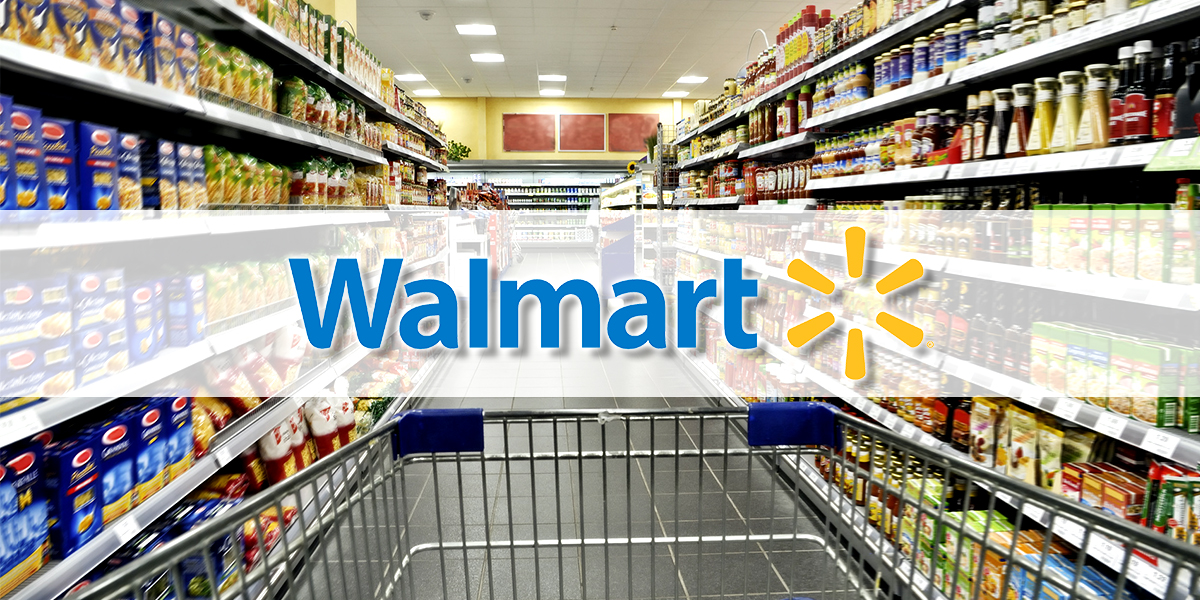

<b> What is retail sales forecasting ? </b>

Forecasting in retail involves evaluating past revenues and consumer behavior over the previous months or year inorder to discern patterns and develop forecasts for the upcoming months. The data is adjusted for seasonal trends, and then the forecast is used as a plan for ordering and stocking products. After fulfillment of current and forthcoming customer purchases and orders, an assessment of the results is compared with previous forecasts, and the entire procedure is repeated.

<b> Why is it important ?</b>

An accurate forecast that meets the forthcoming consumption demands of customers help retail businesess to maximize and extend profits over the long-term. This forecast permits price adjustments to correspond with the current level of consumer spending patterns, and helps to better maintain and control a sufficient, yet also efficient, inventory that meets the consumer demand without being too excessive. 

<b> Scenario </b>

We have hierarchical sales data from Walmart, the largest company by revenue in the world, and the goal is to forecast daily sales for the next 28 days. Moreover, the data comes from three US States, California, Texas and Wisconsin, and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events that should be used in order to make the forecast as accurate as possible.

## Outline for Sales Forecast

1. Framing the Problem
2. Preparing the Data
3. Exploratory Data Analysis
4. Feature Engineering
5. Modeling
6. Fine-Tuning the Best Model
7. Drawing Conclusions

# 1. Framing the Problem

When forecasting retail sales we have to consider certain components that help to catch the consumer demand from the past behavior of the consumers. This is driven from two major factors: the quality and the price of the product. On the one hand, we have knowledge of the actual daily prices of the products, so this enables us to calculate the price elasticities, and for the other - the quality ; this will be approximinated by analyzing the past retail sales of the stores with the help of five main components: 

- `Autoregressive (AR)`   - in the form of linear combinations of past values of the time series up to some number 
of lags. The products sold in the past help to predict the number of products being sold in the future.


- `Moving Average (MA)`    -    in the form of linear combinations that are calculated from the averages of variables in the past. This is the strongest component because it enables to approximate averages from a large set of samples.

- `Trend`    -    as in whether we can see a linear or non-linear trend in product sales that help to forecast the future. 

- `Seasonal`    -    that can be explained happening at a certain particular time with a certain frequency. 


- `Exogenous`, that come outside the model, for example economic indicators in the form of the unemployment rate, the rate of inflation, growth of the national gross domestic product or the changes in the stock market that can produce a shock in the demand. A minor shock can also be produced with price changes, so we will calculate the price elasticities as a form of competition coming outside the model that affects consumer demand.


The components can be explained with a SARIMAX model (i.e. Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) which takes into account all of the five different components. 

Which component should be included and how much in the past should we look into, can be statistically tested by having a closer look at the Autocorrelation (ACF) and Partial autocorrelation (PACF) functions of the variables which measure the correlation coefficient between a time-series and the lagged version of itself. 

Once we would have managed to pinpoint the correct amount of lags for each variable, we could calculate the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC) to help choose the model. However, before choosing the lag components, all the variables should be tested for stationarity with the Augmented Dicki-Fuller test, which checks that the variables do not change during time, as if they do change, they cannot be forecasted with a SARIMAX model. The data thus needs to be starionary so that:

- Trend is zero,


- Variance is constant, 


- Autocorrelation is constant 

This means that the distribution of the data shouldn't change during time, but if it would change, the data should be made stationary by for example transforming them either with log-transformations or differencing, which eventually depend whether there is a seasonal or trend component or both involved that needs to be taken care of.

<b> Choosing the Model </b>

If we would be choosing a SARIMAX model we would need to compute the lag terms separately for each variable and store, and make the variables stationary. This can prove to be quite burdensome with a huge dataset with many variables, but also, and most importantly, could pose some difficulties in capturing all the non-linear effects that affect capturing the signal from the noise in forecasting.

Another, more modern approach, comes with the Light Gradient Boosting Machine (LGBM), which is a decision tree based emsemble technique that is able to capture complex, non-linear patterns, that also scale well to large datasets with many variables. The benefit of this approach is that we can incorporate all the variables together, and forecast multiple time series with a single machine learning model instead of choosing the right variables and right amount of lag for each store separately. By using an ensemble technique that utilizes boosting, we are able to take advantage of the average of multiple weaker models. This technique is not only fast to implement, but also often outperforms the more classical type of time series models such as the SARIMAX, and this is also why we are going to choose LGBM as our model.

<b> Evaluating the Model </b>

We will have a decision tree based model that is able to pick the right features from the set that it will be given to. We will mix this up by given a random sample and random subsample of features to each tree to avoid overfitting. The model will be trained with a validation set and the forecasting will be made with a never-before-seen test set. Finally, we will analyze these results and adjust the accuracy with some fine-tuning of the best model before making the actual 28 day forecast.

In [4]:
# Importing relevant modules
import pandas as pd
import numpy as np
import scipy.stats as stats

import datetime as dt
import pickle, joblib
from pathlib import Path
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Modeling tools
import lightgbm
from lightgbm import LGBMRegressor

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit

# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore')

# plot styling preferences
%matplotlib inline
plt.style.use('seaborn-whitegrid')

font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 18, 8
pd.set_option('max_columns', None)

# 2. Preparing the Data

In [5]:
# Loading datasets

sales = pd.read_csv('data/sales_train_evaluation.csv')
calendar = pd.read_csv('data/calendar.csv')
prices = pd.read_csv('data/sell_prices.csv')

sales.shape, calendar.shape, prices.shape

((30490, 1947), (1969, 14), (6841121, 4))

In [6]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


The size of the dataframe is huge with 30,490 rows and 1947 columns. We can see that the the dataset contains unit sales per product and department store, where we have over 30,000 different products that have been sold in a timeframe of 1941 days (5.3 years).

The memory usage is also over 450MB as the variables are in dtype int64 form, but this can be reduced, as they do not need to be in such an accurate form that takes so much memory.

The first six variables are identity numbers to help track what has been sold and were it was sold.

In [8]:
print('There are {} unique products in the dataset.'.format(sales['id'].nunique()))

There are 30490 unique products in the dataset.


In [9]:
print('There are {} products with id tags.'.format(sales['item_id'].nunique()))

There are 3049 products with id tags.


We can see that there are 3049 unique products in the dataset which have 10-times more id tags, making a total of 3049. If we look at the first variable, 'id', it is a unique tag for each item in the different stores while the second variable 'item_id' is related to a certain product that is sold in each of the stores. The id is the longer description of a specific item while the item_id is the shorter. For example the first 5 ids show 5 products with their product ids, store ids, state ids and department ids, while the first 5 item ids only show the department id and the product id.

In [10]:
# All categories

sales['cat_id'].unique().tolist()

['HOBBIES', 'HOUSEHOLD', 'FOODS']

In [11]:
# All departments

sales['dept_id'].unique().tolist()

['HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2',
 'FOODS_1',
 'FOODS_2',
 'FOODS_3']

In [12]:
# All stores

sales['store_id'].unique().tolist()

['CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3',
 'WI_1',
 'WI_2',
 'WI_3']

In [13]:
# All States

sales['state_id'].unique().tolist()

['CA', 'TX', 'WI']

We can see that the 10 stores are spread in 3 States with the 4 stores in California and 3 in Texas and Wisconsin. All the stores three categories of products being sold, food, household and hobbies. These are spread in 7 departments, the food department being the largest with 3 separate departments.

In [14]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [15]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [16]:
calendar['event_name_1'].unique().tolist()

[nan,
 'SuperBowl',
 'ValentinesDay',
 'PresidentsDay',
 'LentStart',
 'LentWeek2',
 'StPatricksDay',
 'Purim End',
 'OrthodoxEaster',
 'Pesach End',
 'Cinco De Mayo',
 "Mother's day",
 'MemorialDay',
 'NBAFinalsStart',
 'NBAFinalsEnd',
 "Father's day",
 'IndependenceDay',
 'Ramadan starts',
 'Eid al-Fitr',
 'LaborDay',
 'ColumbusDay',
 'Halloween',
 'EidAlAdha',
 'VeteransDay',
 'Thanksgiving',
 'Christmas',
 'Chanukah End',
 'NewYear',
 'OrthodoxChristmas',
 'MartinLutherKingDay',
 'Easter']

In [17]:
calendar['event_type_1'].unique().tolist()

[nan, 'Sporting', 'Cultural', 'National', 'Religious']

In [18]:
calendar['event_name_2'].unique().tolist()

[nan, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"]

In [19]:
calendar['event_type_2'].unique().tolist()

[nan, 'Cultural', 'Religious']

In [20]:
calendar['snap_CA'].unique(), calendar['snap_TX'].unique(), calendar['snap_WI'].unique()

(array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64))

In [21]:
calendar['snap_CA'].value_counts(), calendar['snap_TX'].value_counts(), calendar['snap_WI'].value_counts()

(0    1319
 1     650
 Name: snap_CA, dtype: int64,
 0    1319
 1     650
 Name: snap_TX, dtype: int64,
 0    1319
 1     650
 Name: snap_WI, dtype: int64)

We notice that there are less rows and columns compared to the previous dataset so this takes less memory, but we can still make the changes aswell for the variable dtypes as they do not need to be in this accurate form either.

The calendar contains information about the dates and special events that have taken place. These include the specfic day, the day of the week, week, month, and year, with the seasonally occurring events such as the Super Bowl or any other event that occur each year during the same time. SNAP is an acronym for Supplement Nutrition Assistance Program which is a butrition assistance benefit provided by the US federal government. It is aimed for low income families and individuals with an Electronic Benefits Transfer debit card for food purchases.  Both the SNAP and the events should presumably show as increased sales in the stores.

In [22]:
prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [23]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


The prices contain information about the price of the products sold per store and the date. This is also a big dataset as it uses 208MB of memory by having over 6.8M rows and 4 columns. We can again make the change for the dtype variable for this as well, as with the previous datasets as the variable doesn't need to be this accurate so let's start by proceeding to change the dtypes of the variables in order to reduce memory usage for the calculations.

## Memory Usage

For the challenge of the memory usage, we will create a function that goes through all the different dtypes of integers with the variables in the dataframes and changes the dtype by comparing the minimum and maximum value of a column to the the minimum and maximum value of a dtype integer or float. The dtypes range from 8 to 64 depending on the amount of integers they have, so we will iterate for the types from the smallest to the largest in order to save memory. While the smallest dtype int8 consumes just 1 byte of memory per row, the largest int64 consumes 8 bytes per row which can make a big difference in a dataset that is as large as ours. At the same time we take advantage of iterating through all the dataframes by also changing the objects that are not dates as categories to optimize memory usage even further, and all the dates into datetime objects so that they can be used later for better calculations.

In [24]:
# Convert variables into more efficient dtypes and dates into datetime objects

def convert(df):
    """If the type of variable in the dataframe is an integer of float, the function
    checks the minimum and maximum value of the cells in a column and changes the dtype
    of integers and floats accordingly to smallest possible in order to save memory.
    If the type is an object with a date, the function changes this to a datetime object,
    else into a category.
    """
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i,t in enumerate(types):
        # Integers into int8, int16, int32 or int64
        if 'int' in str(t):
            # Check if minimum and maximum are in the limit of int8
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            # Check if minimum and maximum are in the limit of int16
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            # Check if minimum and maximum are in the limit of int32
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            # Choose int64
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        # Floats into float16, float32 or float64
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        # Objects into datetime or category
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = convert(sales)
prices = convert(prices)
calendar = convert(calendar)

In [25]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1317), int8(624)
memory usage: 96.6 MB


In [26]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB


## Combining Datasets

Now that the dataset variables are in more compact form let's combine the three datasets together. The sales dataframe is in a wide dataframe format as it has all the days as columns, but the other datasets have a long format where the days are as rows. We convert the sales data into long format with the pandas melt function, where we indicate the variables that we want as columns and the variable that we want to transform as rows. This way we create a new column called sales that indicates the number of items that were sold on a particular day.

In [27]:
# Melting the sales dataset from wide format to long

df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
             var_name='d', value_name='sales').dropna()

df.shape

(59181090, 8)

Now all the datasets are in the same format so we can combine them by merging them together.

In [28]:
# Combine sales, calendar and prices by merging all together

df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [29]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  wm_yr_wk   weekday  wday  month  year  \
0       CA  d_1      0 2011-01-29     11101  Saturday     1      1  2011   
1       CA  d_1      0 2011-01-29     11101  Saturday     1      1  2011   
2       CA  d_1      0 2011-01-29     11101  Saturday     1      1  2011   
3       CA  d_1      0 2011-01-29     11101  Saturday     1      1  2011   
4       CA  d_1      0 2011-01-29     11101  Saturday     1      1  2011   

  event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0          NaN          NaN          NaN          NaN        0        0   
1          NaN          NaN          NaN          NaN        0        0   
2          NaN          NaN          NaN          NaN        0        0   
3          NaN          NaN          NaN          NaN        0        0   
4          NaN          NaN          NaN          NaN        0        0   

   snap_WI  sell_price  
0        0         NaN  
1        0         NaN  
2        0         NaN  
3        0         NaN  
4        0         NaN

In [30]:
# We can delete the sales dataframe to save memory

del sales

# 3. Exploratory Data Analysis

The goal is to forecast 28 days for the total sales of the stores so the key will be to find patterns that could help making the forecast more accurate. We will start by first looking at the sales more generally, and move to a more detailed analysis once we reach the sales figures occurring in different stores. Finally, at the end we will look at the correlations between the variables.

In [28]:
# Statistics for sold products

df['sales'].describe().apply(lambda x: format(x, 'f'))

count    59181090.000000
mean            1.130888
std             3.870038
min             0.000000
25%             0.000000
50%             0.000000
75%             1.000000
max           763.000000
Name: sales, dtype: object

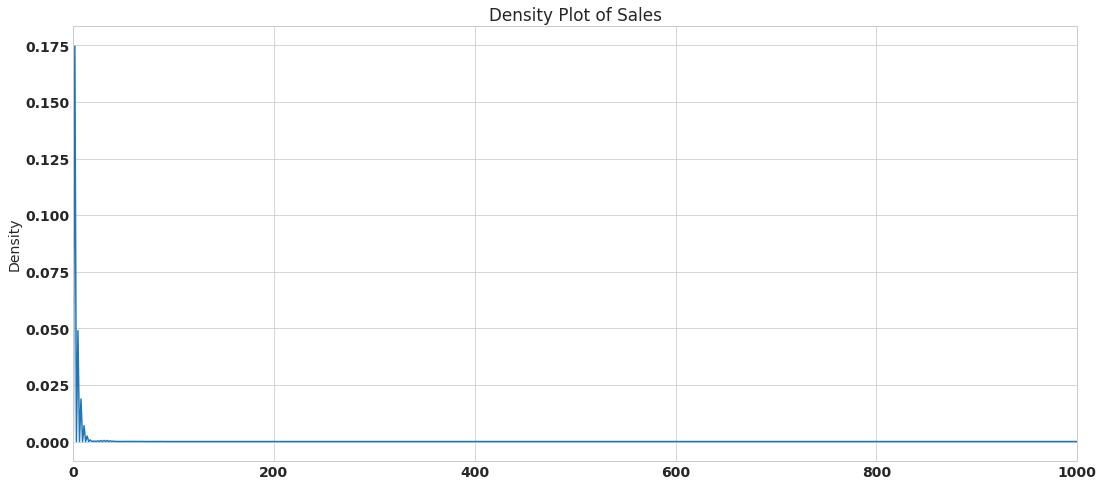

In [30]:
df['sales'].plot(kind='density', xlim=[0, 1000])
plt.title('Density Plot of Sales')
plt.show()

We can see that in a bit over 5 years, 59M products have been sold in the 10 Walmart stores. There are some products that sell more than others, but most that get sold are sold only once per day. The statistics and the density plot show that the distribution is concentrated around the mean of zero with a long right-tail just as with a Poisson distribution.

In [31]:
# Creating sales revenues

df['revenues'] = df['sales'] * df['sell_price']

## Sale Dates

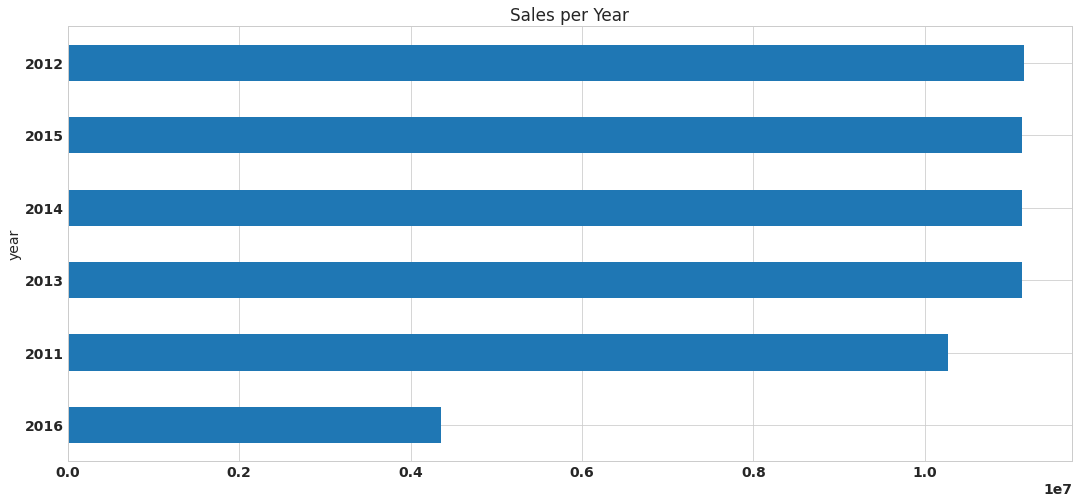

In [35]:
# Plotting sales per year

df.groupby(['year'])['sales'].count().sort_values().plot(kind='barh')
plt.title('Sales per Year')
plt.show()

The sales figures looks steady from year to year and there hasn't been a big change in the sales since the best year in 2012.

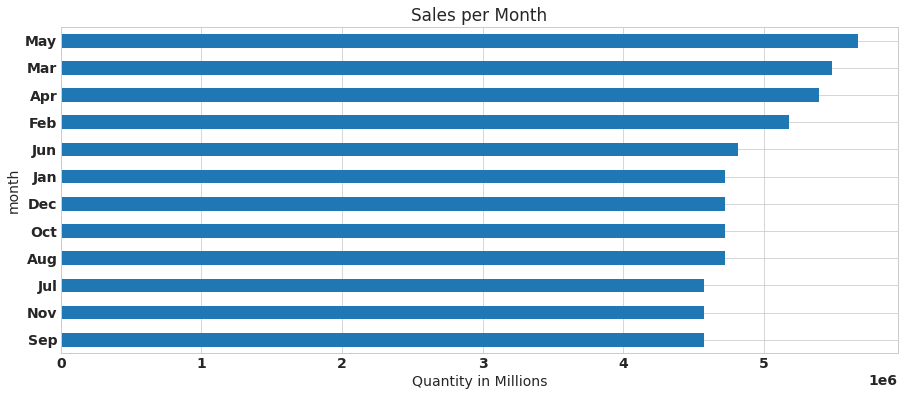

In [32]:
# Plotting sales per month

df.groupby(['month'])['sales'].count().sort_values().plot(kind='barh')
plt.title('Sales per Month')
months = {'0':'Sep','1':'Nov','2':'Jul','3':'Aug','4':'Oct','5':'Dec','6':'Jan','7':'Jun','8':'Feb', '9':'Apr','10':'Mar','11':'May'}
plt.yticks(ticks=np.arange(0,12,1), labels=months.values())
plt.xlabel('Quantity in Millions')
plt.show()

This is more informative than the previous plot as we see a clear pattern occurring where the best sales take place in the beginning of the year from February till May.

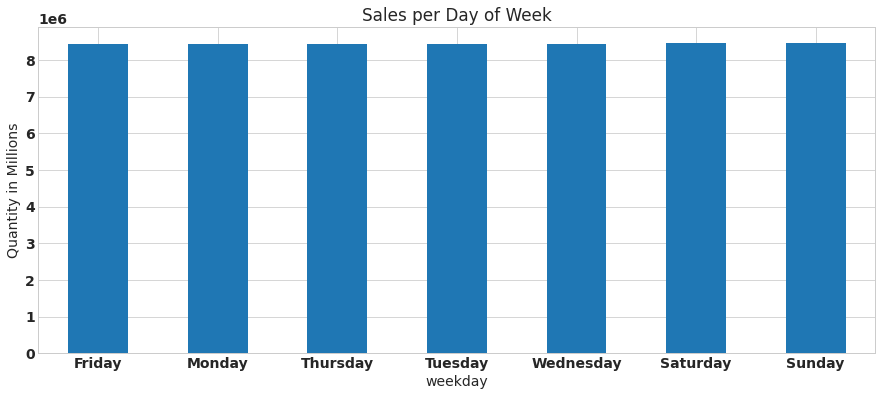

In [33]:
# Plotting sales per day

df.groupby(['weekday'])['sales'].count().sort_values().plot(kind='bar', rot=360)
plt.title('Sales per Day of Week')
plt.ylabel('Quantity in Millions')
plt.show()

The best days for sales occur on Friday in the beginning of the weekend, and on Monday in the beginning of the week. Thursday also seems to be a good while Saturday and Sunday have less sales compared to the other days of the week.

## State Sales

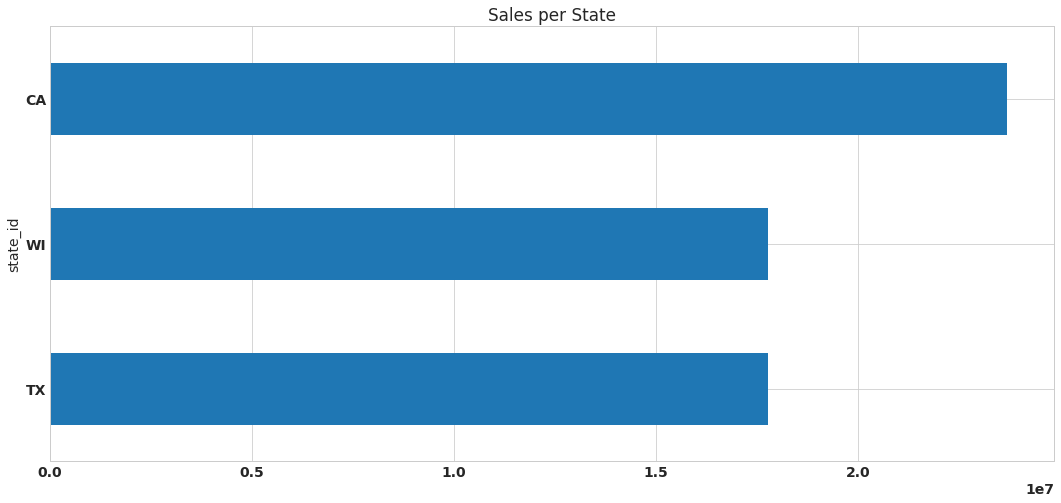

In [37]:
# Plotting sales in quantity per state

df.groupby(['state_id'])['sales'].count().sort_values().plot(kind='barh')
plt.title('Sales per State')
plt.show()

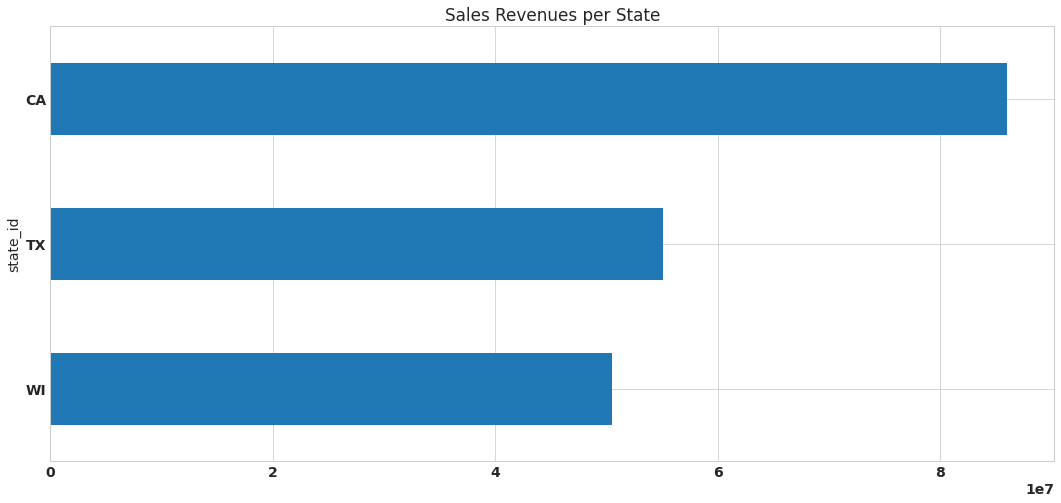

In [38]:
# Plotting sales revenues per state

df.groupby(['state_id'])['revenues'].sum().sort_values().plot(kind='barh')
plt.title('Sales Revenues per State')
plt.show()

The quantity of products sold and sales revenues look similar. California has the biggest sales in quantity and revenues from the three States.

## Category Sales

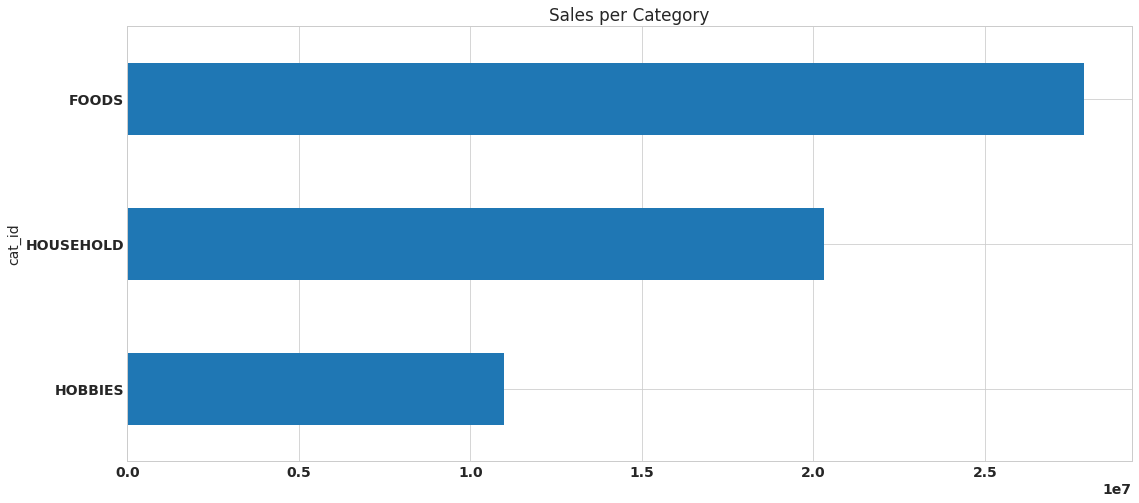

In [39]:
# Plotting quantity sold per category

df.groupby(['cat_id'])['sales'].count().sort_values().plot(kind='barh')
plt.title('Sales per Category')
plt.show()

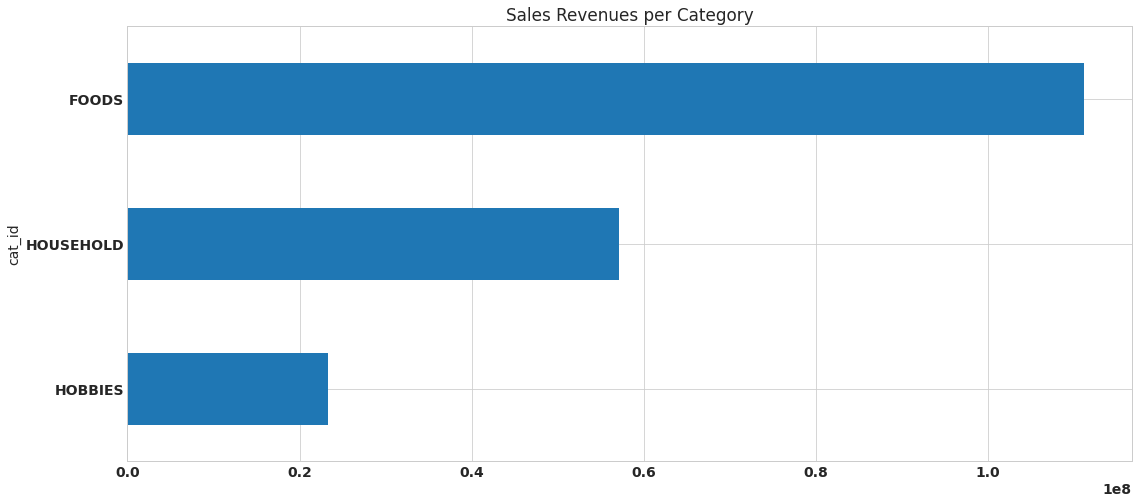

In [40]:
# Plotting sales revenues per category

df.groupby(['cat_id'])['revenues'].sum().sort_values().plot(kind='barh')
plt.title('Sales Revenues per Category')
plt.show()

The food category sells the most in quantity and brings the most revenues from the three different categories.

## Department Sales

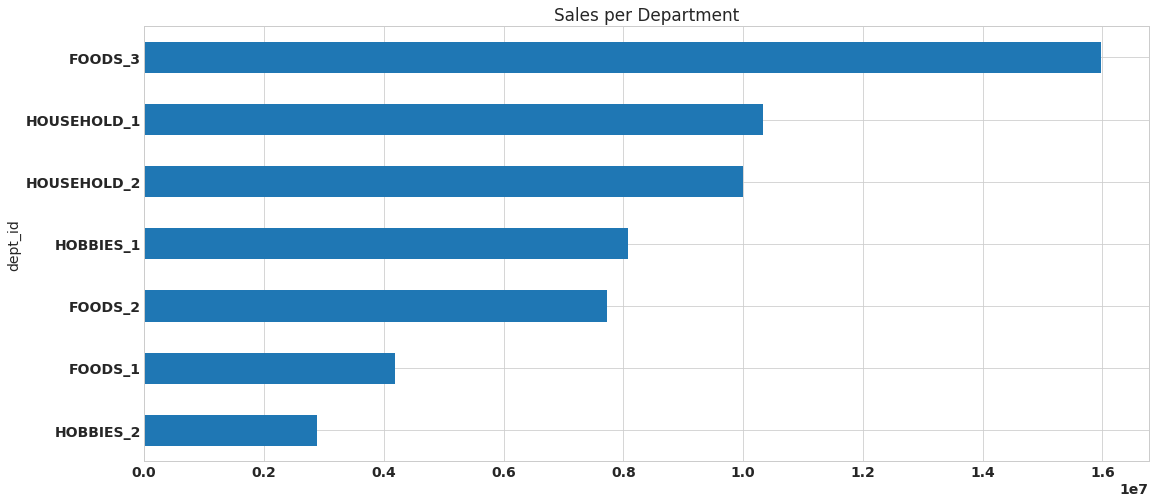

In [41]:
# Plotting quantity sold per department

df.groupby(['dept_id'])['sales'].count().sort_values().plot(kind='barh')
plt.title('Sales per Department')
plt.show()

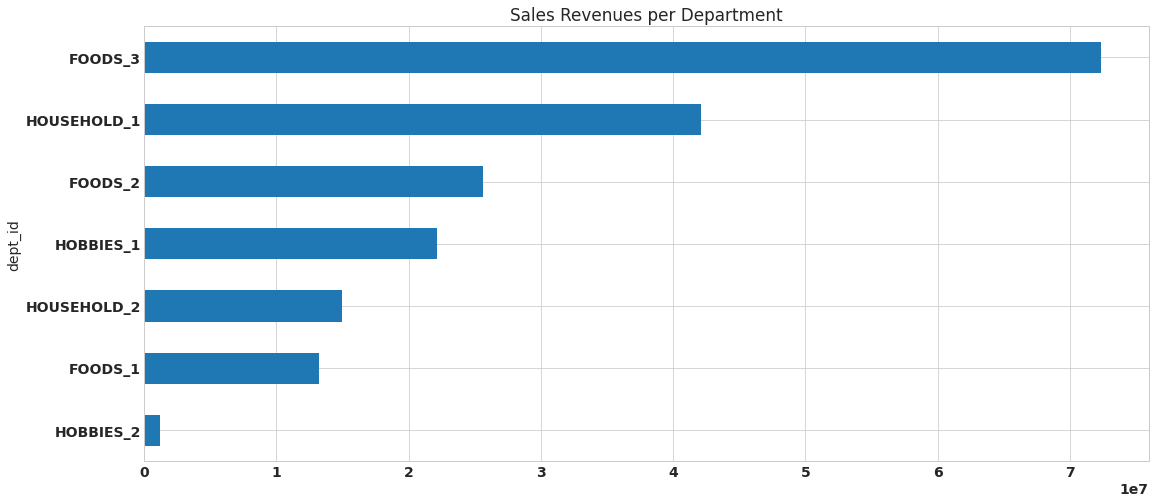

In [42]:
# Plotting sales revenues per department

df.groupby(['dept_id'])['revenues'].sum().sort_values().plot(kind='barh')
plt.title('Sales Revenues per Department')
plt.show()

The third food department sells the most in quantity and generates the most in revenues from all the 7 different departments. The two household departments sell a large quantity of products but only the first department seems to generate well revenues, as the second food department sells less products but generates more revenues than the second household department.

In [37]:
df.pivot_table(index=['dept_id'], values=['revenues', 'sales'], aggfunc={'revenues': [np.sum, np.mean, np.std],
                                                                      'sales': ['count', np.mean, np.std]})

revenues                              sales                    
                 mean        std         sum       count      mean       std
dept_id                                                                     
FOODS_1      3.676016   9.311036  13201376.0   4192560.0  1.238003  3.055423
FOODS_2      4.544296   9.975267  25592544.0   7725180.0  1.009041  2.696293
FOODS_3      5.753336  14.146351  72349928.0  15974430.0  2.061858  6.311087
HOBBIES_1    3.359081  10.986733  22119816.0   8074560.0  0.705799  2.315094
HOBBIES_2    0.542189   1.890055   1201385.0   2892090.0  0.187284  0.753864
HOUSEHOLD_1  5.301954  10.499524  42132076.0  10326120.0  1.135262  2.749751
HOUSEHOLD_2  1.797366   4.452966  14982773.0   9996150.0  0.304241  0.832946

A closer look shows that there is actually a lot of variability between the different products inside the food departments. Let's plot the the sales of the three food departments.

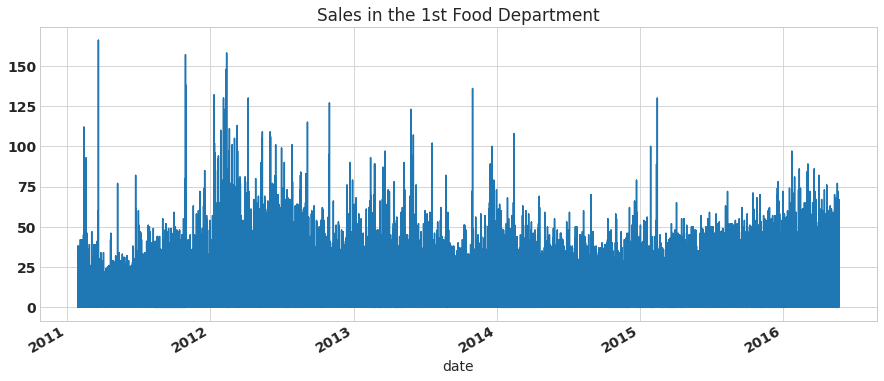

In [38]:
df.loc[(df.dept_id == 'FOODS_1')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 1st Food Department')
plt.show()

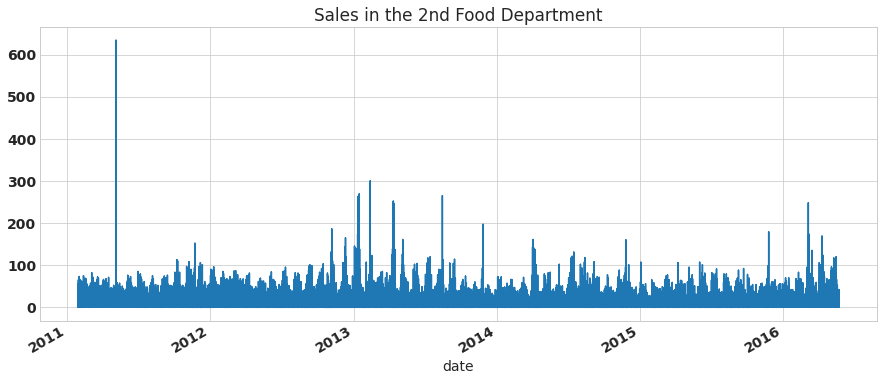

In [39]:
df.loc[(df.dept_id == 'FOODS_2')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 2nd Food Department')
plt.show()

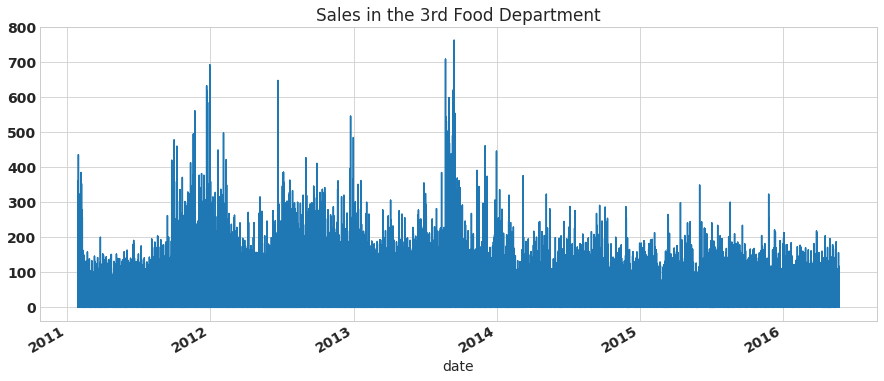

In [40]:
df.loc[(df.dept_id == 'FOODS_3')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 3rd Food Department')
plt.show()

We can see from the plots that there has been a steady flow of sales throughout the years with some distinct peaks happening in each year. The majority of the sales have occurred during 2011-2014. The first and third department have had a more volatile demand and seem to follow more closely to each other while the second department has as a more steady and lower demand compared to the other two. The first department has peaks occurring at the beginning of the year which could be an indication of a seasonal demand being high in the beginning of the year. The trend also looks slightly upward sloping from 2015 onwards. Let's now check the other departments from hobbies and household categories.

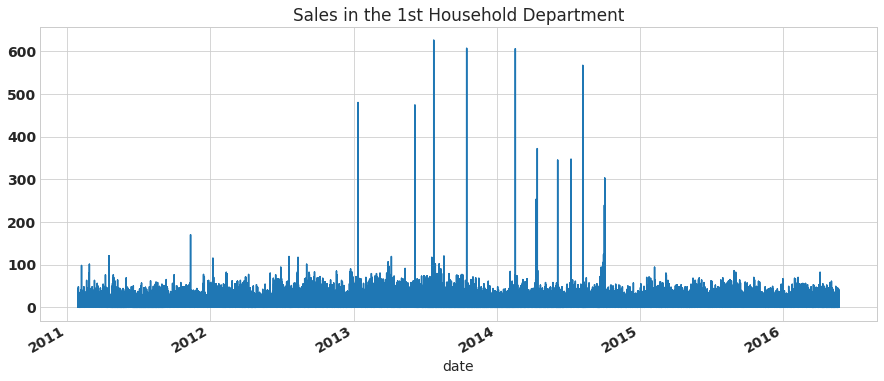

In [41]:
df.loc[(df.dept_id == 'HOUSEHOLD_1')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 1st Household Department')
plt.show()

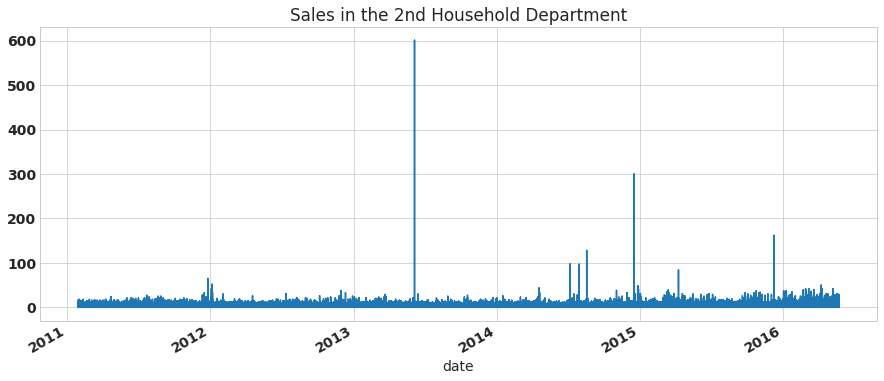

In [42]:
df.loc[(df.dept_id == 'HOUSEHOLD_2')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 2nd Household Department')
plt.show()

For the household departments we can see an even clearer peaks when a high volume of sales has occurred proabbly because of some promotional events.

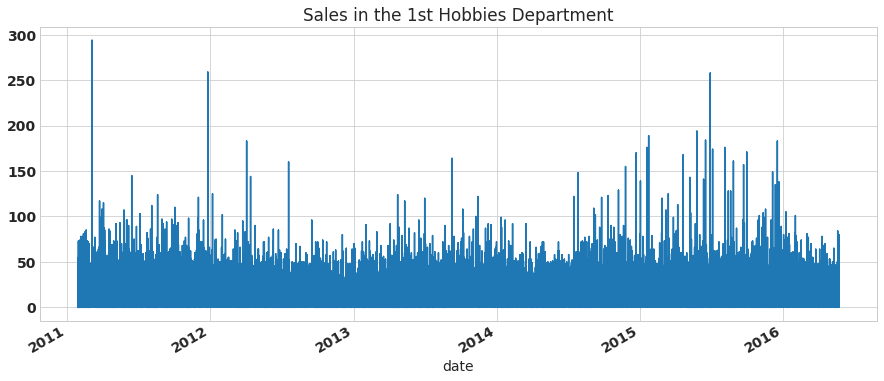

In [44]:
df.loc[(df.dept_id == 'HOBBIES_1')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 1st Hobbies Department')
plt.show()

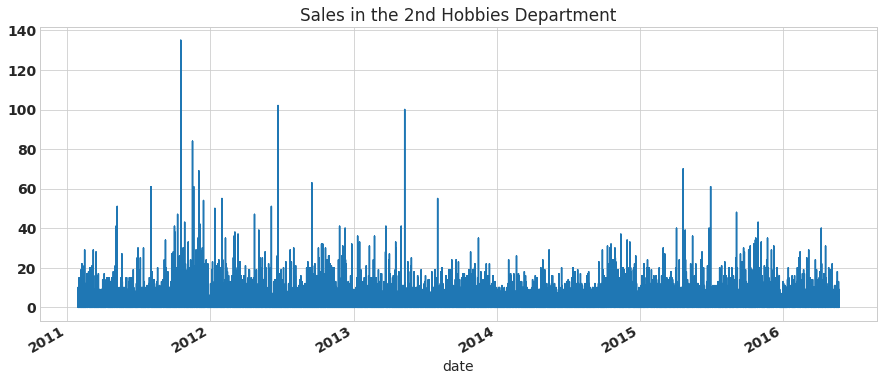

In [45]:
df.loc[(df.dept_id == 'HOBBIES_2')][['date', 'sales']].set_index('date').sum(axis=1).plot()
plt.title('Sales in the 2nd Hobbies Department')
plt.show()

We can see a similar pattern of more disctinct peaks occurring in the sales of both departments. Just before 2015, and from that point onwards there seems to have been a surge in demand for the 1st hobbies department, and overall the demand has been higher for the 1st department compared to the second one.

Now that we've had a look at the departments, let's move on to store level sales.

## Store Sales

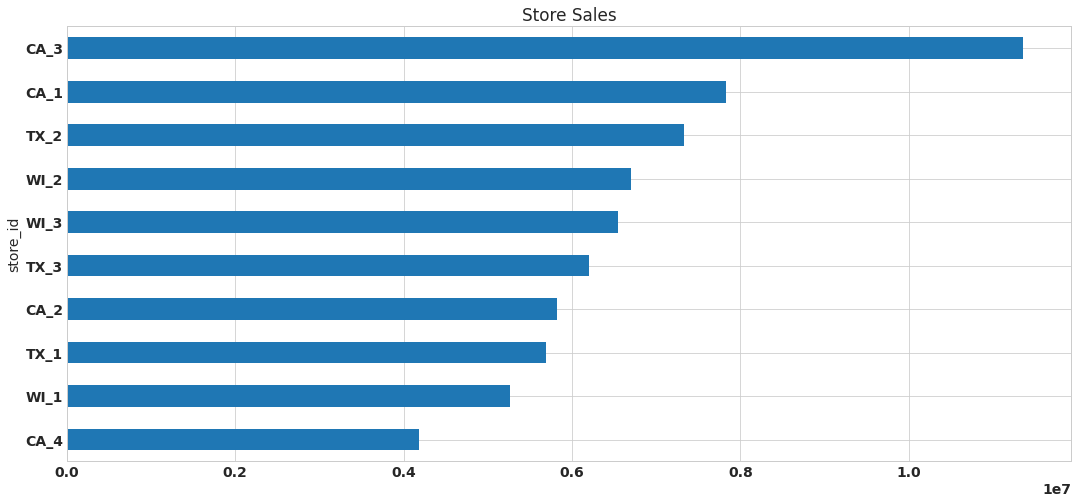

In [77]:
df.groupby(['store_id'])['sales'].sum().sort_values().plot(kind='barh')
plt.title('Store Sales')
plt.show()

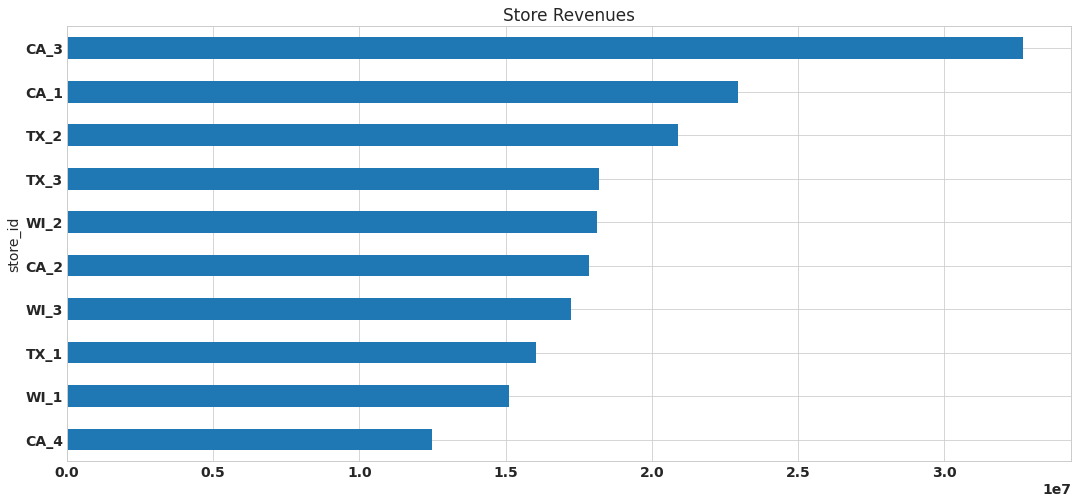

In [78]:
df.groupby(['store_id'])['revenues'].sum().sort_values().plot(kind='barh')
plt.title('Store Revenues')
plt.show()

Looking at revenues, we notice the two stores in California making the top two while two stores in Texas come next. Let's see the sales in the californian stores more closely.

In [45]:
df[df['store_id'] == 'CA_1']['sales'].describe()

count    5.918109e+06
mean     1.323438e+00
std      4.052476e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.480000e+02
Name: sales, dtype: float64

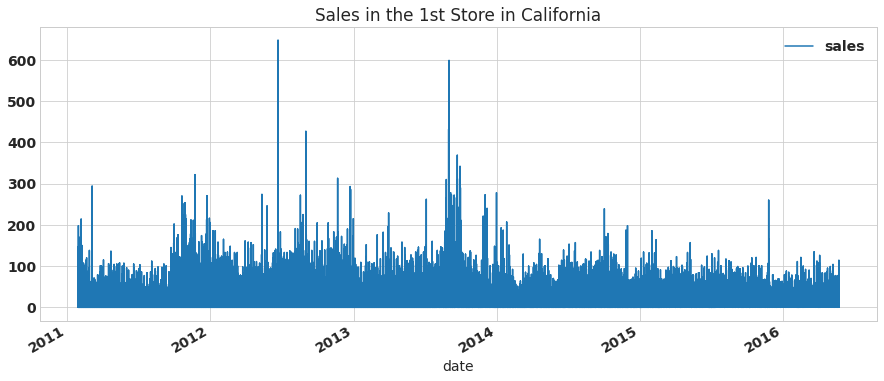

In [47]:
# Plotting sales in the first store in California

df.loc[(df.store_id == 'CA_1')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 1st Store in California')
plt.show()

We can see that the majority of sales have occurred at the end of 2011 to 2014. There is a steady inflow of sales with a few spikes when the sales have been much higher than normally.

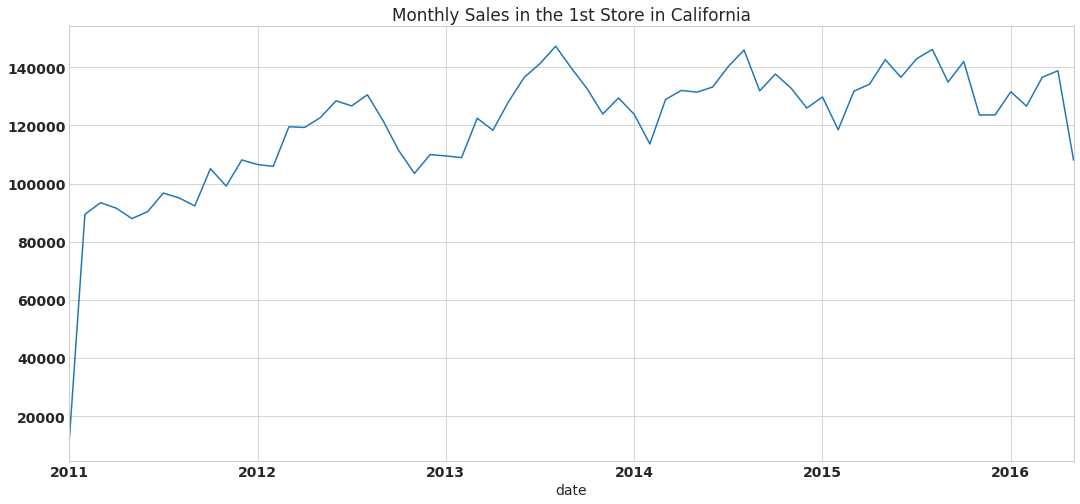

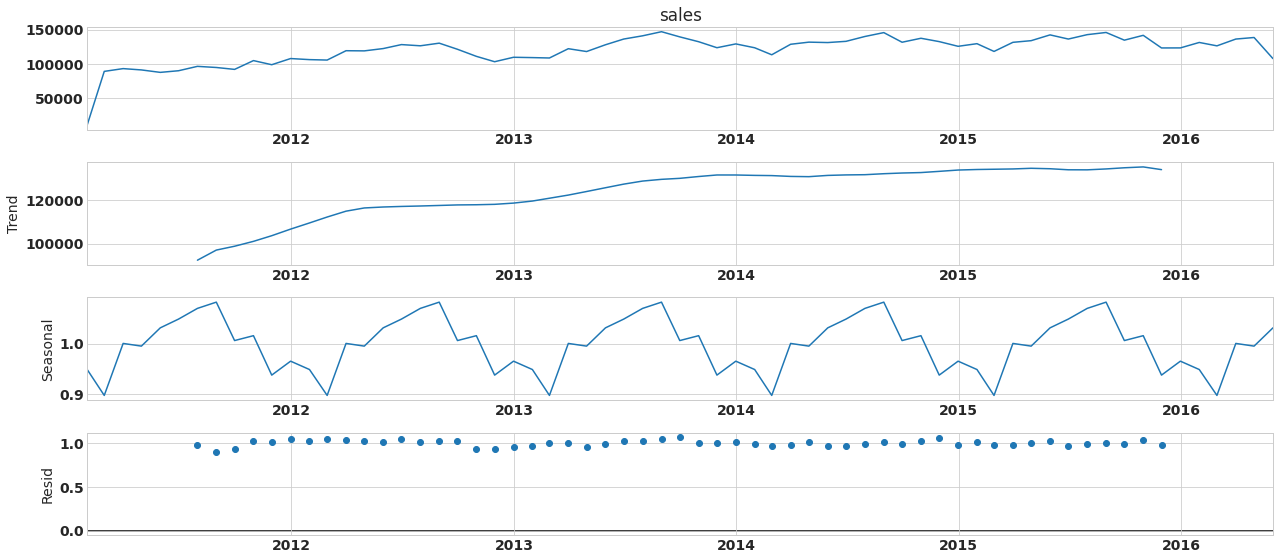

In [31]:
# Monthly Sales and Decomposition of Time Series

ca1_sales = df[df['store_id'] == 'CA_1'].groupby(['date'])['sales'].sum()
ca1_sales_monthly = ca1_sales.resample('M').sum()

fig = ca1_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 1st Store in California')
fig = seasonal_decompose(ca1_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

By using the statistical technique of time series decomposition we divided the monthly sales into three components that consist of the trend, seasonal and what is left afterwars, the residual. From this we notive an upward trend and a seasonal fluctuation as well.

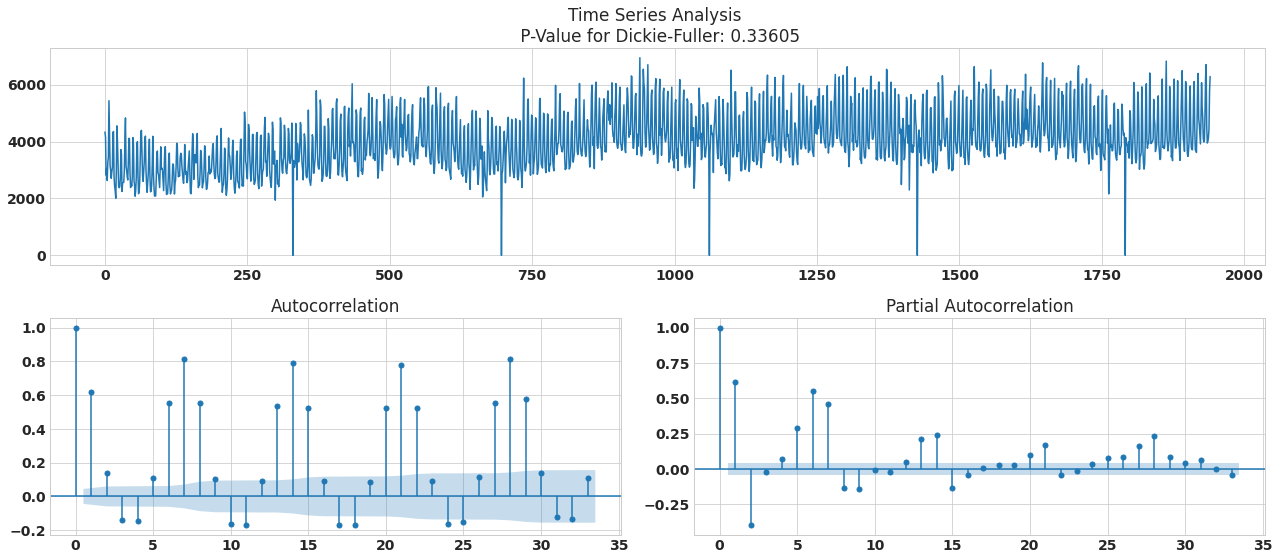

In [32]:
# Time Series Analysis

def tsplot(y, lags=None):
    """
    Time Series, ACF, PACF, and Augmented Dickey–Fuller Test.

    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure()
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis \n P-Value for Dickie-Fuller: {0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(ca1_sales.values)

A closer look at the series shows an increasing trend  together with a downward spike that occurs frequently, which means that once a year there is zero sales which could indicate the store being closed alltogether. 

The ACF and the PACF show autocorrelation from the past sales all the way extending to 28 days. The ACF that helps to see how many lag components should be added for the MA components shows that the first 9 days are significantly correlated, as well as the two last days of each week and the first two days of each week. The PACF, on the other hand, that helps to pinpoint the amount of lag for the AR components shows that all the first 9 days, except the third day, are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 1st store appear to have a clear linear postively increasing trend together with seasonal fluctuations that occur frequently.

In [46]:
# Statistics of sales from 2nd store in California

df[df['store_id'] == 'CA_2']['sales'].describe()

count    5.918109e+06
mean     9.831510e-01
std      2.766639e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.270000e+02
Name: sales, dtype: float64

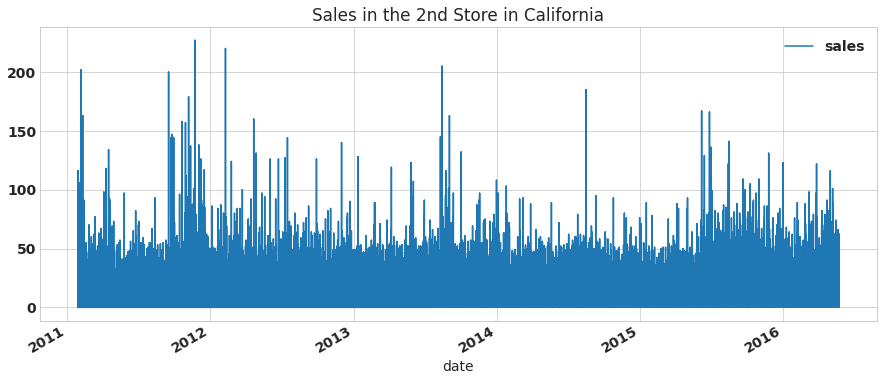

In [49]:
# Plotting sales in the second store in California

df.loc[(df.store_id == 'CA_2')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 2nd Store in California')
plt.show()

Looking at the sales in the second store in California we can see that after the middle of 2015 the sales have moved to a higher level and there are a number of high spikes when the sales have been a lot higher than normally.

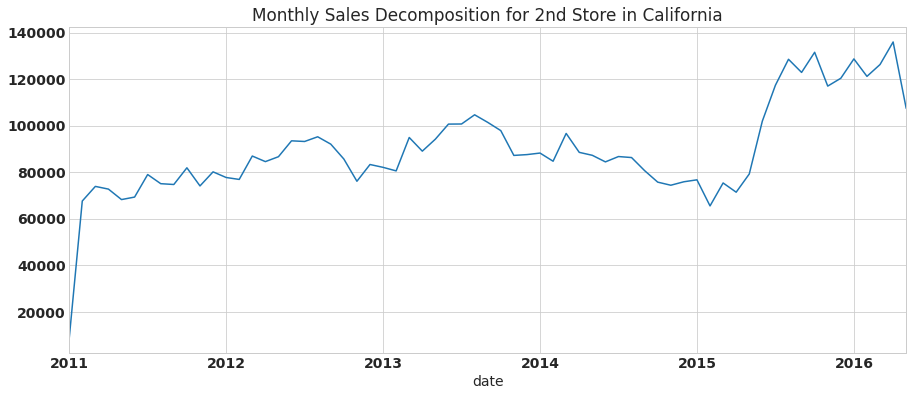

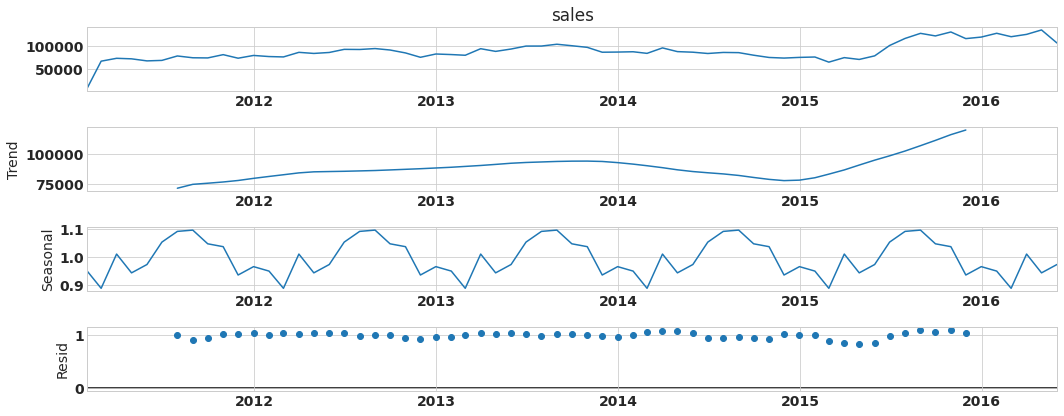

In [50]:
# Monthly Sales and Decomposition of Time Series

ca2_sales = df[df['store_id'] == 'CA_2'].groupby(['date'])['sales'].sum()
ca2_sales_monthly = ca2_sales.resample('M').sum()

fig = ca2_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 2nd Store in California')
fig = seasonal_decompose(ca2_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

There is an increasing trend until 2014, a decreasing trend until 2015 and then after 2015 again an increasing trend.

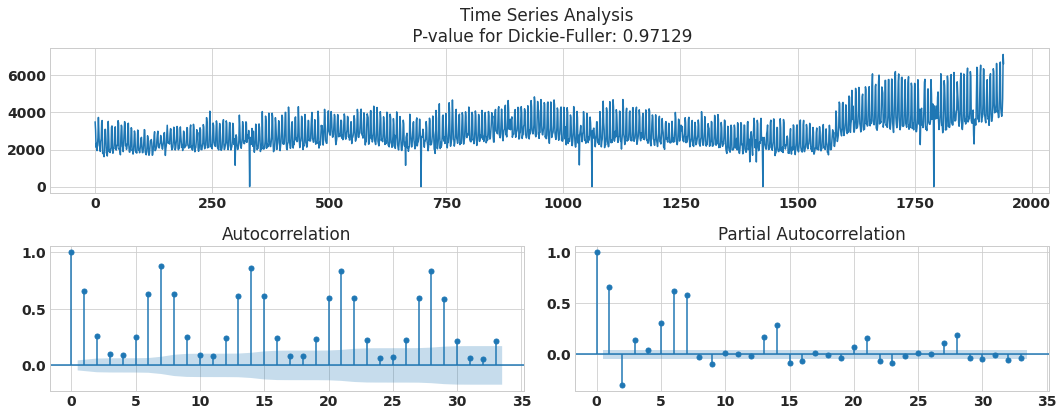

In [75]:
# Time Series Analysis

tsplot(ca2_sales.values)

The sales again show a spike downwards indicating zero sales.

The ACF shows that the first 9 days are significantly correlated, as well as the last days of each week and the first two days of each week. The PACF shows significance for the first 3 days, and for the 5th, 6th, 7th and 9th days, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 1st store appear to have a clear linear postively increasing trend together with seasonal fluctuations that occur frequently.

In [47]:
# Statistics of sales from 3rd store in California

df[df['store_id'] == 'CA_3']['sales'].describe()

count    5.918109e+06
mean     1.920130e+00
std      6.190596e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      7.630000e+02
Name: sales, dtype: float64

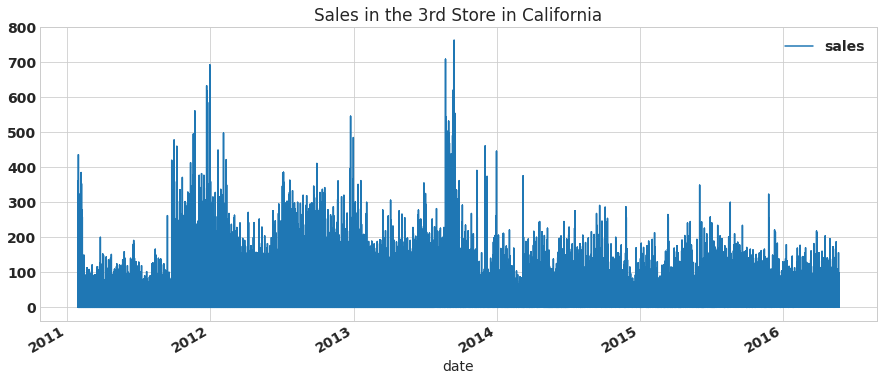

In [51]:
# Plotting sales in the third store in California

df.loc[(df.store_id == 'CA_3')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 3rd Store in California')
plt.show()

The sales in the third store is similar to the first store. Again, the bulk of the sales have occurred in 2012 to 2014, and since this period there has been a bit less sales with several high spikes occurring especially from 2011 to 2014.

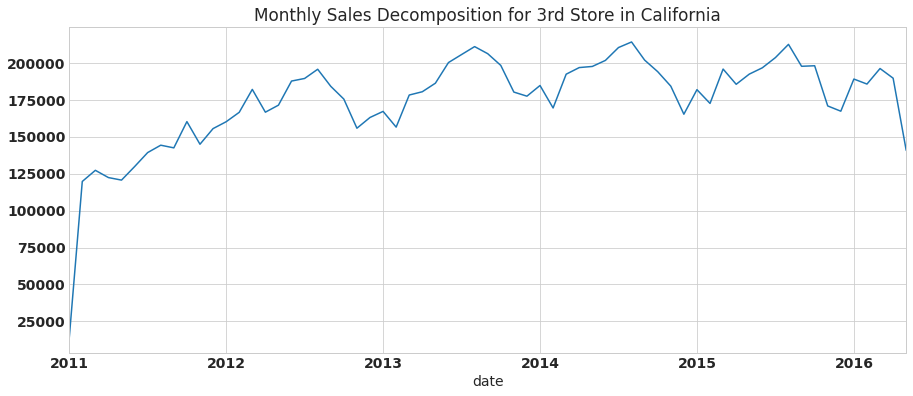

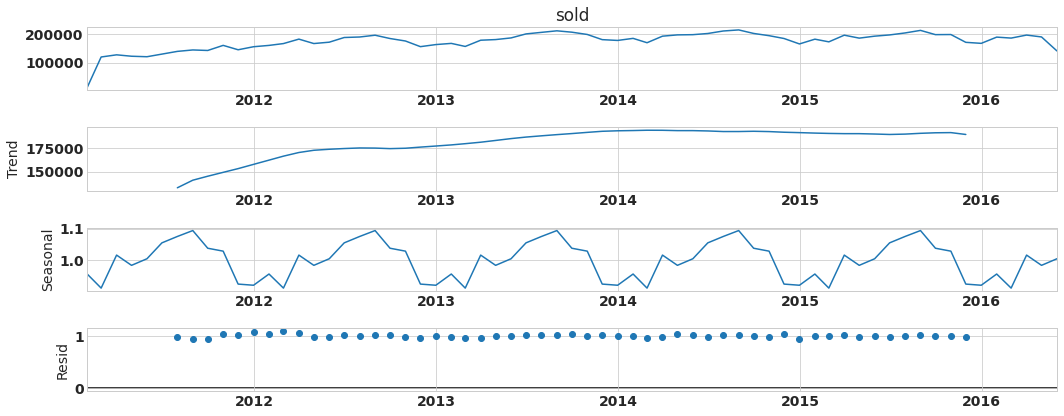

In [71]:
# Monthly Sales and Decomposition of Time Series

ca3_sales = df[df['store_id'] == 'CA_3'].groupby(['date'])['sales'].sum()
ca3_sales_monthly = ca3_sales.resample('M').sum()

fig = ca3_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 3rd Store in California')
fig = seasonal_decompose(ca3_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

The monthly sales show an upward trend from 2011 to 2014 where the growth seems to have stalled and even gone downwards from 2016 onwards.

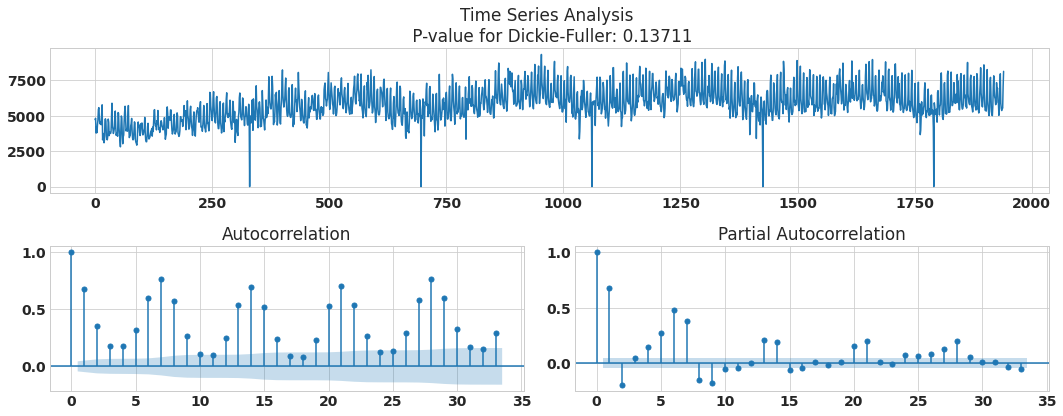

In [76]:
# Time Series Analysis

tsplot(ca3_sales.values)

The sales show a clear upward trend with seasonal fluctuations together wtih yearly downward spikes. The ACF shows that the first 9 days are significantly correlated, as well as the last days of each week and the first day of each week. The PACF shows that all the first 9 days, except the second day, are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 1st store appear to have a clear linear postively increasing trend together with seasonal fluctuations that occur frequently.

In [48]:
# Statistics of sales from 4th store in California

df[df['store_id'] == 'CA_4']['sales'].describe()

count    5.918109e+06
mean     7.067349e-01
std      2.003753e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.000000e+02
Name: sales, dtype: float64

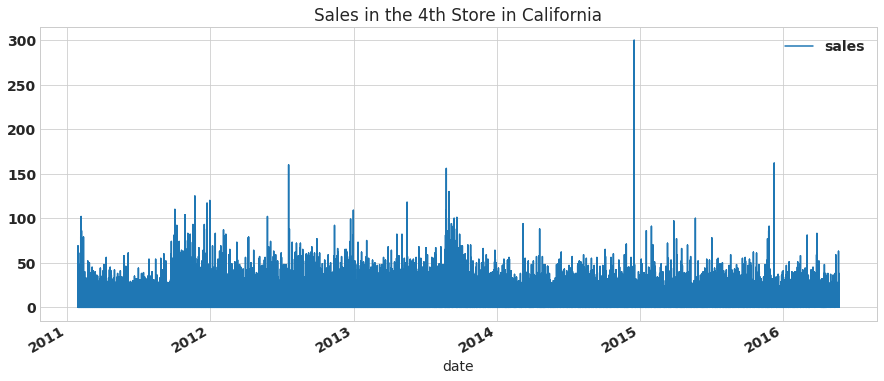

In [52]:
# Plotting sales in the fourth store in California

df.loc[(df.store_id == 'CA_4')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 4th Store in California')
plt.show()

Similar than what we have seen with the second store, where the bulk of sales have occurred during 2012 to 2014 and after this period, there is a steady inflow of sales with a few occasional high spikes in 2015 and 2016 around at the end of the year.

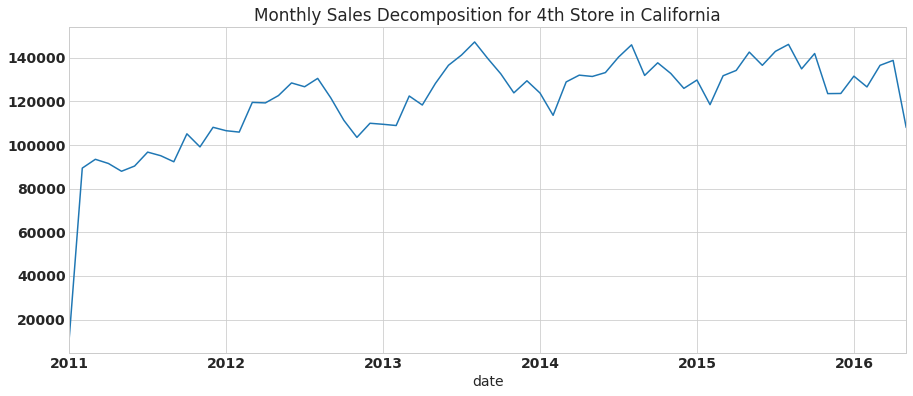

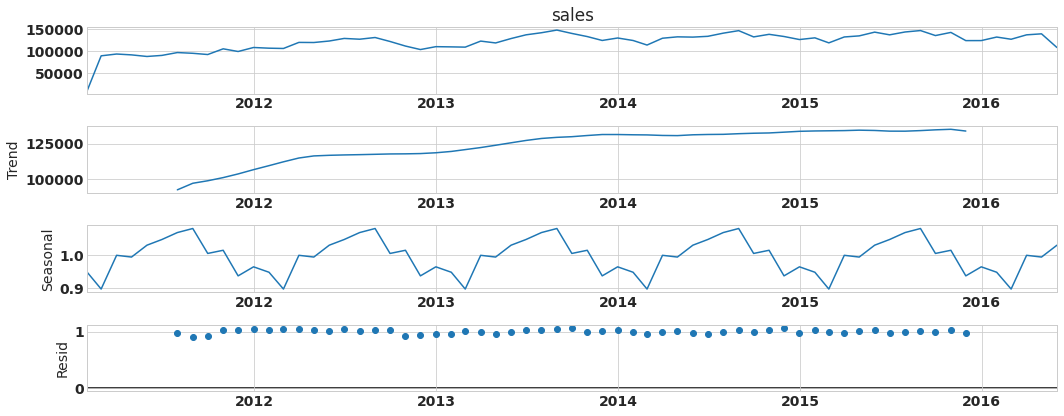

In [53]:
# Monthly Sales and Decomposition of Time Series

ca4_sales = df[df['store_id'] == 'CA_4'].groupby(['date'])['sales'].sum()
ca4_sales_monthly = ca1_sales.resample('M').sum()

fig = ca4_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 4th Store in California')
fig = seasonal_decompose(ca4_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

From the decomposition we can see a clear linear upward trend from 2012 to 2014, and a seasonal component that occurs frequently in a similar fashion as with the other stores.

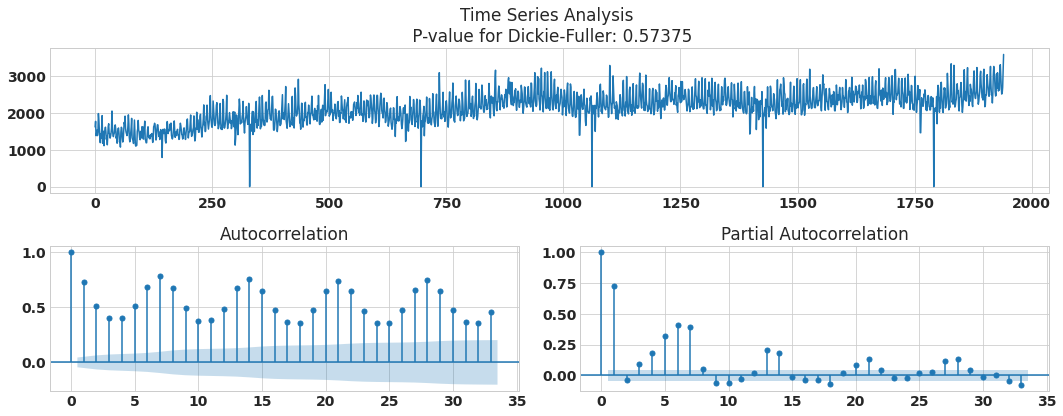

In [77]:
# Time Series Analysis

tsplot(ca4_sales.values)

The sales show an upward trend and downward spikes at each year as we have seen before.

The ACF shows that all the days from the 1st till the 28th are significantly correlated. The PACF shows that all the first 10 days are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 4th store appear to have a clear linear positively increasing trend together with seasonal fluctuations.

In [49]:
# Statistics of sales from 1st store in Texas

df[df['store_id'] == 'TX_1']['sales'].describe()

count    5.918109e+06
mean     9.619328e-01
std      3.324404e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.340000e+02
Name: sales, dtype: float64

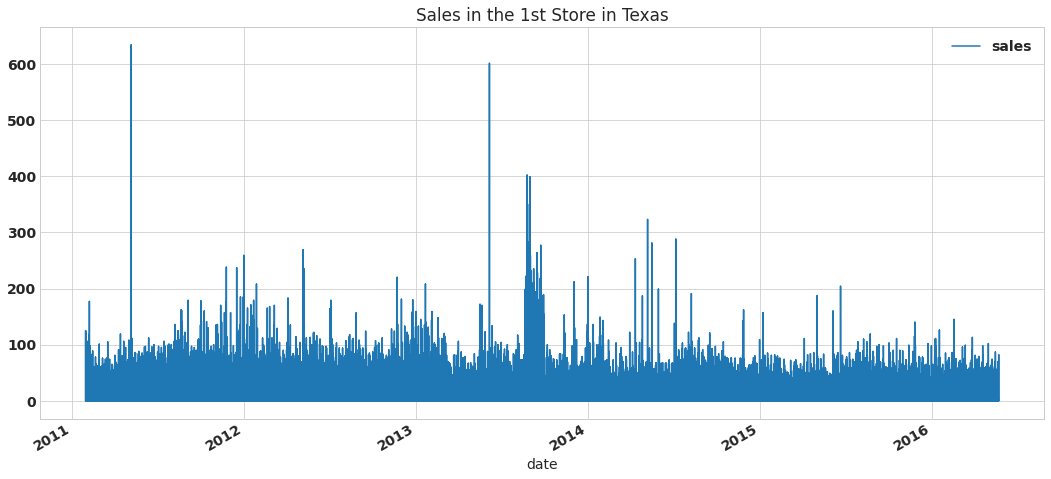

In [50]:
# Plotting sales in the 1st store in Texas

df.loc[(df.store_id == 'TX_1')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 1st Store in Texas')
plt.show()

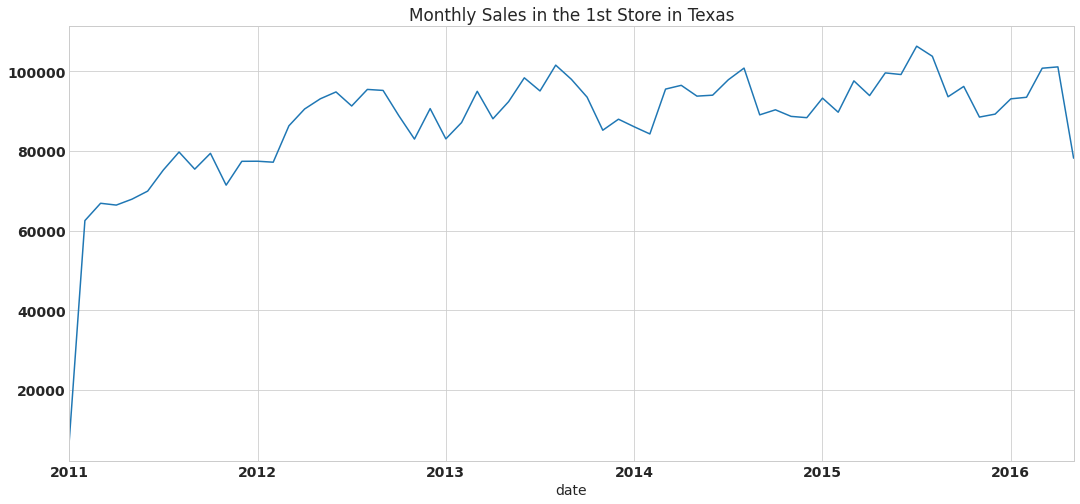

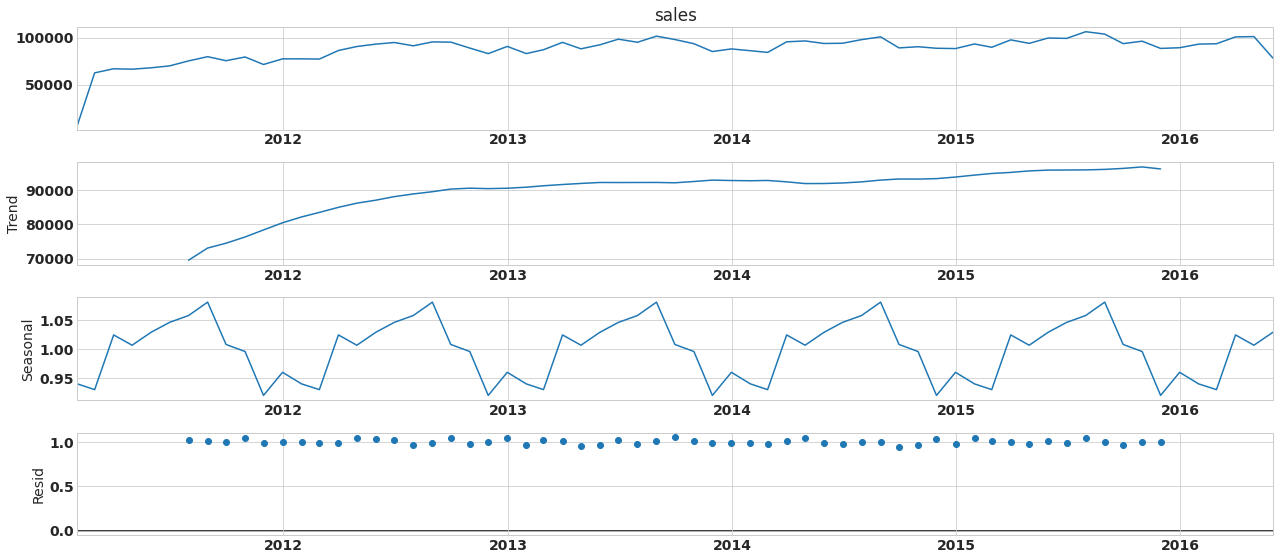

In [51]:
# Monthly Sales and Decomposition of Time Series

tx1_sales = df[df['store_id'] == 'TX_1'].groupby(['date'])['sales'].sum()
tx1_sales_monthly = tx1_sales.resample('M').sum()

fig = tx1_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 1st Store in Texas')
fig = seasonal_decompose(tx1_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

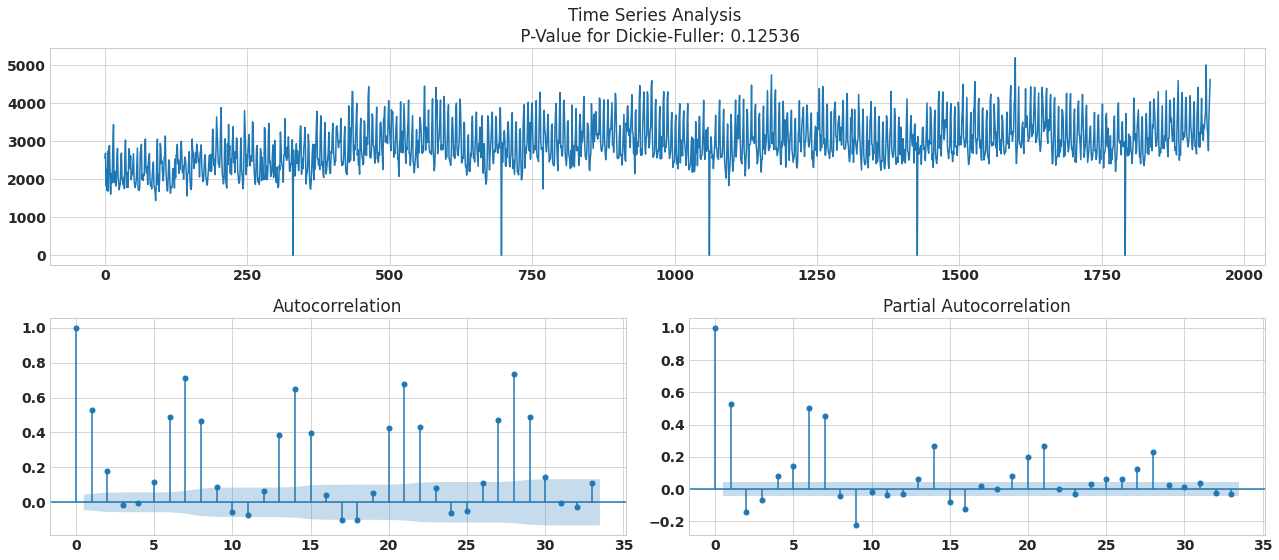

In [56]:
# Time Series Analysis

tsplot(tx1_sales.values)

The sales in the 1st store in Texas show an upward trend and downward spikes at each year as we have seen with the Californian stores before.

The ACF shows that the 1st, 2nd, 5th, 6th and 7th days are correlated as well as the first and last day of each week. The PACF shows  all the first 7 days and the 9th day are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 1st store in Texas appear to have a clear linear positively increasing trend together with seasonal fluctuations.

In [57]:
# Statistics of sales from 2nd store in Texas

df[df['store_id'] == 'TX_2']['sales'].describe()

count    5.918109e+06
mean     1.238511e+00
std      4.411699e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.260000e+02
Name: sales, dtype: float64

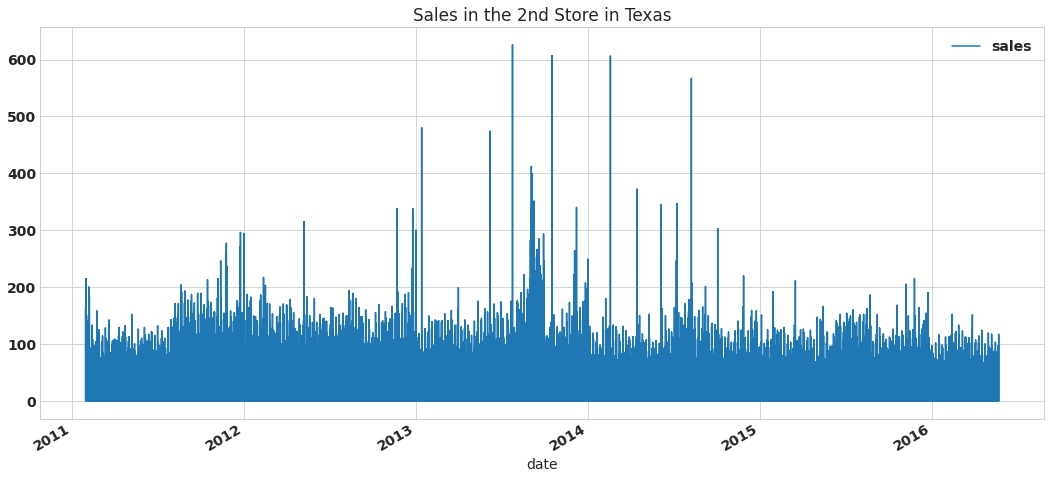

In [84]:
# Plotting sales in the 2nd store in Texas

df.loc[(df.store_id == 'TX_2')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 2nd Store in Texas')
plt.show()

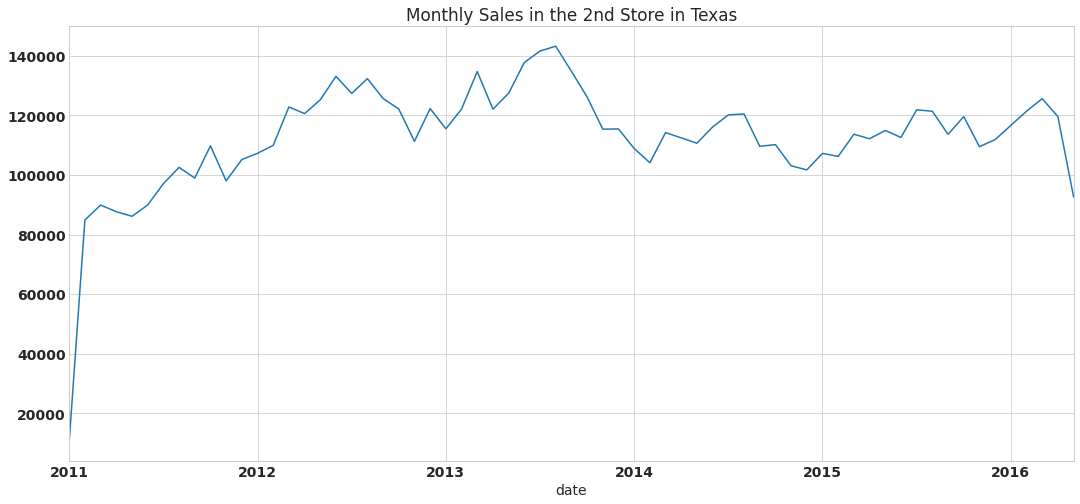

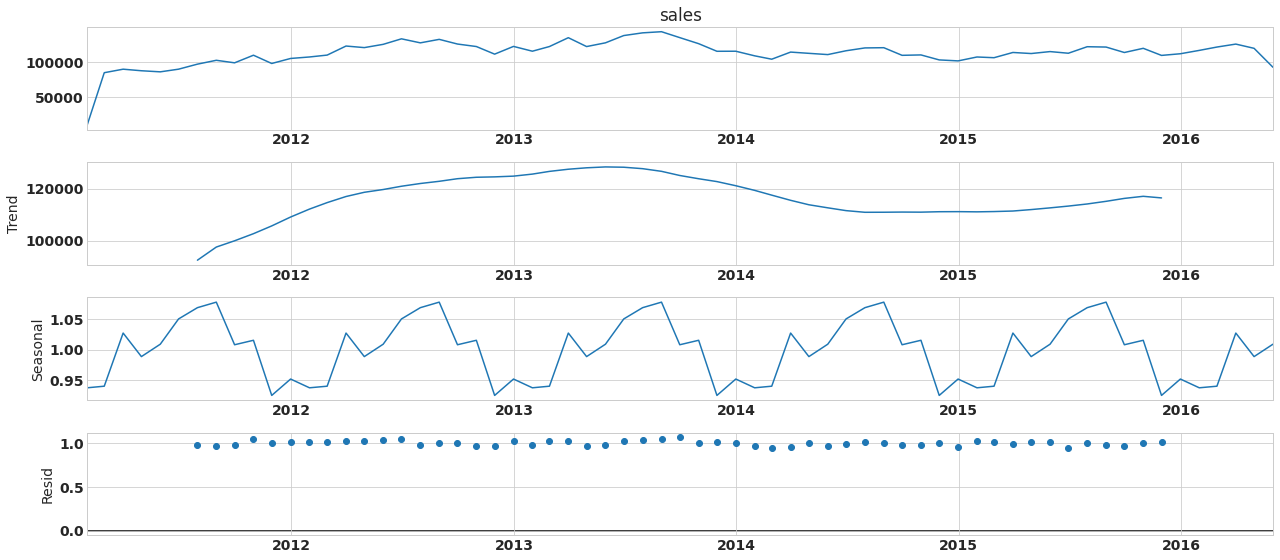

In [58]:
# Monthly Sales and Decomposition of Time Series

tx2_sales = df[df['store_id'] == 'TX_2'].groupby(['date'])['sales'].sum()
tx2_sales_monthly = tx2_sales.resample('M').sum()

fig = tx2_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 2nd Store in Texas')
fig = seasonal_decompose(tx2_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

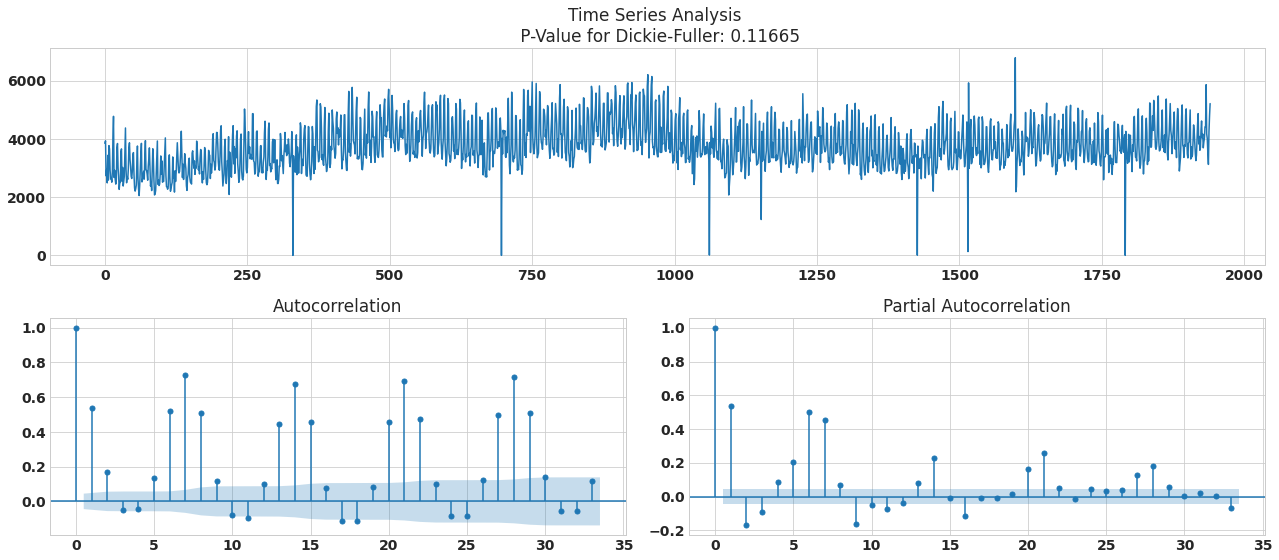

In [59]:
# Time Series Analysis

tsplot(tx2_sales.values)

The sales in the 2nd store in Texas show a fluctuating upward and downward trend together with downward spikes that happen at each year as we have seen with all the other stores before.

The ACF shows that the 1st, 2nd, 5th, 6th, 7th and 8th days are correlated as well as the first and last day of each week. The PACF shows  all the first 9 days are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity.

In [60]:
# Statistics of sales from 3rd store in Texas

df[df['store_id'] == 'TX_3']['sales'].describe()

count    5.918109e+06
mean     1.048636e+00
std      3.794068e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.850000e+02
Name: sales, dtype: float64

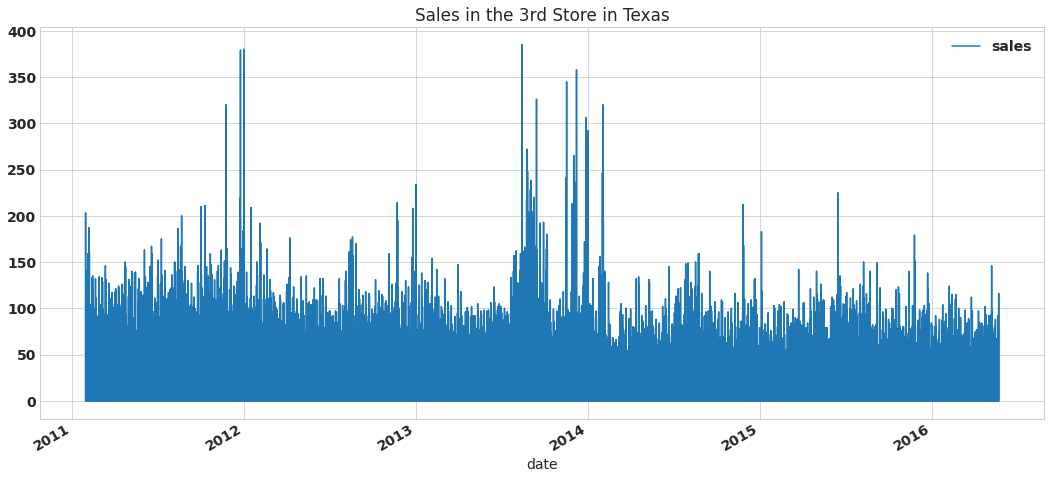

In [65]:
# Plotting sales in the 3rd store in Texas

df.loc[(df.store_id == 'TX_3')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 3rd Store in Texas')
plt.show()

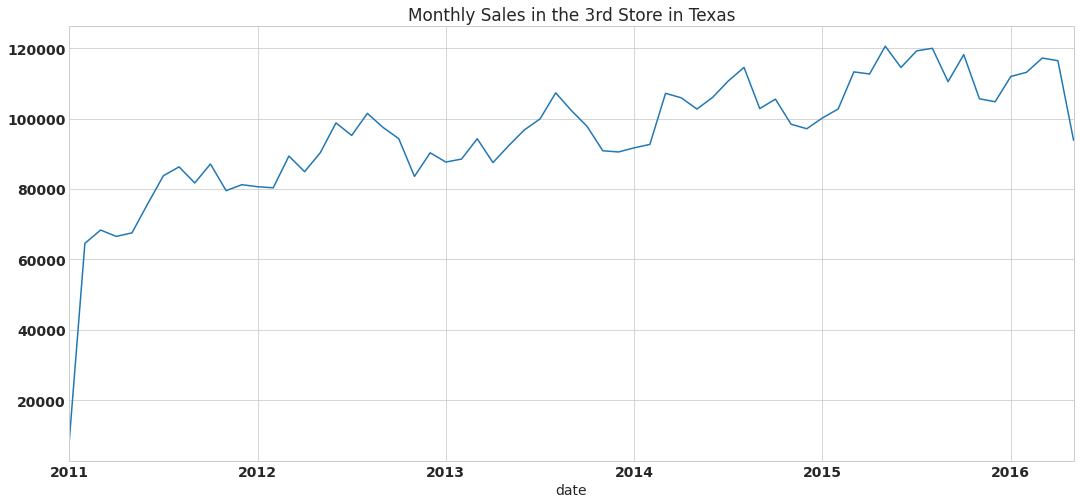

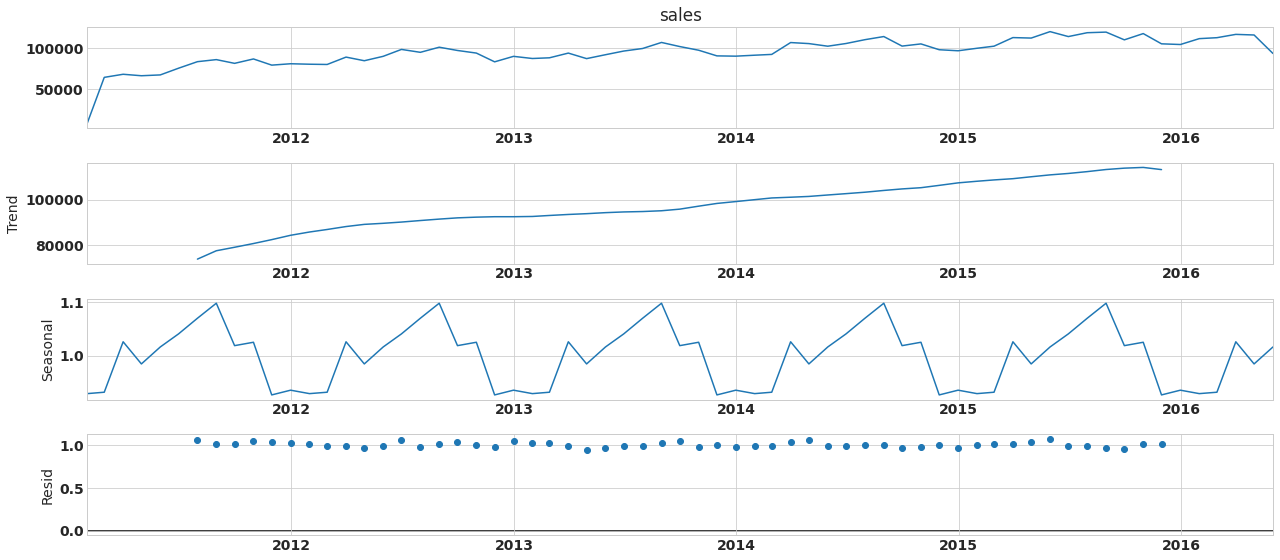

In [61]:
# Monthly Sales and Decomposition of Time Series

tx3_sales = df[df['store_id'] == 'TX_3'].groupby(['date'])['sales'].sum()
tx3_sales_monthly = tx3_sales.resample('M').sum()

fig = tx3_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 3rd Store in Texas')
fig = seasonal_decompose(tx3_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

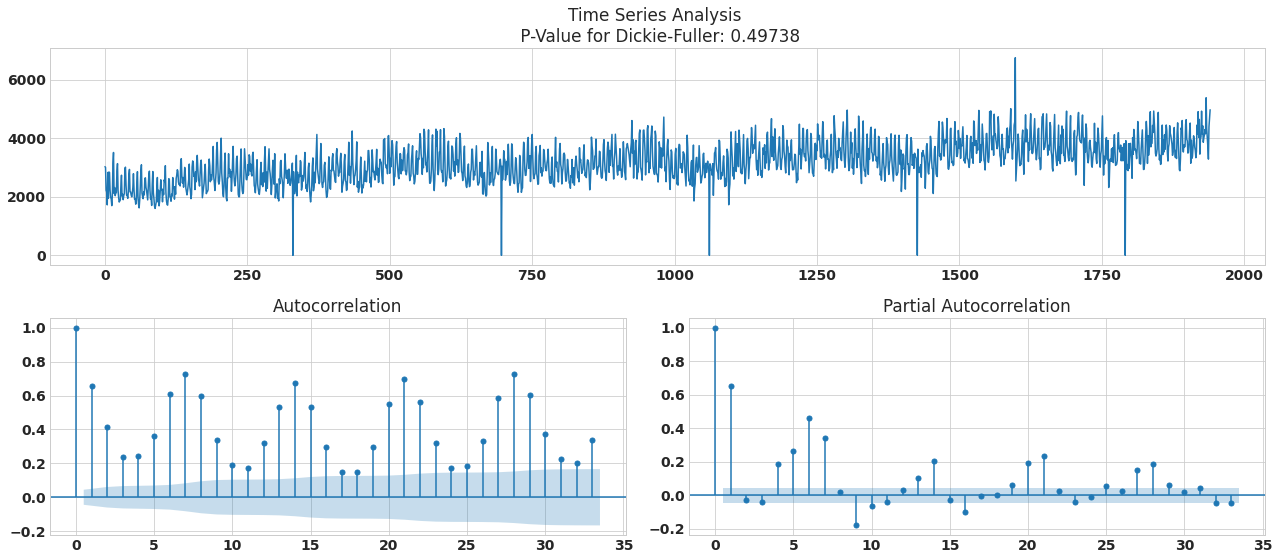

In [62]:
# Time Series Analysis

tsplot(tx3_sales.values)

The sales in the 3rd store in Texas show an upward trend and downward spikes when the store has been closed.

The ACF shows all the past days are correlated. The PACF shows that the 1st, 4th, 5th, 6th and 7th day are, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 3rd store in Texas appear to have a clear linear positively increasing trend together with seasonal fluctuations.

In [63]:
# Statistics of sales from 1st store in Wisconsin

df[df['store_id'] == 'WI_1']['sales'].describe()

count    5.918109e+06
mean     8.890519e-01
std      2.427170e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.240000e+02
Name: sales, dtype: float64

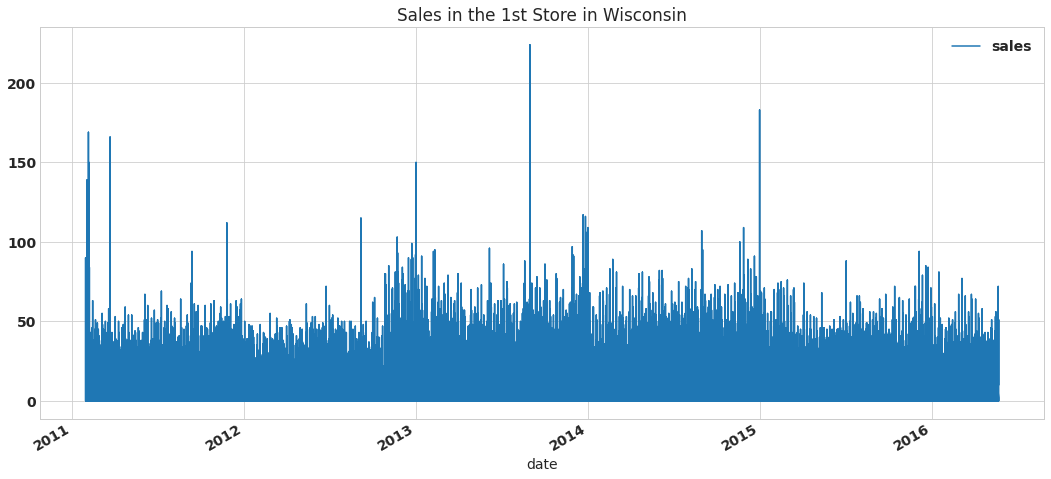

In [66]:
# Plotting sales in the 1st store in Wisconsin

df.loc[(df.store_id == 'WI_1')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 1st Store in Wisconsin')
plt.show()

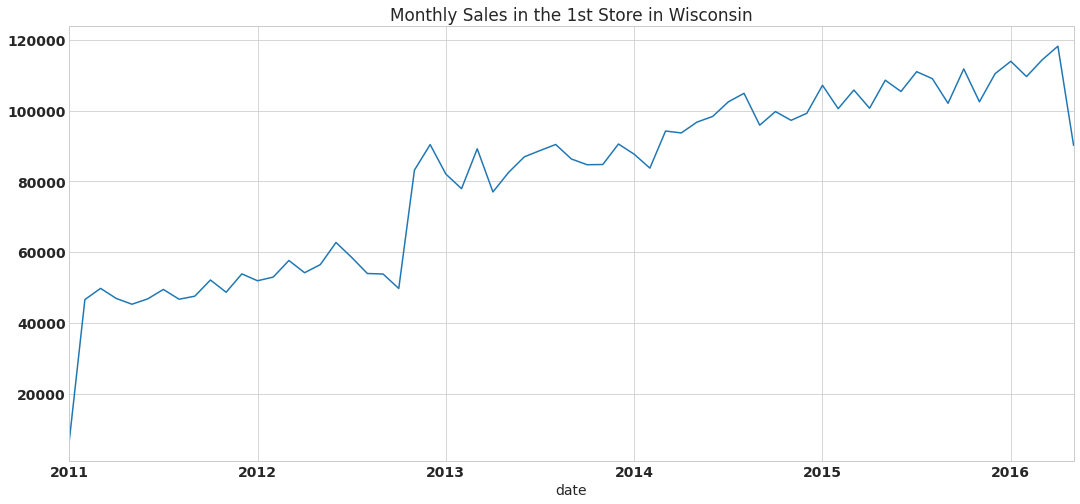

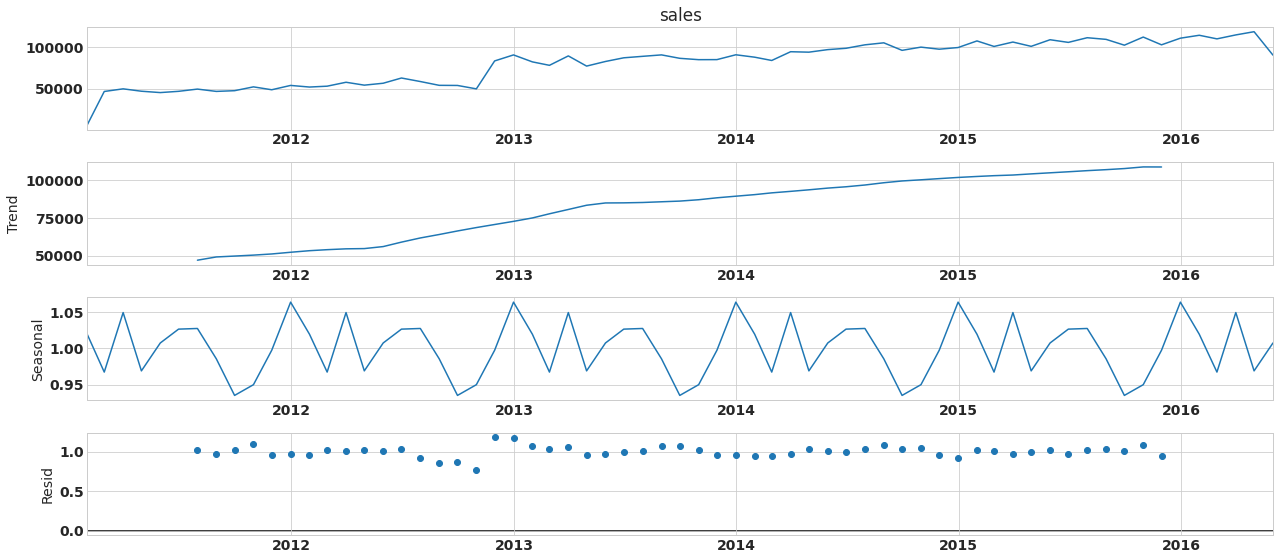

In [67]:
# Monthly Sales and Decomposition of Time Series

wi1_sales = df[df['store_id'] == 'WI_1'].groupby(['date'])['sales'].sum()
wi1_sales_monthly = wi1_sales.resample('M').sum()

fig = wi1_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 1st Store in Wisconsin')
fig = seasonal_decompose(wi1_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

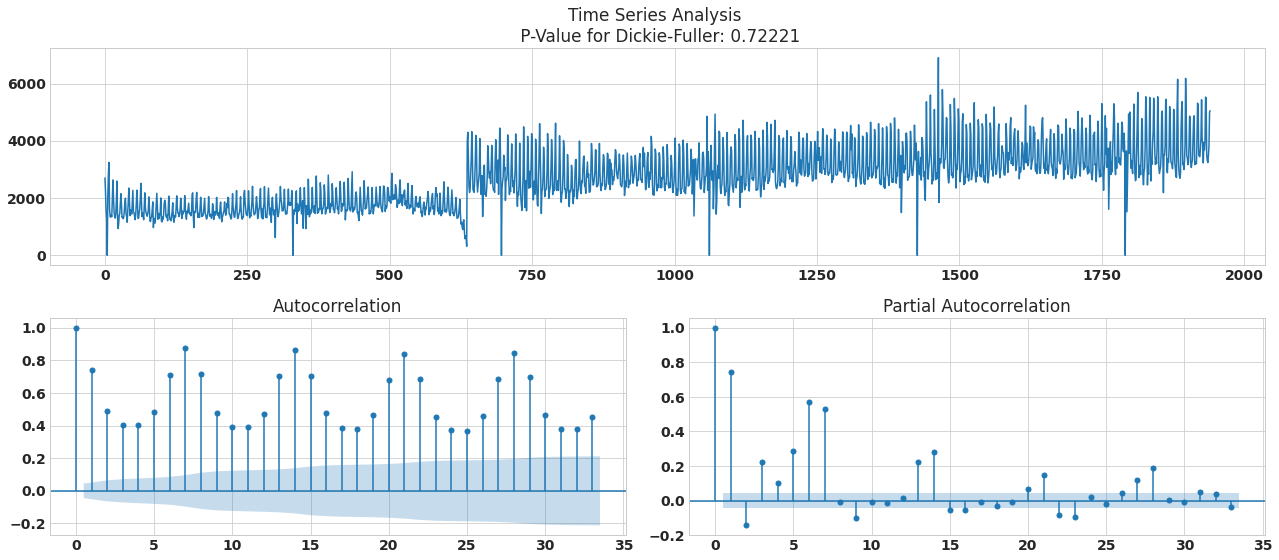

In [68]:
# Time Series Analysis

tsplot(wi1_sales.values)

The sales in the 1st store in Wisconsin show an upward trend and a structural change that happened at the end of 2012 where the store perhaps received an upgrade to help reach bigger sales. The downward spikes happen again at each year as we have seen with the other stores before.

The ACF shows that tall the days are correlated. The PACF shows  all the first 6 days and the 9th day are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 1st store in Wisconsin appear to have a clear linear positively increasing trend together with seasonal fluctuations.

In [69]:
# Statistics of sales from 2nd store in Wisconsin

df[df['store_id'] == 'WI_2']['sales'].describe()

count    5.918109e+06
mean     1.131778e+00
std      3.884559e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.000000e+02
Name: sales, dtype: float64

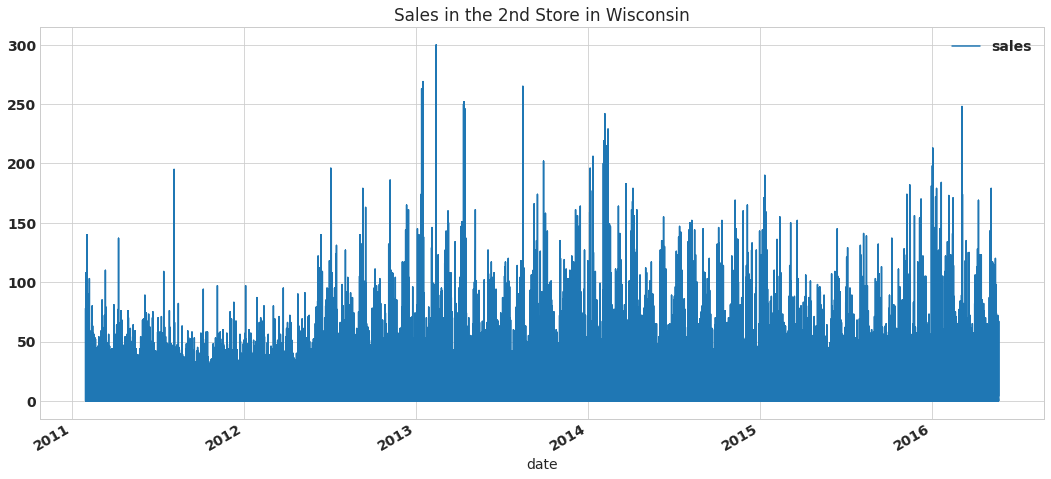

In [70]:
# Plotting sales in the 2nd store in Wisconsin

df.loc[(df.store_id == 'WI_2')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 2nd Store in Wisconsin')
plt.show()

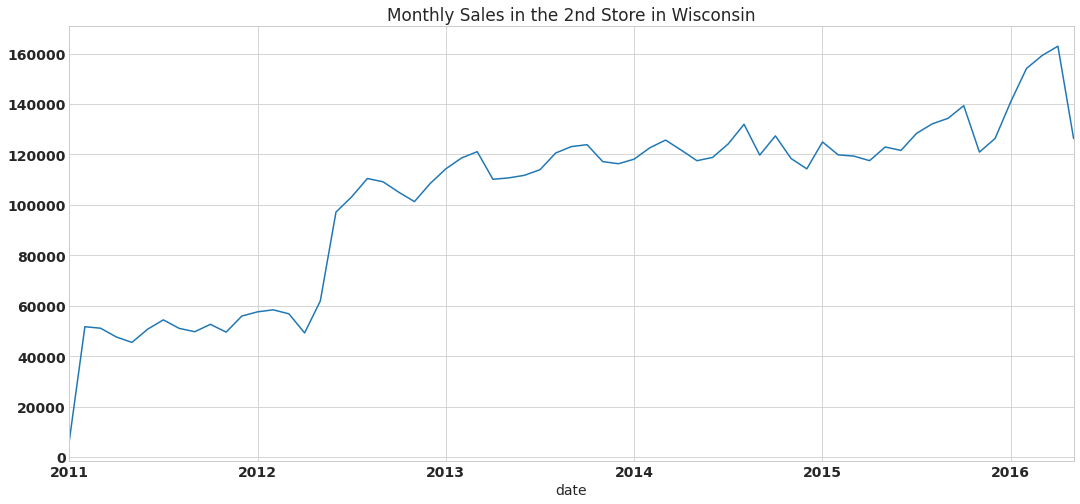

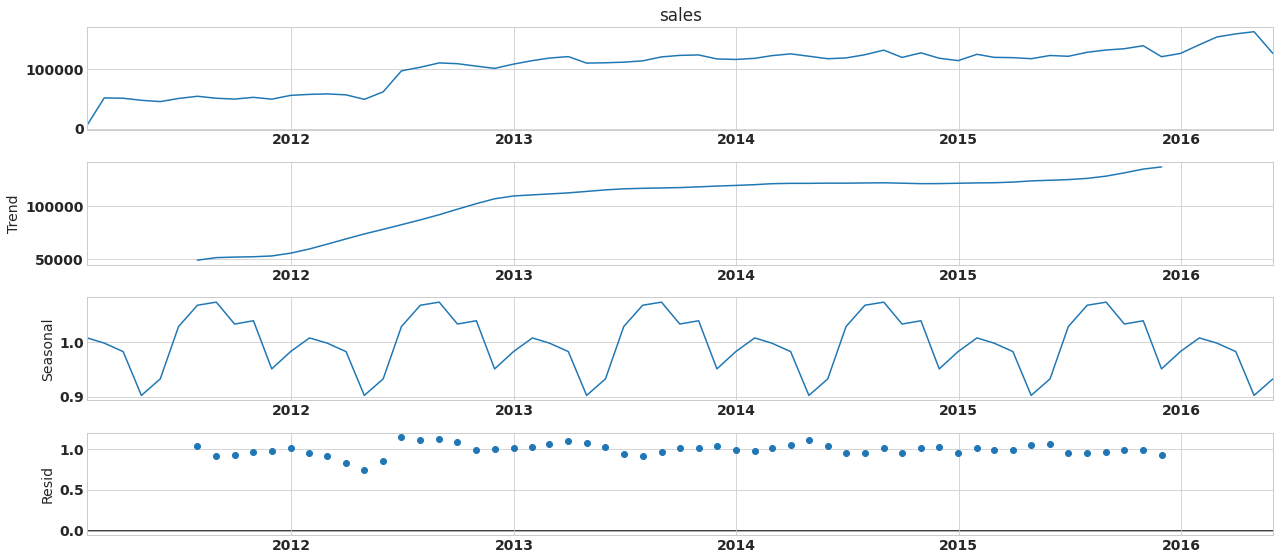

In [71]:
# Monthly Sales and Decomposition of Time Series

wi2_sales = df[df['store_id'] == 'WI_2'].groupby(['date'])['sales'].sum()
wi2_sales_monthly = wi2_sales.resample('M').sum()

fig = wi2_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 2nd Store in Wisconsin')
fig = seasonal_decompose(wi2_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

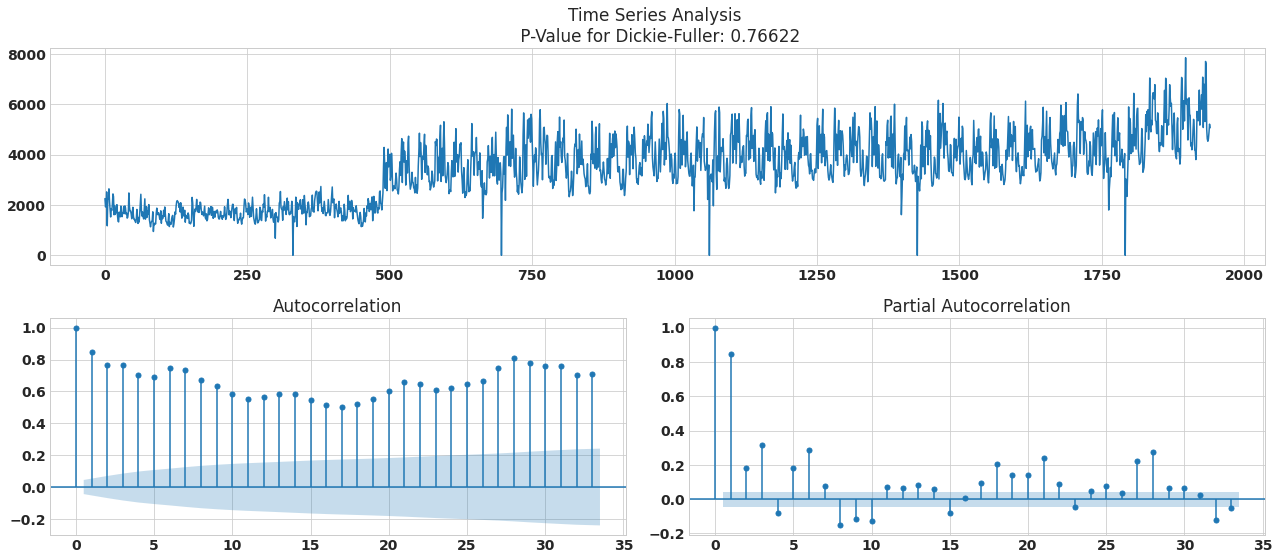

In [72]:
# Time Series Analysis

tsplot(wi2_sales.values)

The sales in the 2nd store in Wisconsin show an upward trend and a structural change at the beginning of 2012. The downward spikes at each year as we have seen with the other stores before.

The ACF shows that all the days are correlated. The PACF shows  all the first 15 days are significantly correlated, as well as the last day of each week and the first day of each week.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity, and conclude that the sales from the 2nd store in Texas appear to have a clear linear positively increasing trend together with seasonal fluctuations.

In [73]:
# Statistics of sales from 3rd store in Wisconsin

df[df['store_id'] == 'WI_3']['sales'].describe()

count    5.918109e+06
mean     1.105515e+00
std      4.061800e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.740000e+02
Name: sales, dtype: float64

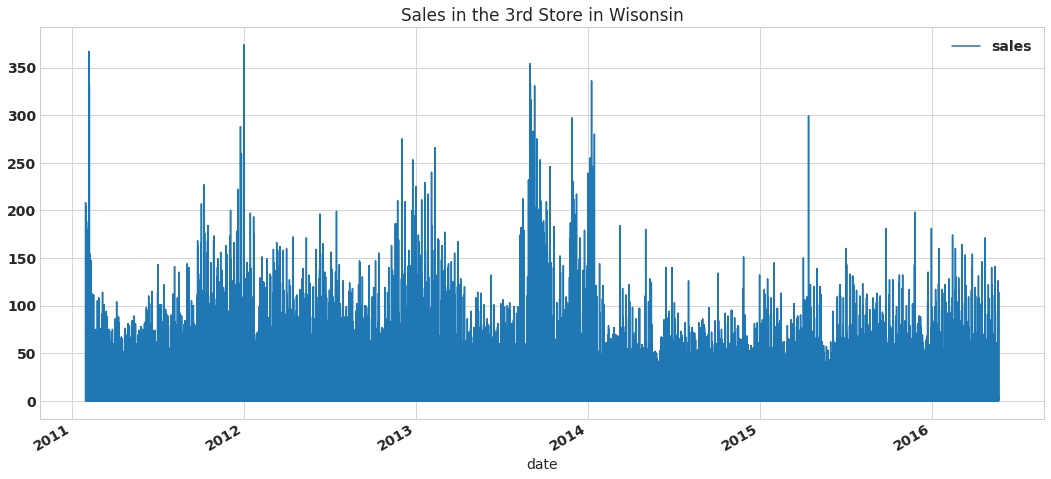

In [74]:
# Plotting sales in the 3rd store in Wisconsin

df.loc[(df.store_id == 'WI_3')][['date', 'sales']].set_index('date').plot()
plt.title('Sales in the 3rd Store in Wisonsin')
plt.show()

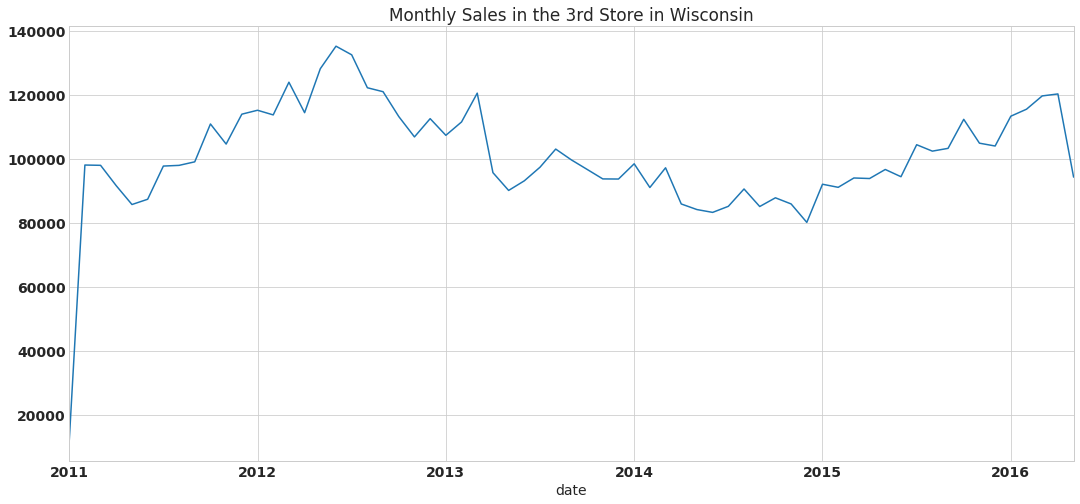

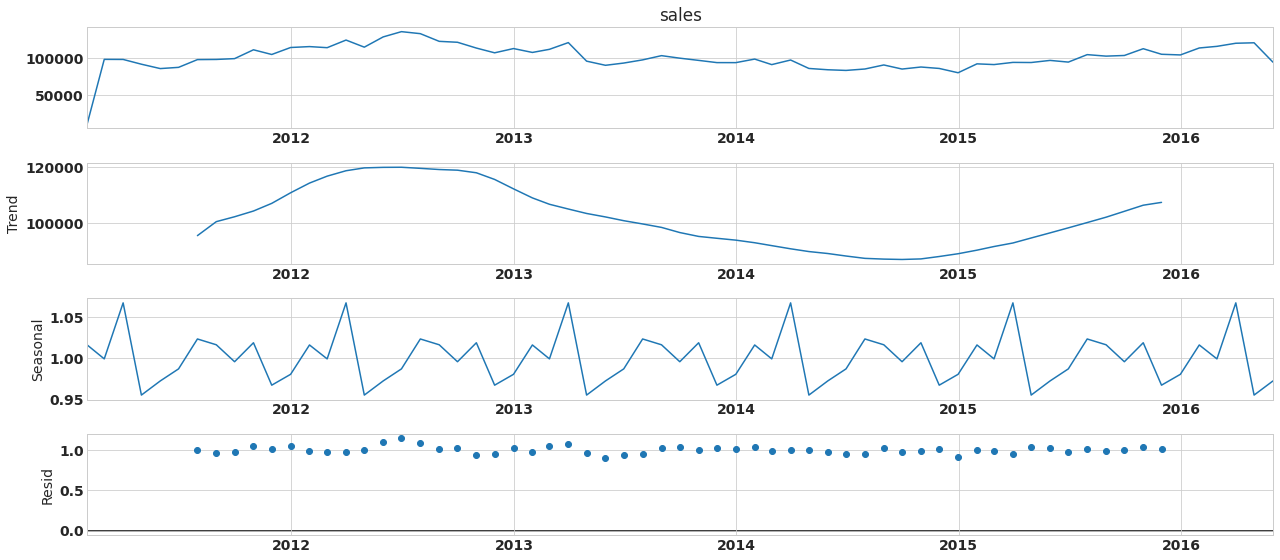

In [75]:
# Monthly Sales and Decomposition of Time Series

wi3_sales = df[df['store_id'] == 'WI_3'].groupby(['date'])['sales'].sum()
wi3_sales_monthly = wi3_sales.resample('M').sum()

fig = wi3_sales_monthly.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Monthly Sales in the 3rd Store in Wisconsin')
fig = seasonal_decompose(wi3_sales_monthly, model='multiplicative', period=12).plot()
plt.show()

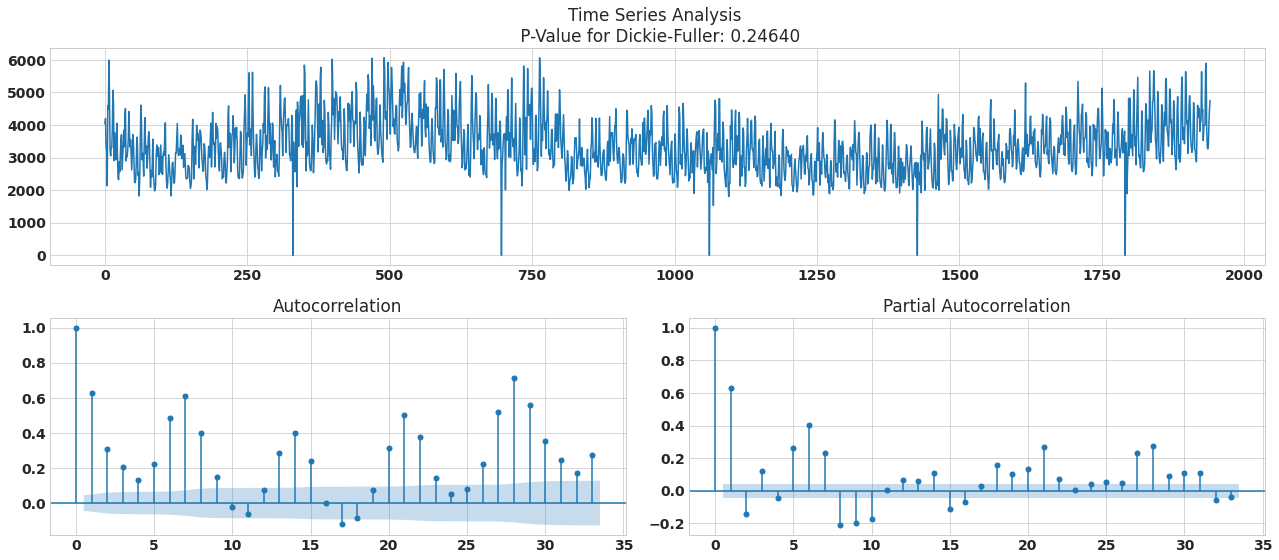

In [76]:
# Time Series Analysis

tsplot(wi3_sales.values)

The sales in the 3rd store in Wisconsin show a fluctuating upwardand downward trend with the downward spikes as before.

The ACF shows that the first 2 weeks are correlated as well as the first and last day of each week. The PACF shows  all the first 7 days and the 9th day are significantly correlated, as well as the last day of each week and the first day of each week. The correlation seems to reach higher levels at the end of the month, especially with the ACF.

The Dickie-Fuller test confirms the results so that we cannot reject the null hypothesis of non-stationarity.

## Correlation

Now that we've covered where the sales have occurred let's have a closer look at the correlation between the different variables.

In [90]:
df.corr()

sales  wm_yr_wk      wday     month      year   snap_CA  \
sales       1.000000  0.034740 -0.028415 -0.000728  0.034142  0.011284   
wm_yr_wk    0.034740  1.000000 -0.002307 -0.040642  0.988750 -0.000752   
wday       -0.028415 -0.002307  1.000000 -0.000923  0.001529 -0.001288   
month      -0.000728 -0.040642 -0.000923  1.000000 -0.170883 -0.004564   
year        0.034142  0.988750  0.001529 -0.170883  1.000000  0.007329   
snap_CA     0.011284 -0.000752 -0.001288 -0.004564  0.007329  1.000000   
snap_TX     0.013194  0.001012  0.001999 -0.004564  0.007329  0.403228   
snap_WI     0.013394  0.001220 -0.004027 -0.004564  0.007329  0.403228   
sell_price -0.150813  0.019526 -0.000034  0.000582  0.019125 -0.000109   
revenues    0.708050 -0.021497 -0.038806 -0.006244 -0.020836  0.014240   

             snap_TX   snap_WI  sell_price  revenues  
sales       0.013194  0.013394   -0.150813  0.708050  
wm_yr_wk    0.001012  0.001220    0.019526 -0.021497  
wday        0.001999 -0.004027   -0.000034 -0.038806  
month      -0.004564 -0.004564    0.000582 -0.006244  
year        0.007329  0.007329    0.019125 -0.020836  
snap_CA     0.403228  0.403228   -0.000109  0.014240  
snap_TX     1.000000  0.552421    0.000005  0.016629  
snap_WI     0.552421  1.000000    0.000011  0.016443  
sell_price  0.000005  0.000011    1.000000  0.086011  
revenues    0.016629  0.016443    0.086011  1.000000

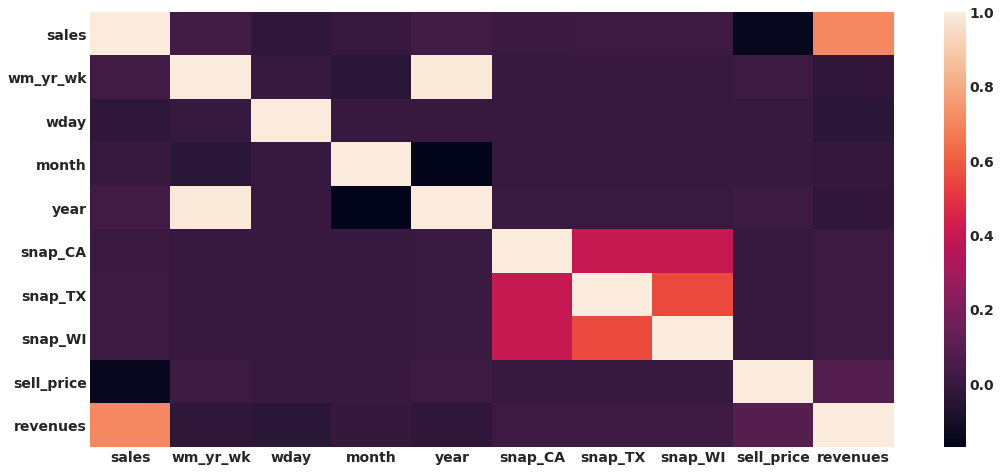

In [91]:
sns.heatmap(df.corr())
plt.show()

We see a strong correlation between the target sales and revenues which is normal, but we can't use the revenues to determine future sales because we would already know how much the revenues are changing in the future so we need to remove the revenues from modeling. The year is also strongly correlated with the variable 'wm_yr_wk', and as we don't need two variables indicating the same thing so we will remove the year from the model.

In [92]:
df = df.drop(columns=['revenues', 'year'], axis=1)

# 4. Feature Engineering

In the beginning we identified 5 different components for Time Series forecasting which consisted of:

- `Autoregressive (AR)` components in the form of lags from past autocorrelation of the target variable. We could see that there was strong autocorrelation from the past days of sales so we will introduce lags of days that will cover the 28 days as inline with the forecasting period. More specifucally, the PACF showed statistically significant autocorrelation for the 9 first days, and for the last and first day of each week so these will be our AR variables. 


- `Moving Average (MA)` components in the form of lags that are calculated from the averages of variables in the past. This is similar to the autoregressive components, but the lag terms are smoothed out by taking the mean of the change during a certain window of days.The ACF showed statistically significant partial autocorrelation for the 9 first days, and for the last and first day of each week , so we will use these as our MA variables.


- `Trend` components, in the form of linear or non-linear trend in product sales. We could see some indications of a linear trend in some of the years, especially while looking closer at the particular stores located in the different States. By comparing the sales to the daily average sales we can compute the trend component for each store separetely. 


- `Seasonal` components, that occur on a certain particular time with a certain frequency. By decompositing the monthly sales we could see a wave-like pattern occurring during the year, and by looking the sales figures at each month, we could notice that most of the sales occur during the 1st quarter of the year. We already have the calendar with all the dates of the sales as well as the special events occurring in the US marked down, but we will also create some additional variables that will capture seasonality with especially highs and lows in occurred sales.


- `Exogenous` variables, that come outside the model. By comparing the daily price information with the prices of different products in the same product category we are able to capture the competition between the different trade marks and companies that set price changes that affect consumer demand.

We will start by creating these components one-by-one and finish off with encoding all the categorical features by mapping them with category codes.

## Relative Prices

The prices are set according to market demand and because the stores are of different sizes and located in different States, they will face a different demand for the products, and hence, should have different prices. This allows us to compare the prices and their changes with relative prices:

    - by comparing the price changes of a product,
    
    - by comparing the prices of a product relative to the different stores, and
    
    - by comparing the prices of similar products in the same store.

In [93]:
# Create relative prices

def relative_prices(df):
    """Creating relative prices from the prices of the products sold in different stores.
    Relative prices are calculated by comparing the same products in other stores,
    differences in prices during time and other similar products in the store.
    """
    
    # Calculate Average price for all stores
    df_mean_store = pd.DataFrame(df.groupby(['item_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_store.columns = ['item_sells_price_avg']
    df_mean_store.reset_index(inplace = True)

    # Combine with calendar
    prices_new = pd.merge(df, df_mean_store, on=['item_id', 'wm_yr_wk'], how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(), axis=1, inplace=True)

    # Price difference with the same products in other stores
    prices_new['delta_price_all_rel'] = (prices_new['sell_price'] - 
                                         prices_new['item_sells_price_avg'])/prices_new['item_sells_price_avg']

    # Price difference with last week
    prices_new['item_store'] = prices_new['item_id'].astype(str) + '_' + prices_new['store_id'].astype(str)
    prices_new['item_store_change'] = prices_new["item_store"].shift() != prices_new["item_store"]
    # Price difference week n - week n-1
    prices_new['delta_price_weekn-1'] = (prices_new['sell_price']-
                                         prices_new['sell_price'].shift(1)).fillna(0)/prices_new['sell_price'].shift(1)
    prices_new['delta_price_weekn-1'] = prices_new['delta_price_weekn-1'].fillna(0) * (prices_new['item_store_change']==0)

    # Average price of the department by store
    prices_new['dept_id'] = prices_new.item_id.str[:-4]
    df_mean_cat = pd.DataFrame(prices_new.groupby(['dept_id', 'store_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_cat.columns = ['dept_sells_price_avg']
    df_mean_cat.reset_index(inplace = True)
    # Combine with price dataset
    prices_new = pd.merge(prices_new, df_mean_cat, on=['dept_id', 'store_id', 'wm_yr_wk']
                          , how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # Compare the product price with the average of the department (category)
    prices_new['delta_price_cat_rel'] = (prices_new['sell_price'] - 
                                         prices_new['dept_sells_price_avg'])/prices_new['dept_sells_price_avg']                                               

    # Drop columns
    prices_new.drop(['item_sells_price_avg', 'item_store_change', 'item_store_change', 'item_store',
                    'dept_sells_price_avg'], axis = 1, inplace = True)
    
    return prices_new

df = relative_prices(df)

df.shape

(59181090, 24)

## Autoregressive Components

Based on the PACF graph, we will create lag terms of 1 to 9 days, and include the last day and first day of each week. This way we will have 14 autoregressive variables.

In [94]:
# Lag terms for 1, 2, 3, 7, 14, 21 and 28 days

lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 20, 21, 28]
for lag in lags:
    df['sales_lag_'+str(lag)] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
        as_index = False)['sales'].shift(lag).astype(np.float16)

df.shape

(59181090, 38)

## Moving Average Components

We will create different components based on averages. First,  we will use averages to describe and differentiate the charasterics of different products, states, stores, categories and departments. Then, we will create additional group categories by combining two or three of these variables together that could give us some additional insight related to the sales of the products.

<h3> Averages </h3>

In [95]:
# Total Average Sales by item, state, store, cat and dept

df['item_sales_avg'] = df.groupby('item_id')['sales'].transform('mean').astype(np.float16)
df['state_sales_avg'] = df.groupby('state_id')['sales'].transform('mean').astype(np.float16)
df['store_sales_avg'] = df.groupby('store_id')['sales'].transform('mean').astype(np.float16)
df['cat_sales_avg'] = df.groupby('cat_id')['sales'].transform('mean').astype(np.float16)
df['dept_sales_avg'] = df.groupby('dept_id')['sales'].transform('mean').astype(np.float16)

# Sales average by group

df['cat_dept_sales_avg'] = df.groupby(['cat_id','dept_id'])['sales'].transform('mean').astype(np.float16)
df['store_item_sales_avg'] = df.groupby(['store_id','item_id'])['sales'].transform('mean').astype(np.float16)
df['cat_item_sales_avg'] = df.groupby(['cat_id','item_id'])['sales'].transform('mean').astype(np.float16)
df['dept_item_sales_avg'] = df.groupby(['dept_id','item_id'])['sales'].transform('mean').astype(np.float16)
df['state_store_sales_avg'] = df.groupby(['state_id','store_id'])['sales'].transform('mean').astype(np.float16)
df['state_store_cat_sales_avg'] = df.groupby(['state_id','store_id','cat_id'])['sales'].transform('mean').astype(np.float16)
df['store_cat_dept_sales_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sales'].transform('mean').astype(np.float16)

df.shape

(59181090, 50)

<h3> Rolling Averages</h3>

Next, we will calculate the moving averages based on sales and also calculate the average from the lag terms up to 28 days. We include the amount of lag suggested by the ACF plots.

In [96]:
# Rolling Average for the last n days

for days in [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 21, 28]:
    df['rolling_sales_mean_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(
    lambda x: x.rolling(window=days).mean()).astype(np.float16)

# Rolling Average on actual lag

for window, lag in zip([7, 7, 28, 28], [7, 28, 7, 28]):
    df['rolling_lag_{}_win_{}'.format(window, lag)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales_lag_{}'.format(lag)].transform(
    lambda x: x.rolling(window=window).mean()).astype(np.float16)

df.shape

(59181090, 66)

## Trend Components

When we analyzed the sales in the different stores previously, we noticed that there were differences in the trends when looking at the state, store and department levels, but also with different categories and products, so we need to take this into account.

First, we will calculate the trend from the daily average and the average of sold products regarding all stores in all states, and then the item selling trend from the daily average and the average of sold products regarding all categories in all departments. This way we will have two trend variables.

In [97]:
# Selling trends

# Daily Average
df['daily_avg_sales'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sales'].transform('mean').astype(np.float16)

# Total Average 
df['avg_sales'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform('mean').astype(np.float16)

# Selling Trend
df['selling_trend'] = (df['daily_avg_sales'] - df['avg_sales']).astype(np.float16)

# Daily Average 
df['item_daily_avg_sales'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'd'])['sales'].transform('mean').astype(np.float16)

# Total Average 
df['item_avg_sales'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id'])['sales'].transform('mean').astype(np.float16)

# Selling Trend
df['item_selling_trend'] = (df['item_daily_avg_sales'] - df['item_avg_sales']).astype(np.float16)

# Drop Columns 
df.drop(['daily_avg_sales','avg_sales','item_daily_avg_sales','item_avg_sales'],axis=1,inplace=True)

df.shape

(59181090, 68)

## Seasonal Components

When we had a closer look at some particular products that had been sold during the 5.5 year period, we noticed that most of the times the products where not being sold at all, but overall there was a steady demand for products throughout the years with the occasional high spikes occurring on a particular day or period.

These events which occur on a certain particular time with a certain frequency can be modeled by looking at the days when a high or low amount of products were sold. As the sales are in count data form, we can look at the rolling maximimum and minimum value during a certain period of days. We will include the lag terms so that we try to catch all the days of the week and then add 2, 3 and 4 weeks inorder to catch seasonal patterns in the sales. In total we will have 24 seasonal variables added to the event variables we already had before.

In [98]:
# Rolling Maximum for the last n days

for days in [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 21, 28]:
    df['rolling_sales_max_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(
    lambda x: x.rolling(window=days).max()).astype(np.float16)

# Rolling Minimum for the last n days

for days in [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 21, 28]:
    df['rolling_sales_min_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(
    lambda x: x.rolling(window=days).min()).astype(np.float16)

df.shape

(59181090, 92)

## Mapping Categories

In [99]:
# Mapping categories

# dtypes to categories
df.store_id = df.store_id.astype('category')
df.item_id = df.item_id.astype('category')
df.cat_id = df.cat_id.astype('category')
df.state_id = df.state_id.astype('category')
df.id = df.id.astype('category')
df.dept_id = df.dept_id.astype('category')

# dictionary of categories
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

# Save to DataFrame
LIST_SAVE = [d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
for list_save, list_name in zip(LIST_SAVE, LIST_NAME):
    pickle.dump(list_save, open('data/sales_forecasting/{}.p'.format(list_name), "wb"))  

# Remove d_ and transform to int (dates)
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()

# Transform categorical data to codes
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
# Drop Dates
df.drop('date',axis=1,inplace=True)

In [101]:
# Saving dataset

df.to_pickle('data/sales_forecasting/data_features_improved.pkl')
df.shape

(59181090, 91)

In [102]:
del df

# 5. Modeling


## The Model

We will be using the Light Gradient Boosting Machine (LGBM Regressor) which is a decision tree based emsemble technique, where the novelty not only lies, in using bagging and boosting, but also in the histogram-way of bucketing the values, which leads to less memory usage, and makes the model faster to train compared to other similar techniques. 

Bagging, enables the model to fit many models to bootstrapped samples of the data and average over the models. In addition, the model will sample the predictor variables when splitting the trees in similar fashion as with the Random Forest algorithm. Boosting, on the other hand, enables to fit a sequence of models by giving more weight to the records with large residuals for each successive rounds. This means that each successive model seeks to minimize the error, or in other words, attempts to fix the error by giving more weight to the biggest mistakes that were made by the previous model.

In order to succeed well, several hyperparameters need to be set before fitting the model. These adjust the structure and the accuracy of the model, and control for possible overfitting issues.

### Hyperparameters 


<h4 align='center'> Model Structure </h4>


        - `numleaves`:               Controls the amount of leaves at the node of the tree where the decision happens. 
    
        - `max_depth`:               Controls the depthness or the complexity in the decision-making process. 
        
<h4 align='center'> Model Accuracy </h4>


        - `n_estimators`:            Controls the amount of trees being used.
    
        - `learning_rate`:           Step size of the gradient descent that helps to reach the optimum values.
    
        - `objective`:               Poisson regression.
 
<h4 align='center'> Overfitting </h4>


        - `reg_lamda`:               Ridge regularization (L2) adds a penalty term to parameters of the cost function. 
    
        - `min_child_weight`:        The minimum amount of training samples at each node.
    
        - `subsample`:               Fraction of the training samples that are randomly selected to train each tree.
    
        - `colsample_bytree`:        Fraction of the features that are randomly selected to train each tree.
    
        - `early_stopping_rounds`:   Stop training when the model is not improving anymore.

### Training the Model

We will train one model for each store, and the variables will be trained in different steps, where we will be adding a new component at each step, and then see which of the components were important in the decision-making of the forecast. 

For the variables, we will start from the 56th day, since that's when the lag terms have started to calculate values from the previous events. This will help to speed-up the training and hopefully reach a better accuracy with better quality data.

For the training, we will use the trees to act as Random Forests so that each tree will select a random sample of the training samples and a random subset of the features for each training session. Then, with the help of boosting, each tree will build upon the forecast of the previous tree and the model will stop training once the forecast haven't been improving for some time. 

### Evaluating the Model

We will be evaluating the different steps that add new features at each step based on the fifferent components that make the forecast of time series possible. The metric for calculating the error during training will be the Root Mean Squared Error (RMSE) which is the root of the average of squared difference between the actual and predicted values.

$$ {RMSE} = \sqrt{\frac{1}{n}\sum_{t=1}^{n} (y_t - \hat{y}_t)^2} $$

There are a number of ways to calculate the error regarding the forecast, but the RMSE has a tendance to put a larger weight on the outliers of the samples in order to progress towards the mean, and thus, should help the model to deal with the high-spikes that were particularly seen in the graphs of the store sales earlier.

After training the model we will compute the errors with the Mean Absolute Error (MAE) which is the mean absolute difference between the actual and predicted values.

$$ {MAE} = {\frac{1}{n}\sum_{t=1}^{n} |y_t - \hat{y}_t|} $$

Finally, LGBM - being a tree-based model -, enables us to also see which of the features were more important than others at each step when the trees made their decisions, so we will be analyzing all the results, before the fine-tuning of the best model.

## Preparing the Model for Training

In [4]:
# Importing processed dataset

data = pd.read_pickle('data/sales_forecasting/data_features_improved.pkl')

In [5]:
# Starting from day 56 to take into account the lag terms

data = data[data['d'] >= 56]

In [6]:
# Initializing training sequence

# Dictionary of id categories
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
dict_data = {}
for list_name in LIST_NAME:
    dict_temp = pickle.load(open('data/sales_forecasting/{}.p'.format(list_name), "rb"))
    dict_data[list_name] = dict_temp
    del dict_temp

# Initial Features
INIT = list(data.columns[0:20])

# Auto-Regressive Components
AR = list(data.columns[23:37])

# Moving-Average Components
MA = list(data.columns[37:65])

# Trend Components
TREND = list(data.columns[65:67])

# Seasonal Components
SEASONAL = list(data.columns[67:91])

# Relative Prices
RELATIVE_PRICES = list(data.columns[20:23])

# Dictionary of features
dict_features = {
    'STEP_1': INIT,
    'STEP_2': INIT+AR,
    'STEP_3': INIT+AR+MA,
    'STEP_4': INIT+AR+MA+TREND,
    'STEP_5': INIT+AR+MA+TREND+SEASONAL,
    'STEP_6': INIT+AR+MA+TREND+SEASONAL+RELATIVE_PRICES,
}

# List of step names
LIST_STEPS = ['STEP_1', 'STEP_2', 'STEP_3', 'STEP_4', 'STEP_5', 'STEP_6']

# List of sequence names
SEQUENCE = ['INIT', 'INIT + AR', 
                  'INIT + AR + MA',
                  'INIT + AR + MA + TREND',
                  'INIT + AR + MA + TREND + SEASONAL',
                  'INIT + AR + MA + TREND + SEASONAL + RELATIVE PRICES']

# Dictionary of sequences
dict_sequence = dict(zip(LIST_STEPS, SEQUENCE))

## Training the Model

In [7]:
# Training model for each store individually

# Store names and ids
stores = data.store_id.unique()
d_store_id = dict_data['d_store_id']

# Dictionary for errors
dict_error_valid = {} 


for step in LIST_STEPS: # Loop with different steps

    print('SALES FORECAST: {}'.format(dict_sequence[step]))
    print('=' * 67)
    
    # Folder to save
    FOLDER_MODEL = 'data/sales_forecasting/{}/'.format(step)
    Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)
    
    COLS_SCOPE = dict_features[step] # Filter to select sequence for step
    data_scope = data[COLS_SCOPE].copy() # Select data with filter

    # Validation set for all stores
    valid = data_scope[(data_scope['d']>=1914) & (data_scope['d']<1942)][['id','d','sales']]

    # Target values
    valid_set = valid['sales']

    # Dataframe for predictions
    df_validpred = pd.DataFrame()

    for store in stores: # Looping the model by training for each store separately

        df = data_scope[data_scope['store_id']==store] # Dataframe for each store

        X_train, y_train = df[df['d']<1914].drop('sales',axis=1), df[df['d']<1914]['sales'] # All except the last 28 days

        # Validation for 28 days
        X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sales',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sales']
    
        
        # Hyperparameters 
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.08,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=100,
            min_child_weight=300,
            objective='poisson',
            reg_lambda=0.1
        )


        # Training with validation set and early stopping
        model.fit(X_train, y_train, 
                  eval_set = [(X_train,y_train),(X_valid,y_valid)], 
                  eval_metric = 'rmse', 
                  verbose = 0, 
                  early_stopping_rounds = 20)

        # Validation prediction
        valid_pred = model.predict(X_valid)

        # DataFrame for all predictions
        df_valid = pd.DataFrame({
            'validation':valid_set[X_valid.index],
            'valid_prediction':valid_pred,
            'store': d_store_id[store]
        })
        df_valid['valid_error'] = df_valid['validation'] - df_valid['valid_prediction']
        
        df_validpred = pd.concat([df_validpred, df_valid])

        # Save the model
        filename = FOLDER_MODEL + 'LGBM_model_' + str(d_store_id[store])+'.pkl'
        joblib.dump(model, filename)

        del model, X_train, y_train, X_valid, y_valid

    # Save prediction for all stores
    df_validpred.to_csv(FOLDER_MODEL + 'forecast.csv')

    # Validation RMSE
    valid_rmse = np.sqrt(np.mean((df_validpred.validation.values - df_validpred.valid_prediction.values) ** 2))/np.mean(df_validpred.validation.values)
    
    # Add RMSE in a Dictionary
    dict_error_valid[step] = valid_rmse
    
    print("VALID RMSE = %0.5f " % valid_rmse)
    print("-----" * 8)

# DataFrame for RMSE
df_error = pd.DataFrame({
    'STEP': LIST_STEPS,
    'SEQUENCE': [dict_sequence[step] for step in LIST_STEPS],
    'VALID_RMSE': [dict_error_valid[step] for step in LIST_STEPS]
    })

SALES FORECAST: INIT
VALID RMSE = 1.67229 
----------------------------------------
SALES FORECAST: INIT + AR
VALID RMSE = 1.37684 
----------------------------------------
SALES FORECAST: INIT + AR + MA
VALID RMSE = 0.09078 
----------------------------------------
SALES FORECAST: INIT + AR + MA + TREND
VALID RMSE = 0.06604 
----------------------------------------
SALES FORECAST: INIT + AR + MA + TREND + SEASONAL
VALID RMSE = 0.01936 
----------------------------------------
SALES FORECAST: INIT + AR + MA + TREND + SEASONAL + RELATIVE PRICES
VALID RMSE = 0.01915 
----------------------------------------


## Evaluating the Model

To see how the model performed, we will plot the error rate with the forecast and see how well the model managed to forecast the sales for all the stores during the 28 day period. We will start by first plotting the RMSE from the different steps, and then look at the actual forecast in details by analyzing the errors at each store separately. Finally, at the end we will see which features contributed to the decision-making the most.

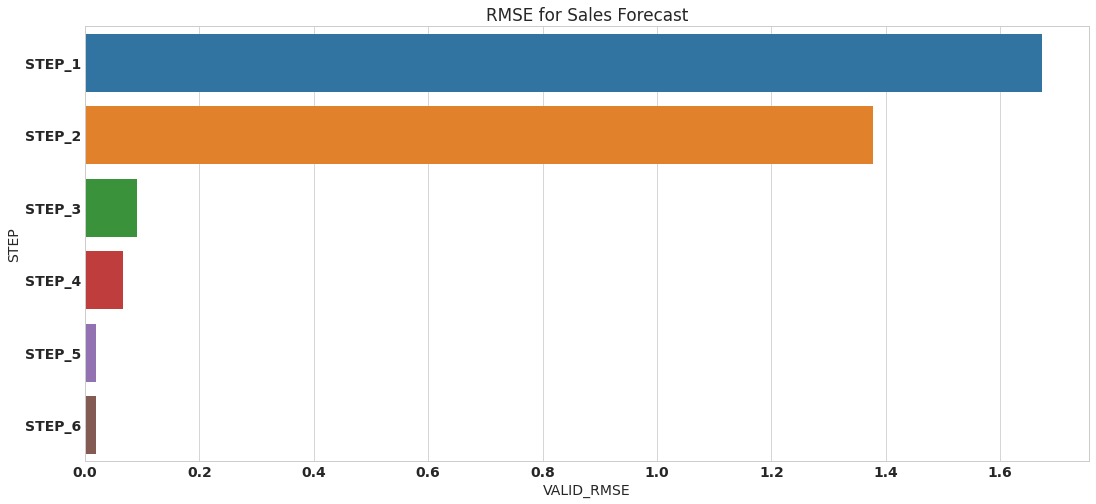

In [8]:
# Plotting results

sns.barplot(data=df_error, x='VALID_RMSE', y='STEP')
plt.title('RMSE for Sales Forecast')
plt.show()

### Sales Forecast

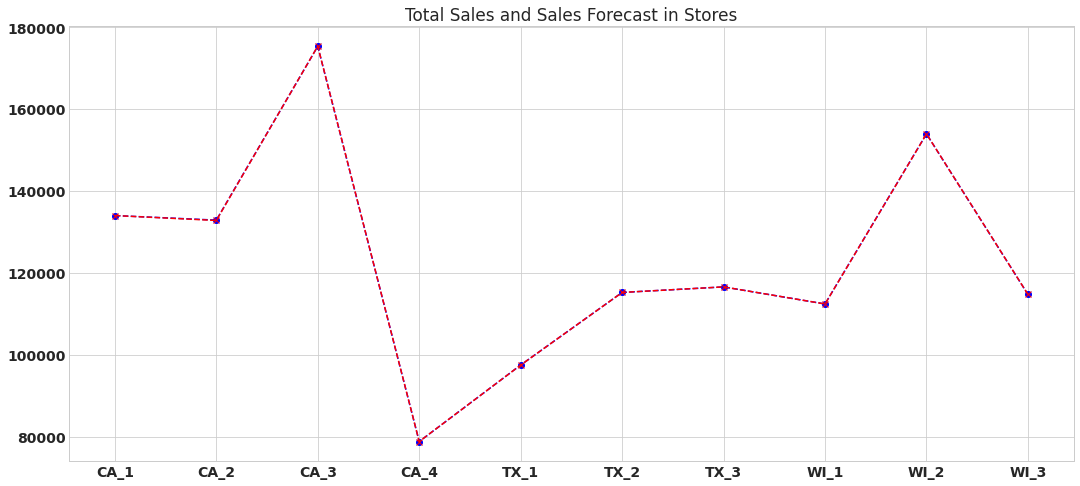

Total Sales in Stores    : 1231764
Total Sales Predictions  : 1231791.0
Total Sales Error        : -27.0


In [267]:
# Plotting forecast for sales total in each store

total_store_sales = df_validpred.groupby(['store'])['validation'].sum()
predicted_store_sales = df_validpred.groupby(['store'])['valid_prediction'].sum()

plt.plot(total_store_sales, marker = 'o', linestyle= '--', color='blue')
plt.plot(predicted_store_sales, marker = 'x', linestyle = '--', color='red')
plt.title('Total Sales and Sales Forecast in Stores')
plt.show()
print('Total Sales in Stores    : {}'.format(df_validpred['validation'].sum()))
print('Total Sales Predictions  : {}'.format(df_validpred['valid_prediction'].round().sum()))
print('Total Sales Error        : {}'.format(df_validpred['valid_error'].round().sum()))

The model seemed to do quite a good job in forecasting the future sales that predicted only 27 sales wrong on average from the actual total of 1,231,764 sales in all of the stores.

### Validation Error

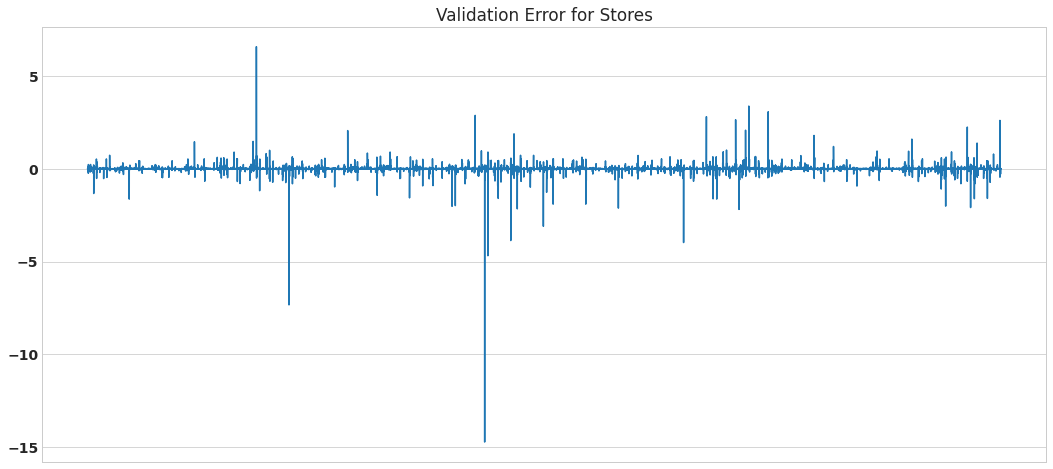

In [273]:
# Plotting validation error

df_validpred['valid_error'].plot()
plt.title('Validation Error for Stores')
plt.xticks([])
plt.show()

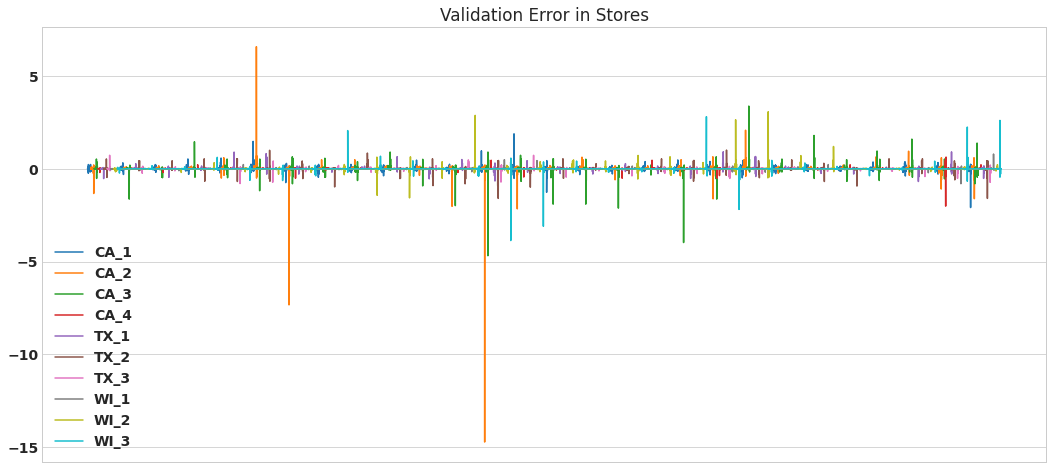

In [272]:
# Validation error by store

df_validpred.groupby('store')['valid_error'].plot(legend=True)
plt.title('Validation Error in Stores')
plt.xticks([])
plt.show()

A closer look at the validation error in the stores shows that the three biggest spikes in errors occurred with the 2nd store in California where the model predicted for two days a bigger amount of sales that actually occurred and for one day less sales that what occurred. Otherwise, the error rate seem to follow quite closely the mean of zero. Let's now have a closer look at each store separately.

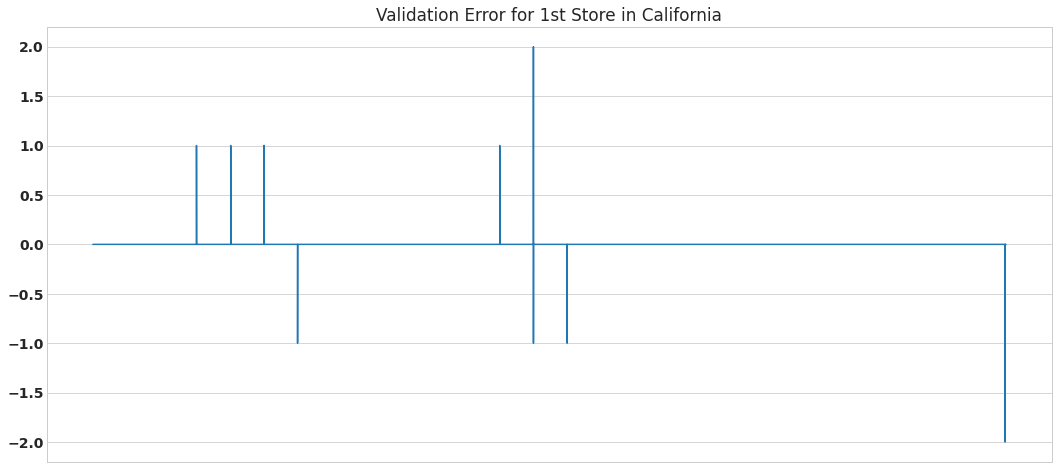

Total Sales       :   134032
Total Prediction  :   134030.0
Total Error       :  2.0


In [277]:
# Plotting validation error for 1st store in California

plt.title('Validation Error for 1st Store in California')
df_validpred[df_validpred['store'] == 'CA_1']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_validpred[df_validpred['store'] == 'CA_1']['validation'].sum()))
print('Total Prediction  :   {}'.format(df_validpred[df_validpred['store'] == 'CA_1']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'CA_1']['valid_error'].round().sum()))

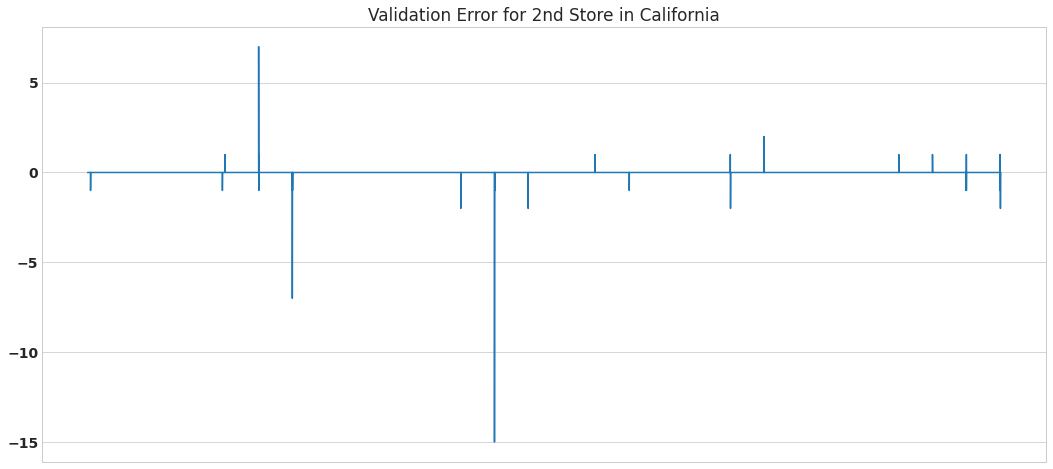

Total Sales       :  132920
Total Prediction  :  132940.0
Total Error       :  -20.0


In [359]:
# Plotting validation error for 2nd store in California

plt.title('Validation Error for 2nd Store in California')
df_validpred[df_validpred['store'] == 'CA_2']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :  {}'.format(df_validpred[df_validpred['store'] == 'CA_2']['validation'].sum()))
print('Total Prediction  :  {}'.format(df_validpred[df_validpred['store'] == 'CA_2']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'CA_2']['valid_error'].round().sum()))

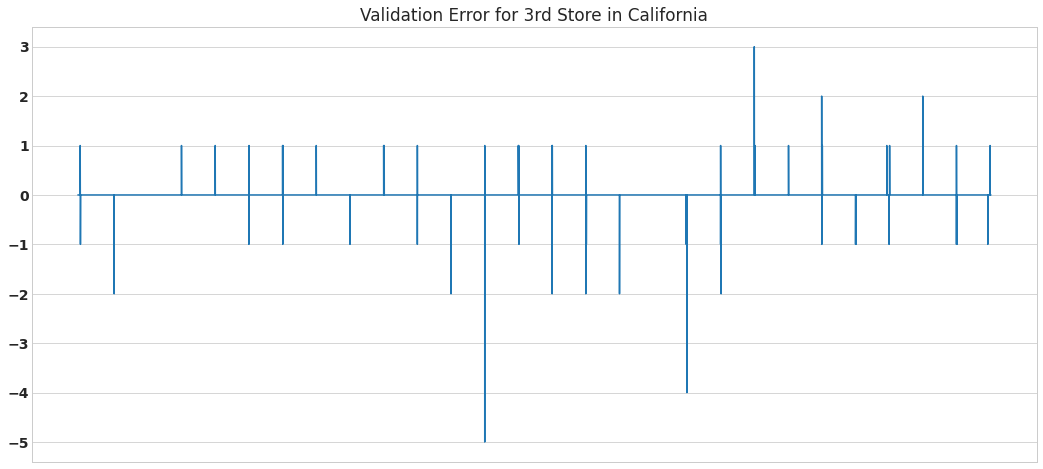

Total Sales       :   175360
Total Prediction  :   175364.0
Total Error       :  -4.0


In [279]:
# Plotting validation error for 3rd store in California

plt.title('Validation Error for 3rd Store in California')
df_validpred[df_validpred['store'] == 'CA_3']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_validpred[df_validpred['store'] == 'CA_3']['validation'].sum()))
print('Total Prediction  :   {}'.format(df_validpred[df_validpred['store'] == 'CA_3']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'CA_3']['valid_error'].round().sum()))

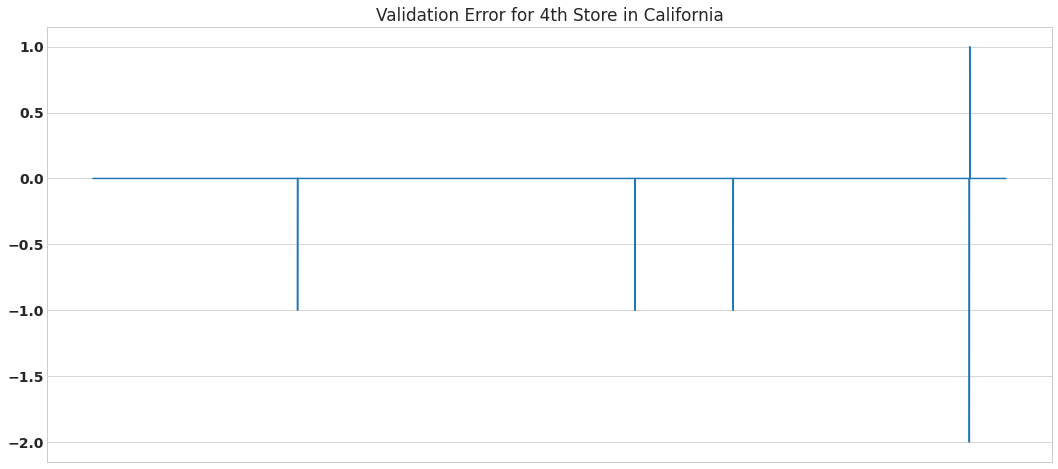

Total Sales       :   78858
Total Prediction  :   78862.0
Total Error       :  -4.0


In [280]:
# Plotting validation error for 4th store in California

plt.title('Validation Error for 4th Store in California')
df_validpred[df_validpred['store'] == 'CA_4']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_validpred[df_validpred['store'] == 'CA_4']['validation'].sum()))
print('Total Prediction  :   {}'.format(df_validpred[df_validpred['store'] == 'CA_4']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'CA_4']['valid_error'].round().sum()))

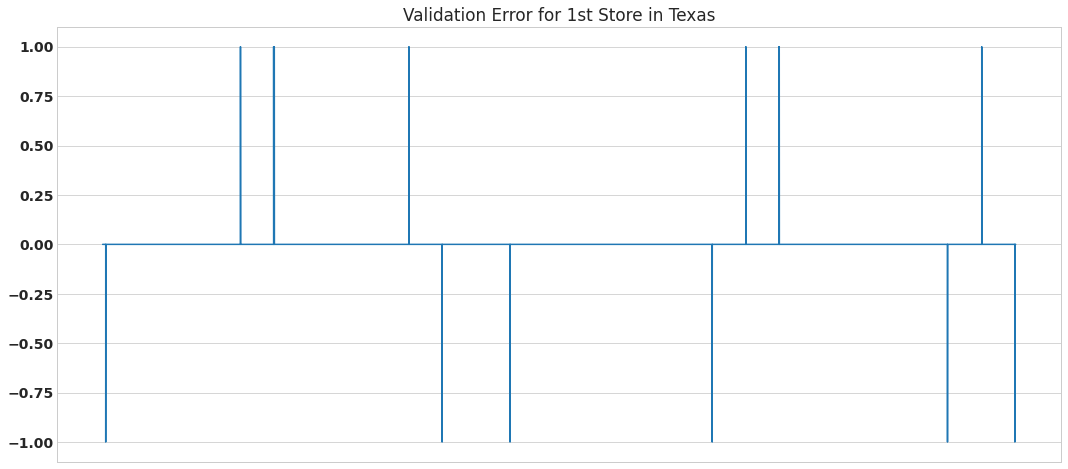

Total Sales       :  97531
Total Prediction  :  97528.0
Total Error       :  3.0


In [281]:
# Plotting validation error for 1st store in Texas

plt.title('Validation Error for 1st Store in Texas')
df_validpred[df_validpred['store'] == 'TX_1']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :  {}'.format(df_validpred[df_validpred['store'] == 'TX_1']['validation'].sum()))
print('Total Prediction  :  {}'.format(df_validpred[df_validpred['store'] == 'TX_1']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'TX_1']['valid_error'].round().sum()))

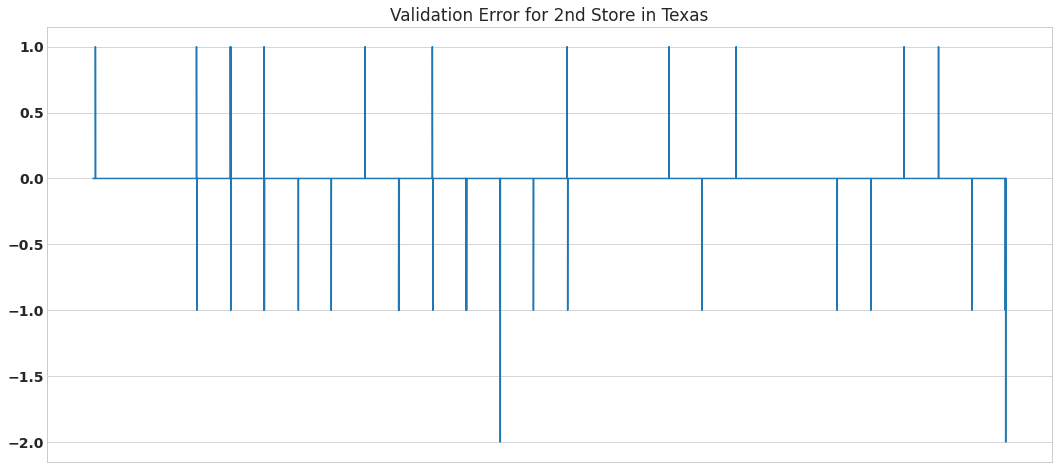

Total Sales       :   115258
Total Prediction  :   115269.0
Total Error       :  -11.0


In [282]:
# Plotting validation error for 2nd store in Texas

plt.title('Validation Error for 2nd Store in Texas')
df_validpred[df_validpred['store'] == 'TX_2']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_validpred[df_validpred['store'] == 'TX_2']['validation'].sum()))
print('Total Prediction  :   {}'.format(df_validpred[df_validpred['store'] == 'TX_2']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'TX_2']['valid_error'].round().sum()))

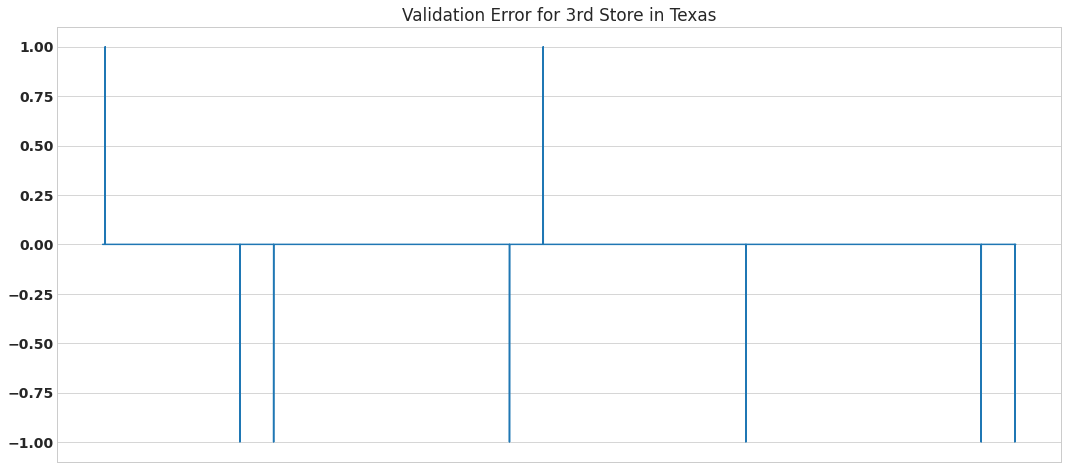

Total Sales       :   116610
Total Prediction  :   116614.0
Total Error       :  -4.0


In [283]:
# Plotting validation error for 3rd store in Texas

plt.title('Validation Error for 3rd Store in Texas')
df_validpred[df_validpred['store'] == 'TX_3']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_validpred[df_validpred['store'] == 'TX_3']['validation'].sum()))
print('Total Prediction  :   {}'.format(df_validpred[df_validpred['store'] == 'TX_3']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'TX_3']['valid_error'].round().sum()))

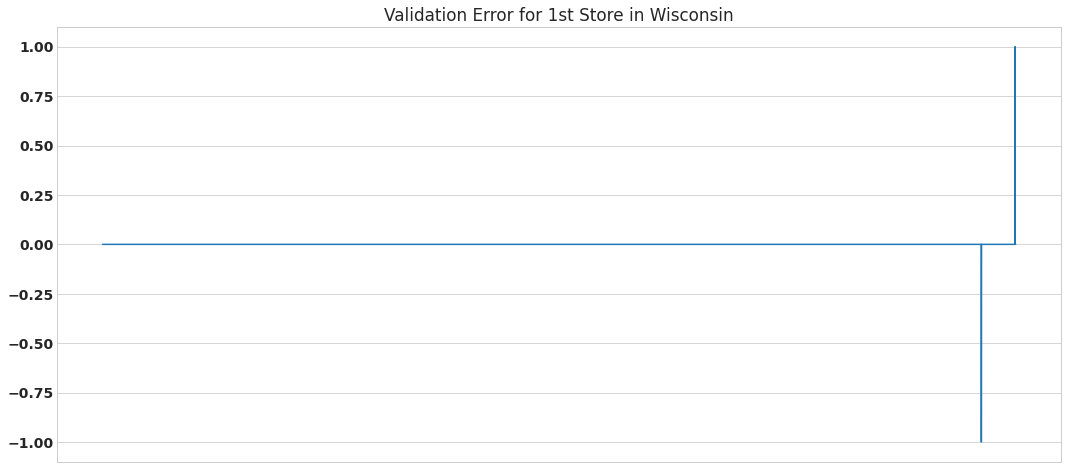

Total Sales       :  112444
Total Prediction  :  112444.0
Total Error       :  0.0


In [284]:
# Plotting validation error for 1st store in Wisconsin

plt.title('Validation Error for 1st Store in Wisconsin')
df_validpred[df_validpred['store'] == 'WI_1']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :  {}'.format(df_validpred[df_validpred['store'] == 'WI_1']['validation'].sum()))
print('Total Prediction  :  {}'.format(df_validpred[df_validpred['store'] == 'WI_1']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'WI_1']['valid_error'].round().sum()))

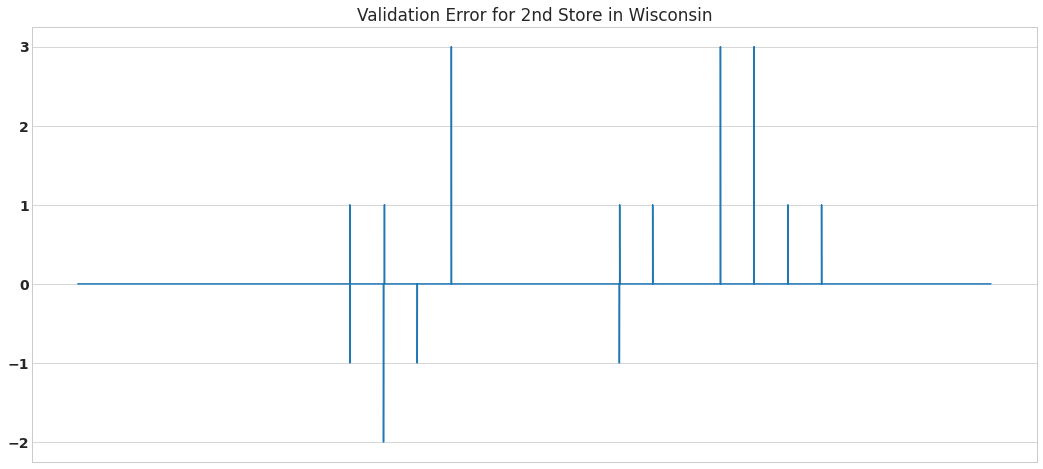

Total Sales       :  153976
Total Prediction  :  153966.0
Total Error       :  10.0


In [285]:
# Plotting validation error for 2nd store in Wisconsin

plt.title('Validation Error for 2nd Store in Wisconsin')
df_validpred[df_validpred['store'] == 'WI_2']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :  {}'.format(df_validpred[df_validpred['store'] == 'WI_2']['validation'].sum()))
print('Total Prediction  :  {}'.format(df_validpred[df_validpred['store'] == 'WI_2']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'WI_2']['valid_error'].round().sum()))

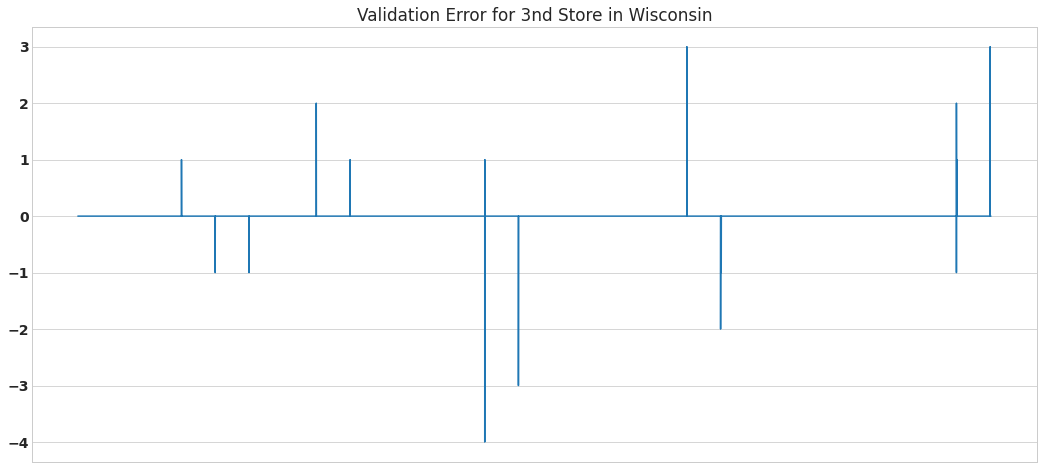

Total Sales       :   114775
Total Prediction  :   114774.0
Total Error       :  1.0


In [286]:
# Plotting validation error for 3nd store in Wisconsin

plt.title('Validation Error for 3nd Store in Wisconsin')
df_validpred[df_validpred['store'] == 'WI_3']['valid_error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_validpred[df_validpred['store'] == 'WI_3']['validation'].sum()))
print('Total Prediction  :   {}'.format(df_validpred[df_validpred['store'] == 'WI_3']['valid_prediction'].round().sum()))
print('Total Error       :  {}'.format(df_validpred[df_validpred['store'] == 'WI_3']['valid_error'].round().sum()))

### Analyzing Features

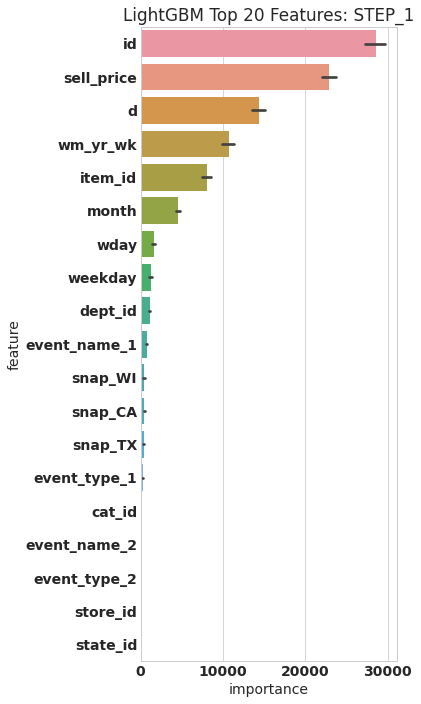

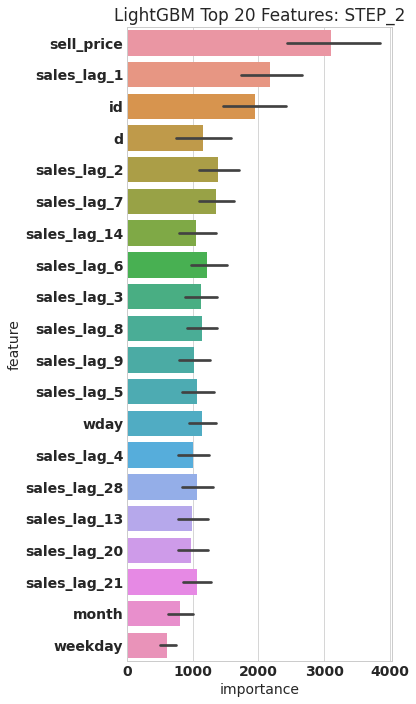

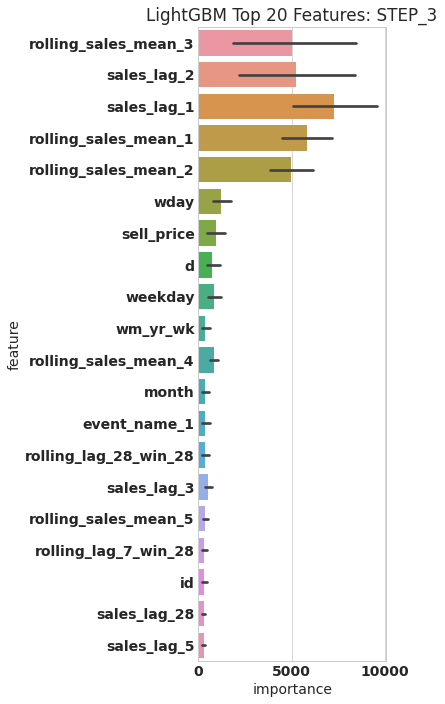

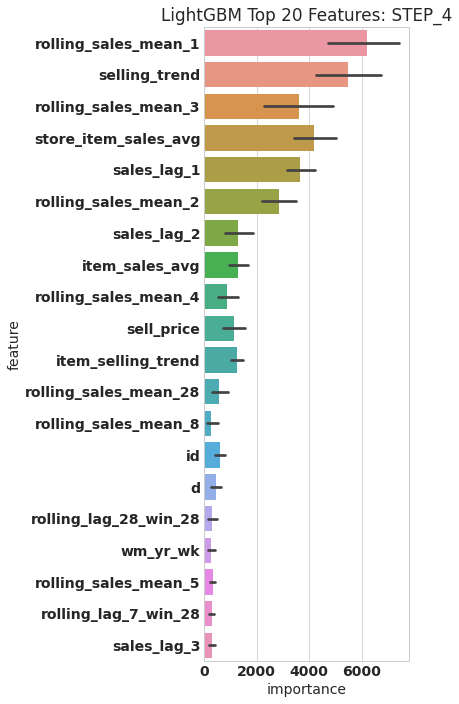

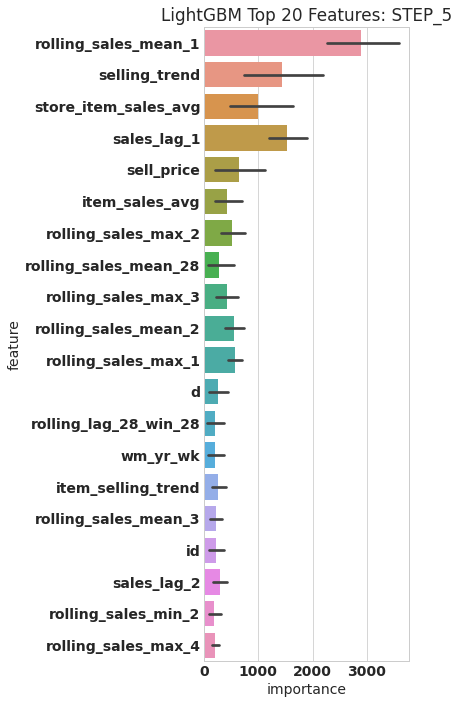

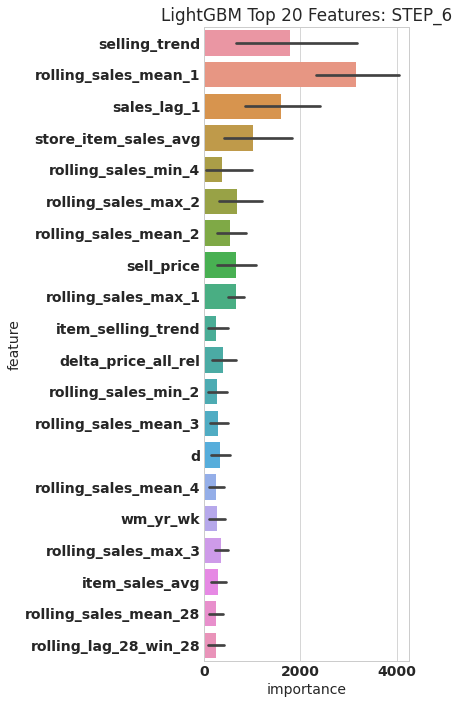

In [22]:
# Feature importances

for step in LIST_STEPS:

    FOLDER_MODEL = 'data/sales_forecasting/{}/'.format(step)
    Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)
    COLS_SCOPE = dict_features[step]

    feature_importance_df = pd.DataFrame()
    features = [f for f in COLS_SCOPE if f != 'sales']

    for store in stores:
        store_name = d_store_id[store]
        filename = FOLDER_MODEL + 'LGBM_model_' + str(d_store_id[store])+'.pkl'
        
        model = joblib.load(filename)

        # Create feature importances
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = store_name

        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

    # Calculate feature importances
    df_fi_mean = pd.DataFrame(feature_importance_df[
        ["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False))
    df_fi_mean.columns = ['importance']
    df_fi_mean['%_importance'] = (100 * df_fi_mean['importance']/df_fi_mean['importance'].sum(axis=0)).round(2)
    df_fi_mean.to_csv(FOLDER_MODEL + 'features_{}.csv'.format(step))


    # Plot results for top 20 features
    cols = df_fi_mean[:20].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    fig = plt.figure(figsize=(6,10))
    ax = fig.gca()
    sns.barplot(x="importance", y="feature", data = best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Top 20 Features: {}'.format(step))
    plt.tight_layout()
    fig.savefig(FOLDER_MODEL + 'features_{}.png'.format(step))
    plt.show()

## Analyzing the Results

From the results we see that at each step, the error term, RMSE, decreased as the model managed to reach higher accuracy compared to the previous steps. With a total a total sales forecast for 1.23M products, the model was able to forecast almost all the future sales with a very high accurary that only missed by 63 sales of the actual total sales on average for each store.

A closer look at the stores revealed, that the biggest spike of errors occurred with the 2nd Store and 3rd store in California, and to some extent with the 2nd store in Texas and Wisconsin.

In the SARIMAX type of linear models, the residuals are often examined to see if the fit can be improved. However, with boosting, the LGBM is able to fit a series of models in which each successive model seeks to minize the error of the previous model. This leads to the very low residual error that we just saw. We can also see that the residuals look like white noise in that the residuals contain no further information about the dependencies in the data. Moreover, the residuals have a zero mean, the same variance and are not correlated in time.

<b> Initial Data </b>

Here we had 20 variables that were given to us in the beginning. The model reached an RMSE of 1.672 which can be seen as a baseline for which to compare the results afterwards. The most important features were two variables related to the id of the product, the selling price, the day, the variable wm_yr_wk that contains year-week-code and the month. These variables were clearly the most important ones, but also the events and SNAP events did contribute which is interesting to note.

<b> Autoregressive </b>

Another 14 variables were added to mix,  in the form of lags from past autocorrelation of the target variable. These lags were added by looking at the PACF of sales in different stores. The RMSE improved with a decrease of 18 % from the previous step, to 1.377. The most important variables were the selling price, the sales lag from 1 day away, the id of the product, the day, and pretty much all the rest of the sales lag components that were created. We also notice that the date variables such as month and day of the week, now gained a higher importance compared to the previous step.

<b> Moving-Average </b>

Here, 28 variables were included in the form of lags that were calculated from the averages of sales in the past. The amount of lags was determined with the ACF of sales in different stores. We could see the model making it the most drastic improvement of all the steps by reaching RMSE of 0.09078 (93 % decrease from the previous steps). Looking at the most important features, we notice the rolling averages one to three days together with the sales lag from one and two days away. From the initial variables, we have the day of the week, the day, and the selling price that contributed for the accuracy of the forecast.

<b> Trend </b>

Two new trend variables were added to the model to take into account the increasing and decreasing trend of sales that was seen in the different stores. The model now further gained a 27 % decrease in the RMSE, by reaching 0.0660. What is interesting to see is that the sales averages that were included in the previous step, had a more important contribution now than previously. Besides the same sales lags and rolling averages that were important already in the previous step, also the two new selling trend variables contributed significantly to the accuracy of the model.

<b> Seasonal </b>

24 Seasonal variables to capture the low and high spikes from sales were now included in the model. The RMSE dropped a further 70 % from the previous, now reaching an error rate of 0.01936. Here the rolling maximum of the first 4 days and the rolling minimum of 2 days contributed to the accuracy of the model, together with the variables that were important already in the previous step.

<b> Relative Price</b>

For the last step, three variables depicting price elasticities and competition were added to the final model. The RMSE reached an error rate of 0.01915. The most important of the relative price variables seemed to be the price difference of the same products in other stores. This is the price that is set by each store individually, and it seems to have an effect on the consumer demand, based on these results.

<b> Conclusion </b>

With all the available features the model reached the highest rate of accuracy in the forecast. A closer look at the last step shows that the model utilized features from all the five different components that were created, and also from the variables that were given from the beginning. There were some issues related to the forecast error, especially in the second and third stores in California and the second store in Texas and Wisconsin, so next we will try to address these issues by fine-tuning the hyperparameters that will also give at the same time an opportunity to cross-validate the results.

# 6. Fine-Tuning the Best Model

As the results were quite good related to accuracy, we will focus on making sure the model doesn't overfit so that it manages to generalize also well with unseen data. For this, we will use a grid search that conducts an exhaustive search over all the combinations of the chosen hyperparameters related to overfitting, and combine it together with a K-fold Time Series -split for cross-validation. Split this way, enables the data to have fixed time intervals and the successive training sets to be supersets of those that come before them. 

We will perform the forecast similarly as before, by conducting a separate forecast for each store but this time we will add more regularization for the features as well as random sampling of the features. This forces the model to try different sets of features, and thus helps with not getting overfitted.

## Grid Search Cross-Validation

In [23]:
# GridSearchCV for each store individually with 5 K-fold

stores = data.store_id.unique()
d_store_id = dict_data['d_store_id']

FOLDER_MODEL = 'data/sales_forecasting/cv/'
Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)

# Saving results
dict_cv = {}
dict_params = {}
dict_cv_features = {}
dict_cv_results = {}
df_preds = pd.DataFrame()

for store in tqdm(stores): # Loop over stores and keep track of time
    df = data.copy()
        
    df = df[df['store_id']==store] # Select store

    X_train, y_train = df[df['d']<1914].drop('sales', axis=1), df[df['d']<1914]['sales'] 

        
    X_test, y_test = df[(df['d']>=1914) & (df['d']<1942)].drop('sales', axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sales']
    
    # Search parameters
    param_grid = [{ 'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5], 'colsample_bytree': [0.6, 0.8] }]
    
    # The model
    lgbm_reg = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.08,
            max_depth=8,
            objective='poisson',
            num_leaves=100,
            min_child_weight=300,
            subsample=0.8,
            random_state=42
        )
    # Cross-validation with Grid Search
    cv = TimeSeriesSplit(n_splits=5).get_n_splits([X_train, y_train])    
    grid_search = GridSearchCV(lgbm_reg, param_grid, scoring='neg_mean_squared_error', cv=cv)
    grid_search.fit(X_train, y_train, verbose=0)
    
    # Prediction
    y_preds = grid_search.predict(X_test)

    # DataFrame for predictions    
    df_cv = pd.DataFrame({
            'testing':y_test,
            'prediction':y_preds,
            'store': d_store_id[store]
        })
    df_cv['error'] = df_cv['testing'] - df_cv['prediction']
    df_cv['RMSE'] = np.sqrt(np.mean((df_cv.testing.values - df_cv.prediction.values) ** 2))/np.mean(df_cv.testing.values)
    df_preds = pd.concat([df_preds, df_cv])
    
    # Save to dictionary   
    dict_cv[store] = np.sqrt(-grid_search.best_score_)
    dict_params[store] = grid_search.best_params_
    dict_cv_features[store] = grid_search.best_estimator_.feature_importances_
    dict_cv_results[store] = grid_search.cv_results_
    
    # Save the model
    filename = FOLDER_MODEL + 'cv_model_' + str(d_store_id[store])+'.pkl'
    joblib.dump(grid_search, filename)
  
    print('RMSE for {0} = {1}'.format(d_store_id[store], np.round_(np.sqrt(-grid_search.best_score_), 5)))
    print('=' * 25)
    print(grid_search.best_params_)
    print('-' * 35)
    
    del grid_search, df, X_train, y_train, X_test, y_test

# Save prediction for all stores
df_preds.to_csv(FOLDER_MODEL + 'df_preds.csv')

# CV results for all stores
df_cv_results = pd.DataFrame({
    'RMSE': [dict_cv[store] for store in stores],
    'PARAMS': [dict_params[store] for store in stores],
    'FEATURES': [dict_cv_features[store] for store in stores],
    'RESULTS': [dict_cv_results[store] for store in stores]
    })
df_cv_results.to_csv(FOLDER_MODEL + 'df_cv_results.csv')

# Average RMSE for all stores
print('AVG RMSE = {}'.format(np.round(df_cv_results['RMSE'].mean(),5)))

# Test RMSE for all stores
print('TEST RMSE = {}'.format(np.round(df_preds['RMSE'].mean(),5)))

RMSE for CA_1 = 0.26008
{'colsample_bytree': 0.8, 'reg_lambda': 0.1}
-----------------------------------
RMSE for CA_2 = 0.05912
{'colsample_bytree': 0.6, 'reg_lambda': 0.2}
-----------------------------------
RMSE for CA_3 = 0.26534
{'colsample_bytree': 0.6, 'reg_lambda': 0.5}
-----------------------------------
RMSE for CA_4 = 0.07392
{'colsample_bytree': 0.8, 'reg_lambda': 0.5}
-----------------------------------
RMSE for TX_1 = 0.14145
{'colsample_bytree': 0.8, 'reg_lambda': 0.4}
-----------------------------------
RMSE for TX_2 = 0.16126
{'colsample_bytree': 0.8, 'reg_lambda': 0.5}
-----------------------------------
RMSE for TX_3 = 0.19837
{'colsample_bytree': 0.8, 'reg_lambda': 0.4}
-----------------------------------
RMSE for WI_1 = 0.05314
{'colsample_bytree': 0.8, 'reg_lambda': 0.5}
-----------------------------------
RMSE for WI_2 = 0.09678
{'colsample_bytree': 0.6, 'reg_lambda': 0.1}
-----------------------------------
RMSE for WI_3 = 0.19414
{'colsample_bytree': 0.6, 'reg_

## Evaluating the results

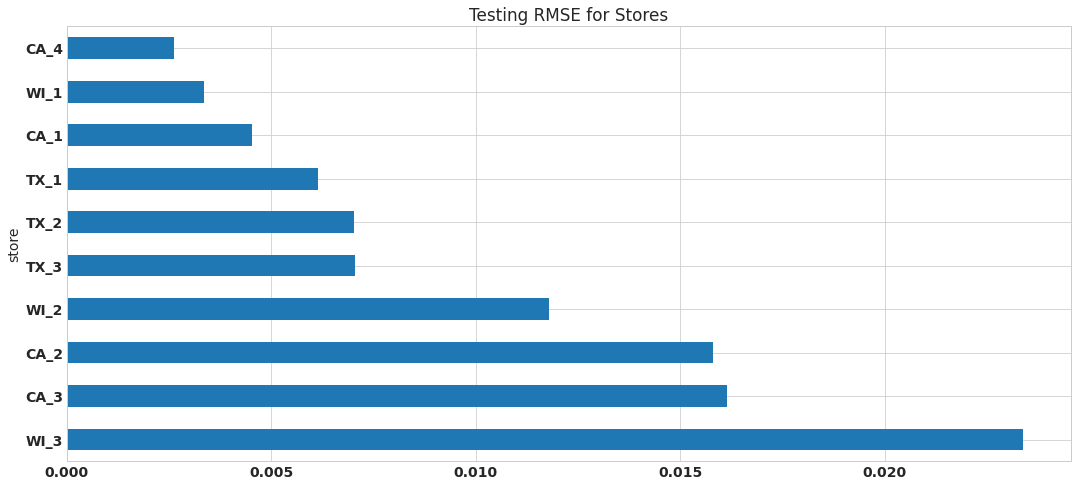

In [336]:
# Plotting results for Testing RMSE

df_preds.groupby('store')['RMSE'].mean().sort_values(ascending=False).plot(kind='barh')
plt.title('Testing RMSE for Stores')
plt.show()

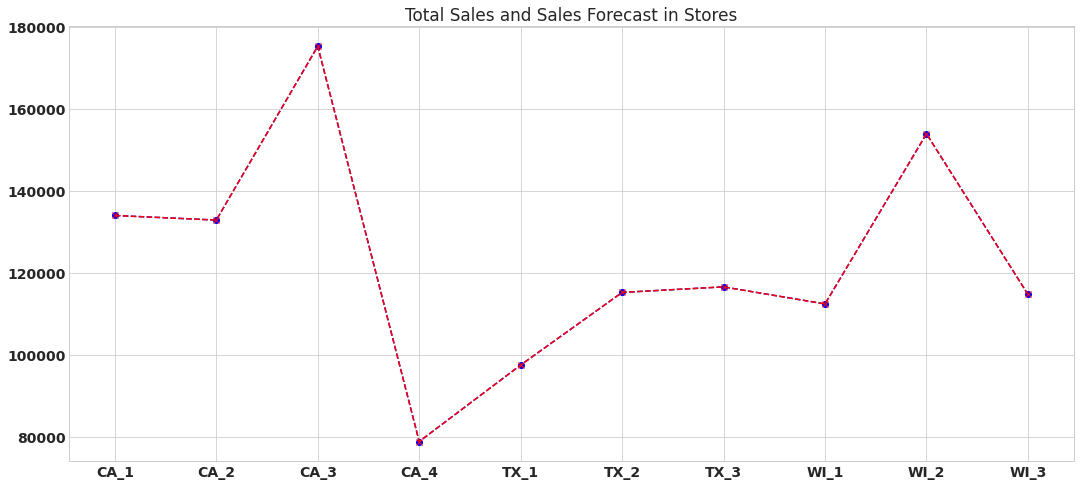

Total Sales in Stores    : 1231764
Total Sales Predictions  : 1231740.0
Total Sales Error        : 24.0


In [266]:
# Plotting forecast for sales total in each store

total_store_sales = df_preds.groupby(['store'])['testing'].sum()
predicted_store_sales = df_preds.groupby(['store'])['prediction'].sum()

plt.plot(total_store_sales, marker = 'o', linestyle= '--', color='blue')
plt.plot(predicted_store_sales, marker = 'x', linestyle = '--', color='red')
plt.title('Total Sales and Sales Forecast in Stores')
plt.show()
print('Total Sales in Stores    : {}'.format(df_preds['testing'].sum()))
print('Total Sales Predictions  : {}'.format(df_preds['prediction'].round().sum()))
print('Total Sales Error        : {}'.format((df_preds['testing']-df_preds['prediction']).round().sum()))

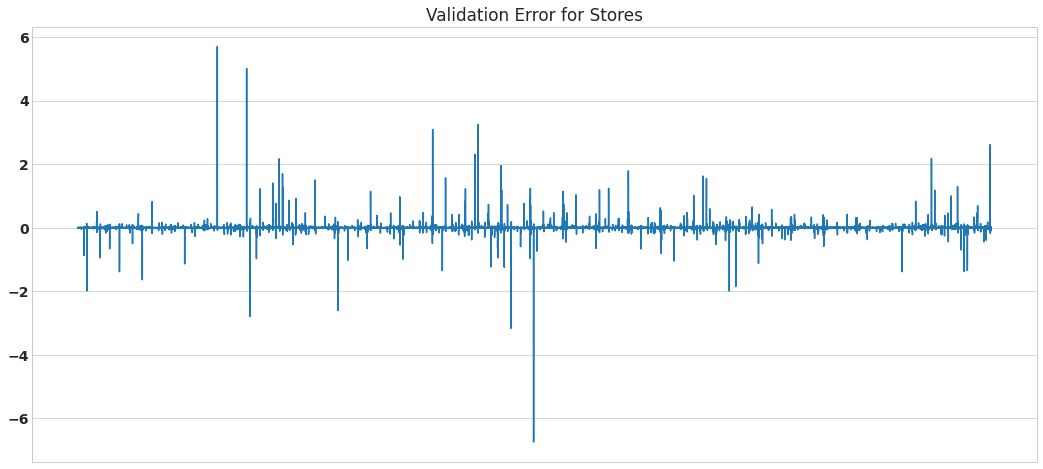

In [27]:
# Plotting validation error

df_preds['error'] = df_preds['testing']-df_preds['prediction']
df_preds['error'].plot()
plt.title('Validation Error for Stores')
plt.xticks([])
plt.show()

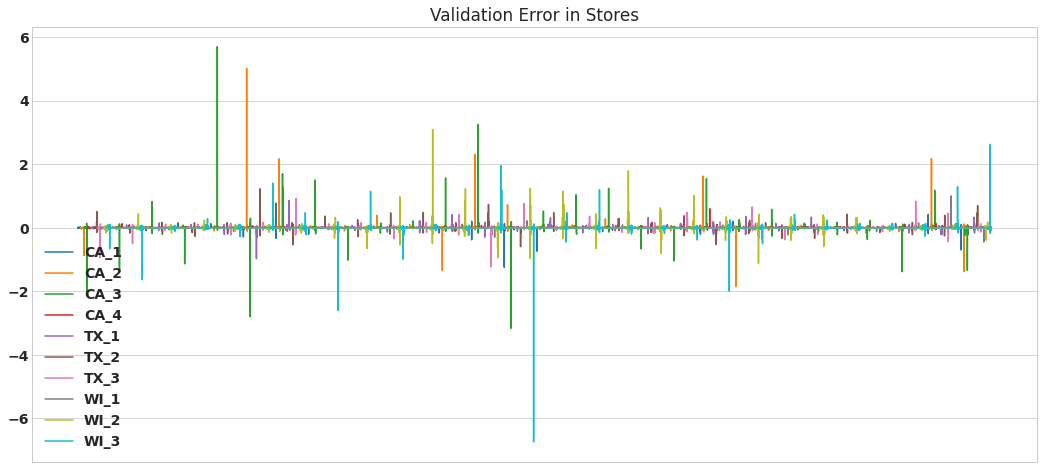

In [28]:
# Validation error by store

df_preds.groupby('store')['error'].plot(legend=True)
plt.title('Validation Error in Stores')
plt.xticks([])
plt.show()

In [40]:
df_preds['error'].describe()

count    853720.000000
mean          0.000034
std           0.018586
min          -6.745024
25%          -0.000046
50%          -0.000030
75%          -0.000020
max           5.699786
Name: error, dtype: float64

### 1st Store in California

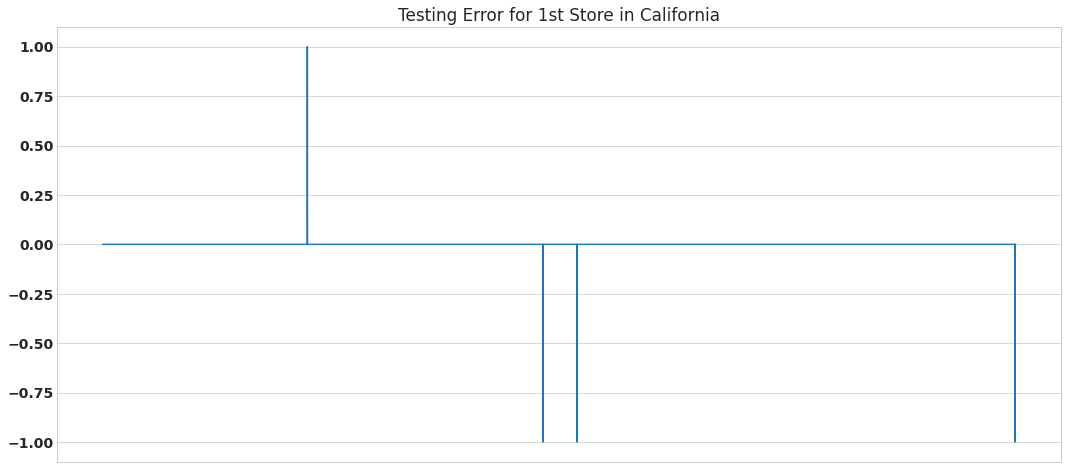

Total Sales       :   134032
Total Prediction  :   134034.0
Total Error       :  -2.0


In [260]:
# Plotting testing error for 1st store in California

plt.title('Testing Error for 1st Store in California')
df_preds[df_preds['store'] == 'CA_1']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'CA_1']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'CA_1']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'CA_1']['error'].round().sum()))

### 2nd Store in California

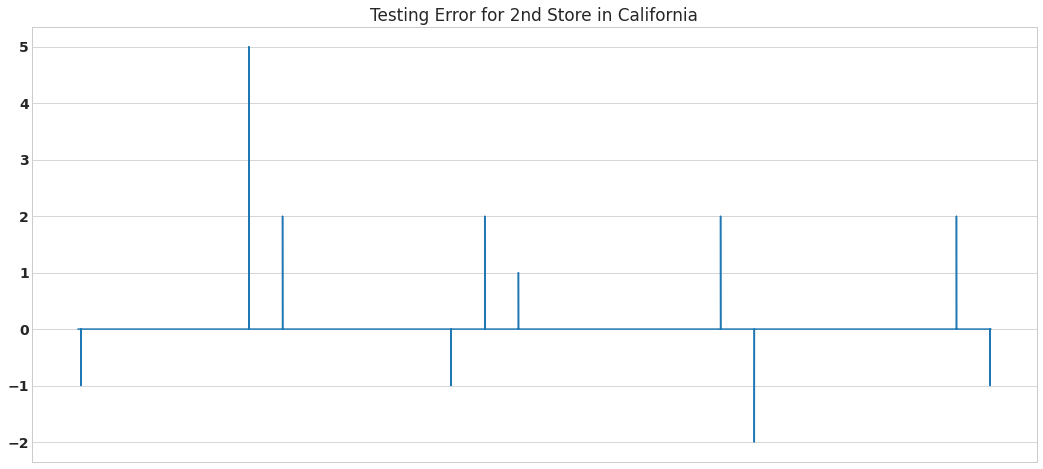

Total Sales       :   132920
Total Prediction  :   132911.0
Total Error       :  9.0


In [259]:
# Plotting testing error for 2nd store in California

plt.title('Testing Error for 2nd Store in California')
df_preds[df_preds['store'] == 'CA_2']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'CA_2']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'CA_2']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'CA_2']['error'].round().sum()))

### 3rd Store in California

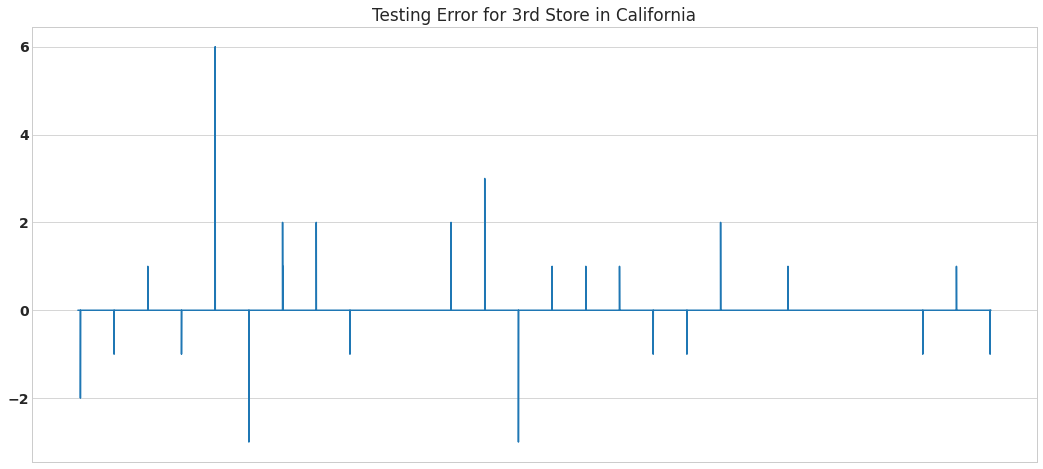

Total Sales       :   175360
Total Prediction  :   175351.0
Total Error       :  9.0


In [258]:
# Plotting testing error for 3rd store in California

plt.title('Testing Error for 3rd Store in California')
df_preds[df_preds['store'] == 'CA_3']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'CA_3']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'CA_3']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'CA_3']['error'].round().sum()))

### 4th Store in California

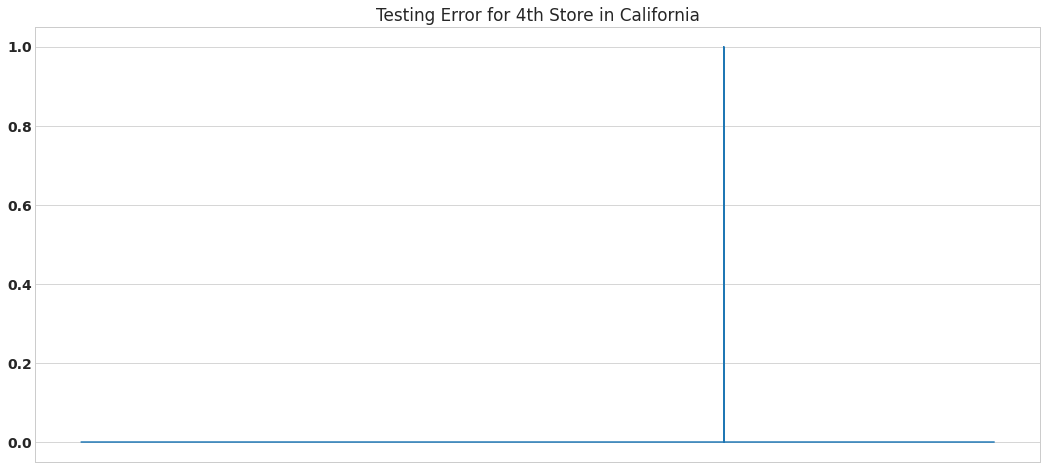

Total Sales       :   78858
Total Prediction  :   78857.0
Total Error       :  1.0


In [257]:
# Plotting testing error for 4th store in California

plt.title('Testing Error for 4th Store in California')
df_preds[df_preds['store'] == 'CA_4']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'CA_4']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'CA_4']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'CA_4']['error'].round().sum()))

### 1st Store in Texas

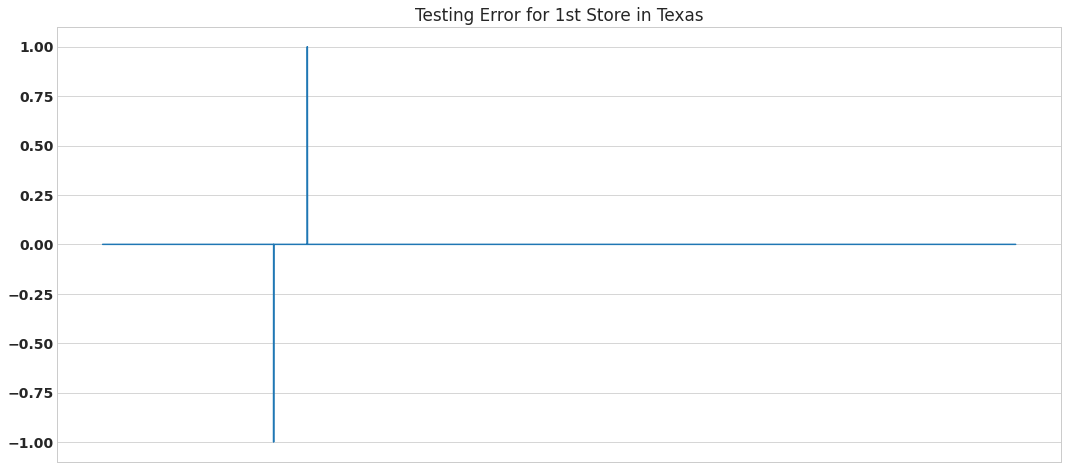

Total Sales       :   97531
Total Prediction  :   97531.0
Total Error       :  0.0


In [256]:
# Plotting testing error for 1st store in Texas

plt.title('Testing Error for 1st Store in Texas')
df_preds[df_preds['store'] == 'TX_1']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'TX_1']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'TX_1']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'TX_1']['error'].round().sum()))

### 2nd Store in Texas

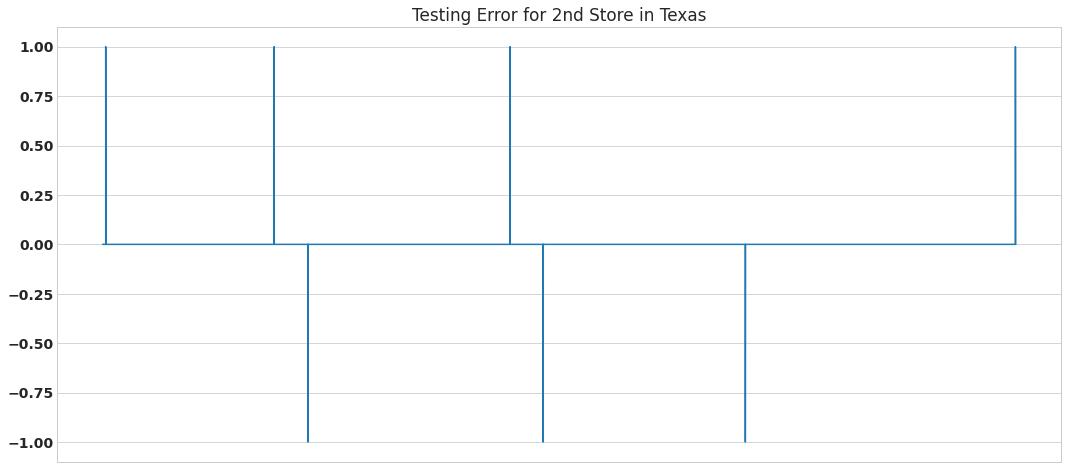

Total Sales       :   115258
Total Prediction  :   115257.0
Total Error       :  1.0


In [261]:
# Plotting testing error for 2nd store in Texas

plt.title('Testing Error for 2nd Store in Texas')
df_preds[df_preds['store'] == 'TX_2']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'TX_2']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'TX_2']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'TX_2']['error'].round().sum()))

### 3rd Store in Texas

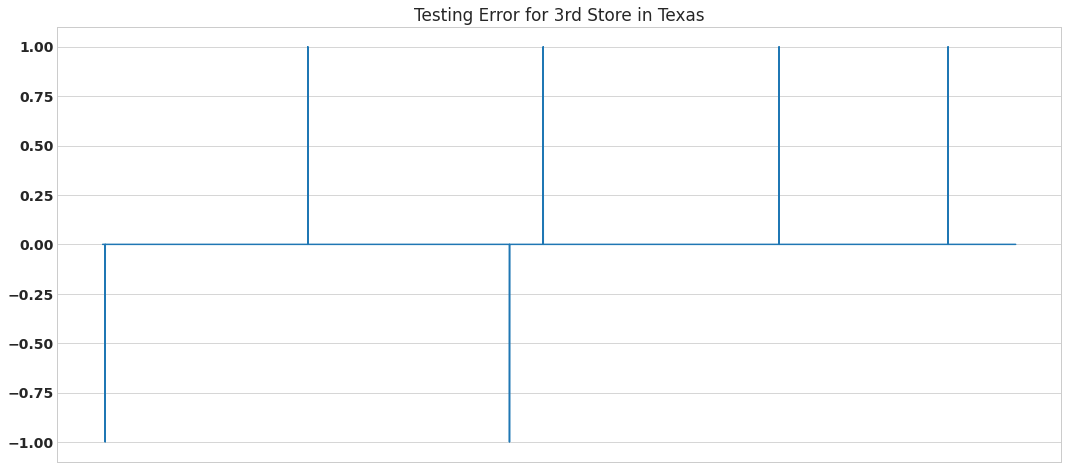

Total Sales       :   116610
Total Prediction  :   116608.0
Total Error       :  2.0


In [262]:
# Plotting testing error for 3rd store in Texas

plt.title('Testing Error for 3rd Store in Texas')
df_preds[df_preds['store'] == 'TX_3']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'TX_3']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'TX_3']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'TX_3']['error'].round().sum()))

### 1st Store in Wisconsin

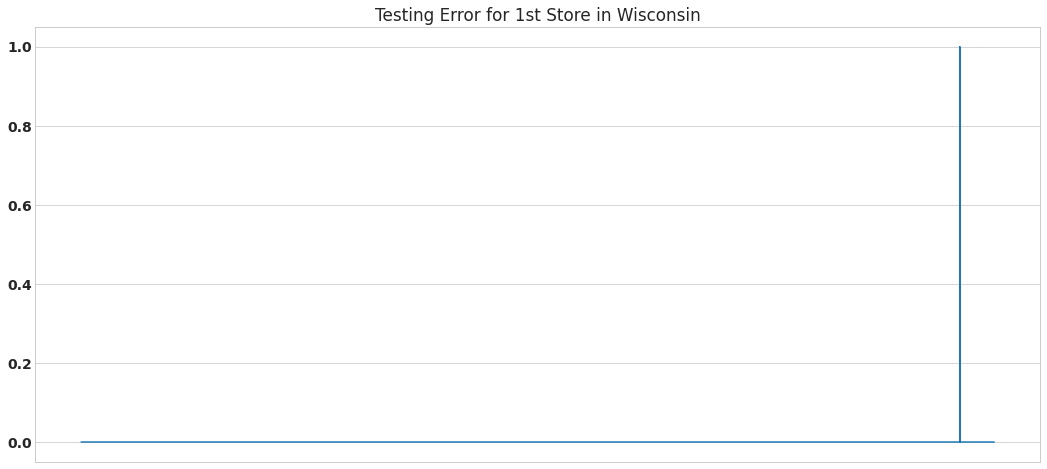

Total Sales       :   112444
Total Prediction  :   112443.0
Total Error       :  1.0


In [263]:
# Plotting testing error for 1st store in Wisconsin

plt.title('Testing Error for 1st Store in Wisconsin')
df_preds[df_preds['store'] == 'WI_1']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'WI_1']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'WI_1']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'WI_1']['error'].round().sum()))

### 2nd Store in Wisconsin

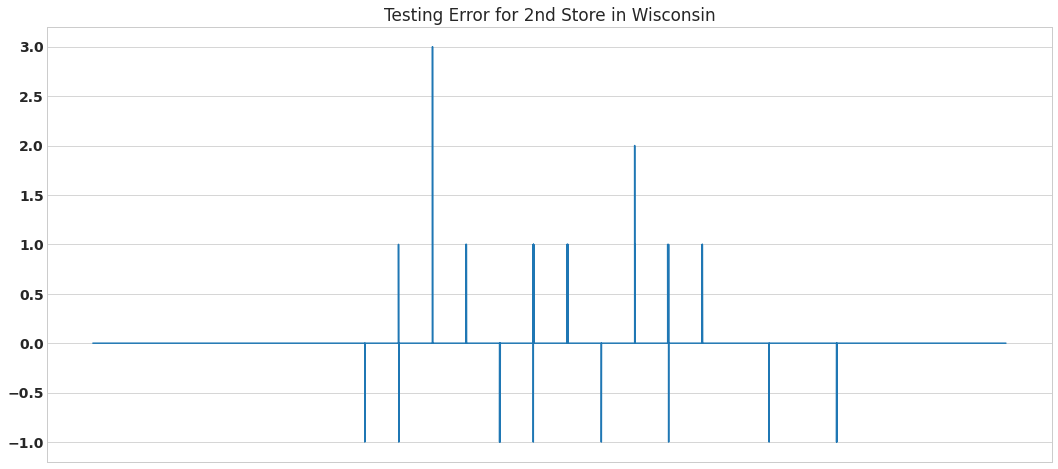

Total Sales       :   153976
Total Prediction  :   153966.0
Total Error       :  10.0


In [264]:
# Plotting testing error for 2nd store in Wisconsin

plt.title('Testing Error for 2nd Store in Wisconsin')
df_preds[df_preds['store'] == 'WI_2']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'WI_2']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'WI_2']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'WI_2']['error'].round().sum()))

### 3rd Store in Wisconsin

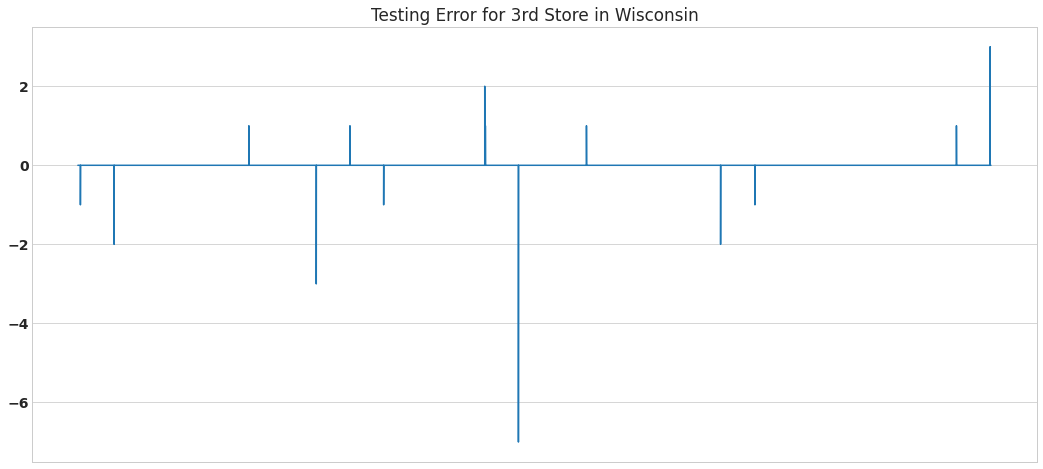

Total Sales       :   114775
Total Prediction  :   114782.0
Total Error       :  -7.0


In [265]:
# Plotting testing error for 3rd store in Wisconsin

plt.title('Testing Error for 3rd Store in Wisconsin')
df_preds[df_preds['store'] == 'WI_3']['error'].round().plot()
plt.xticks([])
plt.show()
print('Total Sales       :   {}'.format(df_preds[df_preds['store'] == 'WI_3']['testing'].sum()))
print('Total Prediction  :   {}'.format(df_preds[df_preds['store'] == 'WI_3']['prediction'].round().sum()))
print('Total Error       :  {}'.format(df_preds[df_preds['store'] == 'WI_3']['error'].round().sum()))

# 7. Drawing Conclusions

The goal was to forecast 28 days of sales for 10 stores located in 3 States in the US. After first creating relevant features to extract sales patterns from the past, the LGBM model was able to reach an accuracy that predicted on average almost all future sales with an absolute error rate of only missing on average 27 sales out from total sales of 1231764.

The results where then cross-validated with a 5 k-fold which also enabled to fine-tune the regularization terms of the model. This lead for the RMSE to decrease further to an average error of 0.00979 with an absolute forecast error of 24 sales on average. With the final model, the absolute errors for all the stores remained mostly in single digits which is remarkable if we think how many products are sold each day at these stores. 

After achieving the great results, the forecast could be easily updated with new data without affecting the overall architecture or the features of the model. The LGBM model thus offers a powerful way to forecast accurately when dealing with large and complicated datasets.